<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [7070]:
import os
import sys
import json

import statistics
import collections
import operator
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from matplotlib import colors
import matplotlib.patches as mpatches

from collections import Counter
from collections import OrderedDict

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from  matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler



plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

In [7071]:
tracks = pd.read_csv('../../data/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
tracks.shape

(106574, 52)

In [7072]:
tracks.head(3).T

track_id                                                                  2  \
album  comments                                                           0   
       date_created                                     2008-11-26 01:44:45   
       date_released                                    2009-01-05 00:00:00   
       engineer                                                         NaN   
       favorites                                                          4   
       id                                                                 1   
       information                                                  <p></p>   
       listens                                                         6073   
       producer                                                         NaN   
       tags                                                              []   
       title                                           AWOL - A Way Of Life   
       tracks                                                             7   
       type                                                           Album   
artist active_year_begin                                2006-01-01 00:00:00   
       active_year_end                                                  NaN   
       associated_labels                                                NaN   
       bio                <p>A Way Of Life, A Collective of Hip-Hop from...   
       comments                                                           0   
       date_created                                     2008-11-26 01:42:32   
       favorites                                                          9   
       id                                                                 1   
       latitude                                                     40.0583   
       location                                                  New Jersey   
       longitude                                                   -74.4057   
       members            Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...   
       name                                                            AWOL   
       related_projects   The list of past projects is 2 long but every1...   
       tags                                                        ['awol']   
       website                      http://www.AzillionRecords.blogspot.com   
       wikipedia_page                                                   NaN   
set    split                                                       training   
       subset                                                         small   
track  bit_rate                                                      256000   
       comments                                                           0   
       composer                                                         NaN   
       date_created                                     2008-11-26 01:48:12   
       date_recorded                                    2008-11-26 00:00:00   
       duration                                                         168   
       favorites                                                          2   
       genre_top                                                    Hip-Hop   
       genres                                                          [21]   
       genres_all                                                      [21]   
       information                                                      NaN   
       interest                                                        4656   
       language_code                                                     en   
       license            Attribution-NonCommercial-ShareAlike 3.0 Inter...   
       listens                                                         1293   
       lyricist                                                         NaN   
       number                                                             3   
       publisher                                  

<h1>DataFrame's headers </h1>

In [7073]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 52 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   (album, comments)            106574 non-null  int64  
 1   (album, date_created)        103045 non-null  object 
 2   (album, date_released)       70294 non-null   object 
 3   (album, engineer)            15295 non-null   object 
 4   (album, favorites)           106574 non-null  int64  
 5   (album, id)                  106574 non-null  int64  
 6   (album, information)         83149 non-null   object 
 7   (album, listens)             106574 non-null  int64  
 8   (album, producer)            18060 non-null   object 
 9   (album, tags)                106574 non-null  object 
 10  (album, title)               105549 non-null  object 
 11  (album, tracks)              106574 non-null  int64  
 12  (album, type)                100066 non-null  object 
 13 

<h1>DataFrame's ids consistencies</h1>

<font color="fuchsia"><h6>('album', 'id') consistency </h6></font>

In [7074]:
def check_id_consistency_in_dataset(artist_or_album_flag):
    consistent_column_among_ids = []
    if artist_or_album_flag == 'album':
        for column_name in tracks.columns:
            if column_name[0] != 'track' and column_name[0] != 'set' and column_name[1] != 'id':
                consistent_column_among_ids.append(column_name)
    elif artist_or_album_flag == 'artist':
        for column_name in tracks.columns:
            if column_name[0] != 'track' and column_name[0] != 'set' and column_name[0] != 'album'and \
                                                                                        column_name[1] != 'id':
                consistent_column_among_ids.append(column_name)
    else:
        print("wrong artist_or_album_flag")
        sys.exit(-1)
    
    unique_ids = tracks[(artist_or_album_flag, 'id')].unique()
    print("TOTAL NUMBER OF UNIQUE %s=%s" % (artist_or_album_flag.upper(),len(unique_ids)))
    print()

    consistency_flag = True
    for aid in unique_ids:
        if int(aid) == -1:
            continue
        tmp_df = tracks[tracks[(artist_or_album_flag, 'id')] == aid][consistent_column_among_ids].dropna()
        dups = tmp_df.duplicated()
        for value, count in dups.value_counts().iteritems():
            # number of duplicate rows must be equal to N - 1, since the first row isn't a duplicate of itself,
            # the other 2,..., N are, insteaded, duplicates of the first in order to have an ID consistency
            if value:
                if count != tmp_df.shape[0] - 1: 
                    print(tmp_df)
                    print("inconsistent rows for id = %s" % aid)
                    consistency_flag = False
                    break
    if consistency_flag:
        print("Dataset is consistent for all %ss" % artist_or_album_flag)

In [7075]:
check_id_consistency_in_dataset('album')

TOTAL NUMBER OF UNIQUE ALBUM=14854

Dataset is consistent for all albums


<font color="fuchsia"><h6>('artist', 'id') consistency</h6></font>

In [7076]:
check_id_consistency_in_dataset('artist')

TOTAL NUMBER OF UNIQUE ARTIST=16341

Dataset is consistent for all artists


<font color="fuchsia"><h6>('track', 'id') consistency (duplicate rows) </h6></font>
Checking if exist duplicated rows (tracks with different ids, but related to same track)

In [7077]:
dups = tracks.duplicated()
if dups.any() == False:
    print("Dataset is consistent for all tracks")

# delete duplicate rows
# df.drop_duplicates(inplace=True)

Dataset is consistent for all tracks


<font color="fuchsia"><h6>('track', 'title') consistency </h6></font>
Checking if exists tracks having the same title.  
If a track have the same title, than we investigate if it belongs:
- to the same artist (a song can have the same name but be sung by different singers); 
- to the same album (multiple songs can be the same one, belonging to the same album, sung by the same artist, but having different intrinsic, characteristics, i.e. duration or listens);
- both.

In [7078]:
check0 = tracks[tracks[[('track', 'title')]].duplicated(keep=False)]
print("tracks with same title", check0.shape[0], len(check0[('track', 'title')].unique()))
check1 = tracks[tracks[[('artist', 'id'), ('track', 'title')]].duplicated(keep=False)]
print("tracks with same title and artist id", len(check1[('artist', 'id')].unique()))
check2 = tracks[tracks[[('album', 'id'), ('track', 'title')]].duplicated(keep=False)]
print("tracks with same title and album id", len(check2[('album', 'id')].unique()))
check3 = tracks[tracks[[('album', 'id'),('artist', 'id'), ('track', 'title')]].duplicated(keep=False)]
print("tracks with same title, artist id and album id", len(check3[('track', 'title')].unique()))

tracks with same title 17860 6273
tracks with same title and artist id 1020
tracks with same title and album id 228
tracks with same title, artist id and album id 183


17.860 tracks are involved in 6.273 duplicated titles (belonging the same artist/album or not).
Bellow, we try to get more insight in this phenomena.

In [7079]:
def sns_barplot_x_and_y(param_dict, x_label, title, log_flag, rotation_flag):
    sns.barplot(x=list(param_dict.keys()), y=list(param_dict.values()), color="#4C72B0")
    if log_flag:
        plt.yscale('log')
    if rotation_flag:
        plt.xticks(rotation=90)
    plt.xlabel(x_label)
    plt.ylabel("count")
    plt.title(title)
    plt.show()

In [7080]:
def same_album_check(different_version_flag, column_name):
    track_columns = [column_name for column_name in tracks.columns if column_name[0] == 'track']
    track_columns_different_version = [('track', 'date_created'), ('track', 'duration'), 
                              ('track', 'comments'), ('track', 'favorites'), ('track', 'interest'),
                               ('track', 'listens'), ('track', 'bit_rate'), ('track', 'genre_top')]
    if different_version_flag:
        columns = track_columns_different_version
    else:
        columns = [column_name]
    
    accordances = set()
    divergeces = set()
    dur_accordances = set()
    dur_divergeces = set()
    artist_ids = tracks[('artist', 'id')].unique()
    for aid in artist_ids:
        tmp_list = tracks[(tracks[('artist', 'id')] == aid)][('track', 'title')].values
        # retrieving duplicate tracks' title in current album (if there are some)
        duplicate_titles = [item for item, count in Counter(tmp_list).items() if count > 1]
        duplicate_titles = set(duplicate_titles)
        for title in duplicate_titles:
            tmp_df = tracks[(tracks[('artist', 'id')] == aid) & (tracks['track', 'title'] == title)]

            if len(tmp_df[tmp_df[('album', 'id')] != -1][('album', 'id')].unique()) == 1:  # same title, in same album
                title_indeces = list(tmp_df.index)
                for i in range(0, len(title_indeces) - 1):
                    idx1 = title_indeces[i]
                    for j in range(i + 1, len(title_indeces)):
                        idx2 = title_indeces[j]
                        divergence_flag = False
                        for column_name in columns:
                            value1 = tracks.at[idx1, column_name]
                            value2 = tracks.at[idx2, column_name]
                            if pd.isnull(value1) and pd.isnull(value2):
                                continue
                            if pd.isnull(value1) and (pd.isnull(value2) == False):
                                divergence_flag = True
                            elif (pd.isnull(value1) == False) and pd.isnull(value2):
                                divergence_flag = True
                            else:
                                if value1 != value2:
                                    divergence_flag = True
                        if divergence_flag == False:
                            if different_version_flag:
                                accordances.add((aid, title))
                            if different_version_flag == False:
                                dur_accordances.add((aid, title))
                        else:
                            if different_version_flag:
                                divergeces.add((aid, title))
                            if different_version_flag == False:
                                dur_divergeces.add((aid, title))
    if different_version_flag:
        print("accordances", len(accordances))
        print("divergeces", len(divergeces))
    if different_version_flag == False:
        print("%s accordances" % str(column_name), len(dur_accordances))
        print("%s divergeces" % str(column_name), len(dur_divergeces))

In [7081]:
def different_album_check(different_version_flag, column_name):
    track_columns = [column_name for column_name in tracks.columns if column_name[0] == 'track']
    track_columns_different_version = [('track', 'date_created'), ('track', 'duration'), 
                              ('track', 'comments'), ('track', 'favorites'), ('track', 'interest'),
                               ('track', 'listens'), ('track', 'bit_rate'), ('track', 'genre_top')]
    if different_version_flag:
        columns = track_columns_different_version
    else:
        columns = [column_name]
    
    accordances = set()
    divergeces = set()
    dur_accordances = set()
    dur_divergeces = set()
    artist_ids = tracks[('artist', 'id')].unique()
    for aid in artist_ids:
        tmp_list = tracks[(tracks[('artist', 'id')] == aid)][('track', 'title')].values
        # retrieving duplicate tracks' title in current album (if there are some)
        duplicate_titles = [item for item, count in Counter(tmp_list).items() if count > 1]
        duplicate_titles = set(duplicate_titles)
        for title in duplicate_titles:
            tmp_df = tracks[(tracks[('artist', 'id')] == aid) & (tracks['track', 'title'] == title)]

            if len(tmp_df[tmp_df[('album', 'id')] != -1][('album', 'id')].unique()) > 1:  # same title, different albums
                title_indeces = list(tmp_df.index)
                for i in range(0, len(title_indeces) - 1):
                    idx1 = title_indeces[i]
                    for j in range(i + 1, len(title_indeces)):
                        idx2 = title_indeces[j]
                        divergence_flag = False
                        for column_name in columns:
                            value1 = tracks.at[idx1, column_name]
                            value2 = tracks.at[idx2, column_name]
                            if pd.isnull(value1) and pd.isnull(value2):
                                continue
                            if pd.isnull(value1) and (pd.isnull(value2) == False):
                                divergence_flag = True
                            elif (pd.isnull(value1) == False) and pd.isnull(value2):
                                divergence_flag = True
                            else:
                                if value1 != value2:
                                    divergence_flag = True
                        if divergence_flag == False:
                            if different_version_flag:
                                accordances.add((aid, title))
                            if different_version_flag == False:
                                dur_accordances.add((aid, title))
                        else:
                            if different_version_flag:
                                divergeces.add((aid, title))
                            if different_version_flag == False:
                                dur_divergeces.add((aid, title))
    if different_version_flag:
        print("accordances", len(accordances))
        print("divergeces", len(divergeces))
    if different_version_flag == False:
        print("%s accordances" % str(column_name), len(dur_accordances))
        print("%s divergeces" % str(column_name), len(dur_divergeces))

{1: 2317, 2: 2666, 3: 607, 4: 270, 5: 131, 6: 83, 7: 48, 8: 31, 9: 23, 10: 18, 11: 8, 12: 10, 13: 3, 14: 8, 15: 8, 16: 6, 17: 8, 18: 3, 19: 1, 20: 4, 22: 3, 23: 5, 24: 1, 25: 1, 26: 2, 27: 1, 28: 1, 36: 1, 48: 1, 59: 1, 90: 1, 110: 1, 127: 1}
number of artists with at least one duplicate track title 5422


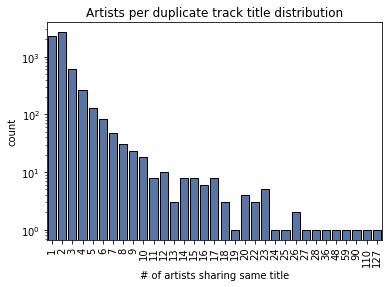

In [7082]:
artists = set()
duplicate_titles_artists = {}  # key=# duplicate tracks title, value=# artists
unique_duplicate_titles = list(check0[('track', 'title')].unique())
for title in unique_duplicate_titles:
    tmp_list = tracks[(tracks[('track', 'title')] == title)][('artist', 'id')].values
    # retrieving duplicate title's artists (if there more than one)
    key = len(set(tmp_list))
    if key > 0:
        try:
            count = duplicate_titles_artists[key]
            count += 1
            duplicate_titles_artists[key] = count
        except KeyError:
            duplicate_titles_artists[key] = 1
        artists.update(set(tmp_list))
sorted_duplicate_titles_artists = dict(OrderedDict(sorted(duplicate_titles_artists.items())))
print(sorted_duplicate_titles_artists)
print("number of artists with at least one duplicate track title", len(artists))
sns_barplot_x_and_y(duplicate_titles_artists, "# of artists sharing same title", "Artists per duplicate track title distribution", True, True)

**6.24% artists have at least one duplicate track**, while **26.94% artists share at least one track title with another artist in this same pool**. 

The majority of artists having the same track title are two and this phenomenon is slightly more accentuated than a single artist having a duplicate song. Acctually, we detected that 127 artiststs shared the same 'Untitle' track title, which uncover **missing values in the ('track', 'title') column**.

In [7083]:
missing_title_values = set()
for title in tracks[('track', 'title')].unique():
    if str(title) != "nan":
        if "Untitled" in title or "unknown" in title.lower():
            missing_title_values.add(title)
# print(missing_title_values)

In [7084]:
num_missing_title_values = 0
for title in tracks[('track', 'title')]:
    if str(title) != "nan":
        if "untitled" in title.lower() or "unknown" in title.lower():
            num_missing_title_values += 1
print("num_missing_title_values", num_missing_title_values)

num_missing_title_values 825


In [7085]:
# checking tracks with explicit missing values (NaN)
tracks[tracks[('track', 'title')].isna()][('track', 'title')]

track_id
26620    NaN
Name: (track, title), dtype: object

In [7086]:
# checking
tracks[tracks[('track', 'title')].isna()][('track', 'title')]

track_id
26620    NaN
Name: (track, title), dtype: object

<b><font color="green">RECAP:
We detect that among many shared tracks' titles, 127 artists display 'Untitled' as songs' name(<font color="red">Missing title value</font>). Other missing values in the ('track', 'title') column are '(Untitled), (Title Unknown)', 'Title Unknown', '(title unknown)', 'title unknown', '(Untitled number)', 'Untitled #number', ... and other combinations.

The total number of **missing tracks' titles is 826**, among which 1 title set to NaN, which we imputed as 'Untitled'.
</font></b>

PREPROCESSING: imputing missing ('track', 'title') with 'Unknown'

{1: 655, 2: 128, 3: 75, 4: 45, 5: 23, 6: 17, 7: 13, 8: 9, 9: 9, 10: 4, 11: 8, 12: 4, 13: 3, 14: 1, 15: 5, 16: 1, 18: 2, 19: 2, 20: 2, 21: 1, 24: 1, 25: 3, 26: 1, 27: 1, 29: 1, 36: 1, 37: 1, 38: 1, 49: 1, 56: 1, 126: 1}
number of artists with at least one duplicate track in them 1020


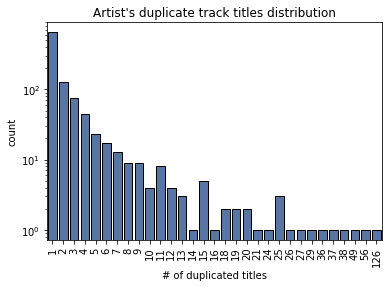

In [7087]:
artists = set()
duplicate_titles_for_same_artist = {}  # key=# duplicate tracks title, value=# artists
artist_ids = tracks[('artist', 'id')].unique()
for aid in artist_ids:
    tmp_list = tracks[(tracks[('artist', 'id')] == aid)][('track', 'title')].values
    # retrieving duplicate tracks' title in current album (if there are some)
    duplicate_titles = [item for item, count in Counter(tmp_list).items() if count > 1]
    key = len(set(duplicate_titles))
    if key > 0:
        try:
            count = duplicate_titles_for_same_artist[key]
            count += 1
            duplicate_titles_for_same_artist[key] = count
        except KeyError:
            duplicate_titles_for_same_artist[key] = 1
        artists.add(aid)
sorted_duplicate_titles_for_same_artist = dict(OrderedDict(sorted(duplicate_titles_for_same_artist.items())))
print(sorted_duplicate_titles_for_same_artist)
print("number of artists with at least one duplicate track in them", len(artists))
sns_barplot_x_and_y(sorted_duplicate_titles_for_same_artist, "# of duplicated titles", "Artist's duplicate track titles distribution", True, True)

**6.24% artists have at least one duplicate title track**. Usually the number of duplicate songs is set to two. The exception is represented by the artist having ID 15891, which has a total of 745 tracks among which 126 duplicate tracks are present, displaying a different number of listens, favorites, interest, number and date_created. 

Finally, we notice that since the number of albums having duplicate track titles in them are less numerous than artists performing duplicate track titles, we can state how among artists' duplicate songs, these songs are present in different albums (since albums and artists are consistent in the dataset, we can approximate an album with its artist and viceversa).

{2: 2249, 3: 132, 4: 29, 5: 6, 6: 1, 7: 1}
number of artists with at least one duplicate track in at least two different albums 796


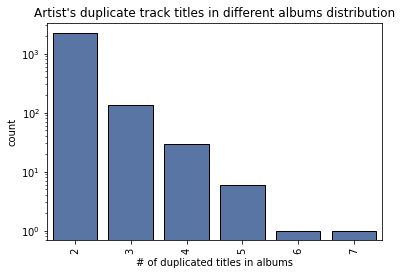

In [7088]:
artists = set()
duplicate_titles_in_different_albums = {}  # key=# duplicate tracks title, value=# artists
artist_ids = tracks[('artist', 'id')].unique()
for aid in artist_ids:
    tmp_list = tracks[(tracks[('artist', 'id')] == aid)][('track', 'title')].values
    # retrieving duplicate tracks' title in current album (if there are some)
    duplicate_titles = [item for item, count in Counter(tmp_list).items() if count > 1]
    duplicate_titles = set(duplicate_titles)
    for title in duplicate_titles:
        tmp_list = list(tracks[(tracks[('artist', 'id')] == aid) & 
                               (tracks[('album', 'id')] != -1) &
                               (tracks['track', 'title'] == title)][('album', 'id')].unique())
        if len(tmp_list) > 1:  # same title, in at least 2 different albums
            try:
                duplicate_titles_in_different_albums[len(tmp_list)] += 1
            except KeyError:
                duplicate_titles_in_different_albums[len(tmp_list)] = 1
            artists.add(aid)
sorted_duplicate_titles_in_different_albums = dict(OrderedDict(sorted(duplicate_titles_in_different_albums.items())))
print(sorted_duplicate_titles_in_different_albums)
print("number of artists with at least one duplicate track in at least two different albums", len(artists))
sns_barplot_x_and_y(sorted_duplicate_titles_in_different_albums, "# of duplicated titles in albums", "Artist's duplicate track titles in different albums distribution", True, True)

**5.40% of artists have at least a duplicate song present in two or more, different albums**.

{1: 202, 2: 11, 3: 2, 4: 2, 5: 3, 6: 3, 7: 1, 8: 1, 9: 1, 10: 1}
number of albums with at least one duplicate track in them 227


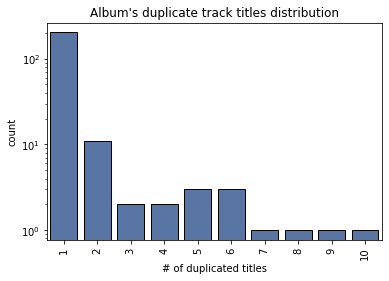

In [7089]:
duplicate_titles_in_same_album = {}  # key=# duplicate tracks title, value=# albums
album_ids = tracks[('album', 'id')].unique()
for aid in album_ids:
    if int(aid) == -1:
        continue
    tmp_list = tracks[(tracks[('album', 'id')] == aid)][('track', 'title')].values
    # retrieving duplicate tracks' title in current album (if there are some)
    duplicate_titles = [item for item, count in Counter(tmp_list).items() if count > 1]
    key = len(set(duplicate_titles))
    if key > 0:
        try:
            count = duplicate_titles_in_same_album[key]
            count += 1
            duplicate_titles_in_same_album[key] = count
        except KeyError:
            duplicate_titles_in_same_album[key] = 1
sorted_duplicate_titles_in_same_album = dict(OrderedDict(sorted(duplicate_titles_in_same_album.items())))
print(sorted_duplicate_titles_in_same_album)
print("number of albums with at least one duplicate track in them", sum(sorted_duplicate_titles_in_same_album.values()))
sns_barplot_x_and_y(sorted_duplicate_titles_in_same_album, "# of duplicated titles", "Album's duplicate track titles distribution", True, True)

**1.53% of albums have at least one duplicate track's title in them**. The most redundant album is the one with ID 20280, which has a total of 24 tracks, each one present at least one other time in it and displaying a different number of listens, favorites, interest, number and date_created.

Most of the times, songs sharing the same title in the same album are two. For the tracks sharing the same title and album id and, as a consequence, artist id, we found that they actually are the same track, repeated multiple times in the same album (this is a quite strange behaviour that needs further investigation).

In [7090]:
# tracks[tracks[('track','title')] == "La Météo"].T

In [7091]:
# tracks[tracks[('track','title')] == "Mi Corazon Zone"].T

In [7092]:
# checking if all tracks, belonging to same artist, in same album, 
# have at least one diffent value in track's columns => differen version of same track
same_album_check(True, "")

# checking if all tracks, belonging to same artist, in same album, 
# have column equal => same version of same track
same_album_check(False, ('track', 'duration'))

accordances 0
divergeces 335
('track', 'duration') accordances 160
('track', 'duration') divergeces 188


In [7093]:
# checking if all tracks, belonging to same artist, in different albums, 
# have at least one diffent value in track's columns => differen version of same track
different_album_check(True, "")

# checking if all tracks, belonging to same artist, in different albums, 
# have column equal => same version of same track
different_album_check(False, ('track', 'duration'))

accordances 0
divergeces 2418
('track', 'duration') accordances 1472
('track', 'duration') divergeces 975


It seems the **tracks sharing the same album id, artist id and track title** differ only for track's metadata:
- date_created;
- duration;
- comments;
- favorites;
- interest;
- listens;
- number.

In particulr having a different track number means that they belong to the same album, but in it they occupy a different track position. For this reason we can consider them as not being duplicates. <span style="background-color: #FFFF00"> Actually we can hypotize that duplicate songs, having the same duration, are part of different versions due to featurings with other artists (even if not explicitly expressed in the artist metadata), since tracks' base remains the same. On the other part, duplicate tracks changing their duration in the same album are part of track's base contraction/extension** and duplicate tracks changing bit_rate/genre_top are part of track's base remix/bmp modification</span>. 

Also, <span style="background-color: #FFFF00"> tracks sharing the artist id and track title, but present in different album ids aren't duplicates</span>, since the reasoning is the same.  

<h1> DataFrame's numerical statistics</h1>

In [7094]:
tracks.describe().T

count           mean            std         min  \
album  comments   106574.0       0.394946       2.268915   -1.000000   
       favorites  106574.0       1.286927       3.133035   -1.000000   
       id         106574.0   12826.933914    6290.261805   -1.000000   
       listens    106574.0   32120.306182  147853.178406   -1.000000   
       tracks     106574.0      19.721452      39.943673   -1.000000   
artist comments   106574.0       1.894702       6.297679   -1.000000   
       favorites  106574.0      30.041915     100.511408   -1.000000   
       id         106574.0   12036.770404    6881.420867    1.000000   
       latitude    44544.0      39.901626      18.240860  -45.878760   
       longitude   44544.0     -38.668642      65.237220 -157.526855   
track  bit_rate   106574.0  263274.695048   67623.443584   -1.000000   
       comments   106574.0       0.031621       0.321993    0.000000   
       duration   106574.0     277.849100     305.518553    0.000000   
       favorites  106574.0       3.182521      13.513820    0.000000   
       interest   106574.0    3541.310207   19017.430891    2.000000   
       listens    106574.0    2329.353548    8028.070647    0.000000   
       number     106574.0       8.260945      15.243271    0.000000   

                            25%            50%           75%           max  
album  comments        0.000000       0.000000       0.00000  5.300000e+01  
       favorites       0.000000       0.000000       1.00000  6.100000e+01  
       id           7793.000000   13374.000000   18203.00000  2.294000e+04  
       listens      3361.000000    8982.000000   23635.00000  3.564243e+06  
       tracks          7.000000      11.000000      17.00000  6.520000e+02  
artist comments        0.000000       0.000000       1.00000  7.900000e+01  
       favorites       1.000000       5.000000      16.00000  9.630000e+02  
       id           6443.000000   12029.500000   18011.00000  2.435700e+04  
       latitude       39.271398      41.387917      48.85693  6.728601e+01  
       longitude     -79.997459     -73.554431       4.35171  1.752770e+02  
track  bit_rate   192000.000000  299914.000000  320000.00000  4.480000e+05  
       comments        0.000000       0.000000       0.00000  3.700000e+01  
       duration      149.000000     216.000000     305.00000  1.835000e+04  
       favorites       0.000000       1.000000       3.00000  1.482000e+03  
       interest      599.000000    1314.000000    3059.00000  3.293557e+06  
       listens       292.000000     764.000000    2018.00000  5.432520e+05  
       number          2.000000       5.000000       9.00000  2.550000e+02

In [7095]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_tracks = tracks.select_dtypes(include=numerics)
numeric_tracks.shape

(106574, 17)

In [7096]:
for column_name in numeric_tracks.columns:
    minus_one_values = sum(numeric_tracks[column_name] == -1)
    if minus_one_values > 0:
        print(minus_one_values, column_name)

3529 ('album', 'comments')
3529 ('album', 'favorites')
1025 ('album', 'id')
3529 ('album', 'listens')
3529 ('album', 'tracks')
856 ('artist', 'comments')
856 ('artist', 'favorites')
105 ('track', 'bit_rate')


Regarding the numerical features, the dataset has:
- **62030 NaN records for ('artist', 'latitude')**;
- **62030 NaN records for ('artist', 'longitude')**.

In the Data Cleaning stage we will descarded the highly missing record columns.

We can notice some more **subtle missing values**, expressed as **-1**:
- 3529 ('album', 'comments');
- 3529 ('album', 'favorites');
- 1025 ('album', 'id');
- 3529 ('album', 'listens');
- 3529 ('album', 'tracks');
- 856 ('artist', 'comments');
- 856 ('artist', 'favorites');
- 105 ('track', 'bit_rate').

<font color="fuchsia"><h2>Numerical attributes' contrains</h2></font>

<font color="fuchsia"><h6>('album', 'tracks') constrain</h6> </font>
Constrains:

1. for each ('album', 'id), ('album', 'tracks') must be equal or greater tracks' belonging to album in the sataset (excluding missing ID albums and missing ('album', 'tracks') albums).

In [7097]:
# checking if ('album', 'tracks') is consistent with ('album', 'id')'s frequency in the dataset
# [SHORT VERSION]
lower_frequency_albums = set()
equal_frequency_albums = set()
zero_tracks_album = set()
inconsistent_tracks_albums = set()
for aid in tracks[('album', 'id')].unique():
    if int(aid) == -1:
        count += 1
        continue
    tmp_df = tracks[(tracks[('album', 'id')] == aid)]
    album_tracks = tmp_df[('album', 'tracks')].values[0]
    tracks_frequency = tmp_df.shape[0]
    if album_tracks == -1:
        count += 1
        continue
    else:
        if album_tracks == 0:
            zero_tracks_album.add(aid)
        if tracks_frequency > album_tracks:
            inconsistent_tracks_albums.add(aid)
        elif tracks_frequency == album_tracks:
            equal_frequency_albums.add(aid)
        else:
            lower_frequency_albums.add(aid)
           
print("---------------------------------------------------OK------------------------------------------")
print("lower_frequency_albums", len(lower_frequency_albums))
print("equal_frequency_albums", len(equal_frequency_albums))
print("----------------------------------------Inconsistency------------------------------------------")
print("zero_tracks_album", len(zero_tracks_album))
tmp1 = inconsistent_tracks_albums.difference(zero_tracks_album)
print("not zero_tracks_album inconsistent", len(tmp1))
print("inconsistent_tracks_albums", len(inconsistent_tracks_albums))
tmp2 = (tracks[(tracks[('album', 'id')].isin(list(inconsistent_tracks_albums)))][('album', 'type')].unique())
print("inconsistent_tracks_albums album types", tmp2)

---------------------------------------------------OK------------------------------------------
lower_frequency_albums 3190
equal_frequency_albums 11004
----------------------------------------Inconsistency------------------------------------------
zero_tracks_album 148
not zero_tracks_album inconsistent 53
inconsistent_tracks_albums 201
inconsistent_tracks_albums album types ['Album' 'Single Tracks' 'Radio Program' 'Live Performance' nan]


In [7098]:
# missing ('album', 'tracks') values
n_miss = tracks[(tracks[('album', 'id')].isin(inconsistent_tracks_albums))].shape[0] 
perc = n_miss / tracks.shape[0] * 100
if n_miss > 0:
    print( '%s rows, %.1f%% of NaN rows for %s ' % (n_miss, perc,  ('album', 'tracks')))

936 rows, 0.9% of NaN rows for ('album', 'tracks') 


**21.48% of albums have a number of tracks lower than total number of album's tracks**, **74.09% of albums have all tracks present in the dataset** while **1.35% of albums have a number of tracks greater than what thy state in ('album', 'tracks')**, 0.99% of times due to ('album', 'tracks') set to zero. We can consider this value as being a missing value sign, but the other 53 albums still aren't explained (in addition we surely have ('album', 'tracks')=-1 cases being missing values).

PREPROCESSING: for consistency reasons and for not modifying the 53 ('album', 'tracks') column, solving  tracks having a frequency greater than the actual ('album', 'tracks') (0.9% of rows), we discarded ('album', 'tracks') column. We get rid of ('track', 'number column'), too, being moderate correlated with it (+0.53) and incosistent as well, as next follows.

<font color="fuchsia"><h6>('track', 'number') constrains</h6></font>
Constrains:
1. in each ('album', 'id') each ('track', 'number') must be univocal (with the exception of repteated 0s, which correspond to missing values);
2. in each ('album', 'id') the greatest ('track', 'number') must be at most equal to ('album', 'tracks') (with the exception of ('album', 'tracks')=-1, which corrispond to missing values).

In [7099]:
# checking if ('track', 'number') are univocal
inconsistent_track_numbers = set()
for aid in tracks[('album', 'id')].unique():
    if int(aid) == -1:
        continue
    numbers = tracks[(tracks[('album', 'id')] == aid)][('track', 'number')]
    duplicate_numbers = [item for item, count in Counter(numbers).items() if count > 1]
    if len(duplicate_numbers) > 0:
        if len(duplicate_numbers) == 1 and duplicate_numbers[0] == 0:
            continue
        inconsistent_track_numbers.add(aid)
print("inconsistent_track_numbers", len(inconsistent_track_numbers))
tmp = (tracks[(tracks[('album', 'id')].isin(list(inconsistent_track_numbers)))][('album', 'type')].unique())
print("inconsistent_track_numbers album types", tmp)

inconsistent_track_numbers 154
inconsistent_track_numbers album types ['Album' 'Single Tracks' 'Radio Program' 'Live Performance' nan]


In [7100]:
# checking if greatest ('track', 'number') <= ('album', 'tracks')
inconsistent_greatest_track_numbers = set()
for aid in tracks[('album', 'id')].unique():
    if int(aid) == -1:
        continue
    tmp_df = tracks[(tracks[('album', 'id')] == aid)]
    album_tracks = tmp_df[('album', 'tracks')].values[0]
    greteast_track_number = tmp_df[('track', 'number')].max()
    if album_tracks == -1 or greteast_track_number == 0:
        continue
    else:
        if album_tracks == 0:
            zero_album_track.add(aid)
        if greteast_track_number > album_tracks:
            inconsistent_greatest_track_numbers.add(aid)
print("inconsistent_greatest_track_numbers", len(inconsistent_greatest_track_numbers))
tmp = (tracks[(tracks[('album', 'id')].isin(list(inconsistent_greatest_track_numbers)))][('album', 'type')].unique())
print("inconsistent_greatest_track_numbers album types", tmp)

inconsistent_greatest_track_numbers 1206
inconsistent_greatest_track_numbers album types ['Album' 'Single Tracks' 'Live Performance' 'Radio Program' nan]


Here, we find attestation that ('track', 'number') is a biased feature, since it has **1.04% albums having non univocal track numbers and 8.12% albums having greatest track number greter than album's total number of tracks (album's number counting start to 1).**

Example1: album ID=11776 have ('album', 'tracks')= 3 and track ID=65360 having ('track', 'number')=1,
track ID=65361 having ('track', 'number')=3, track ID=65362 having ('track', 'number')=3.

Example2:  album ID=2 have ('album', 'tracks')= 10 and greatest ('track', 'number')=11, corresponding to track ID=3960.

<font color="fuchsia"><h6>('album', 'listens') constrains</h6></font>
Constrains:
1. ('album', 'listens') >= sum{('track', 'listens')}

TODO: not sure if this constrain must have this semantic (probably each track's playcount is counted among different album's version, while the current album present in the database shows only the metadata of tracks it officially had when collected).

In [7101]:
def check_constrained_columns(column_name1, column_name2):
    id_flag = 'id'
    if column_name1[0] == 'track':
        id_flag = 'title'
    lower = tracks[((tracks[column_name1]) < (tracks[column_name2]))]
    greater = tracks[((tracks[column_name1]) > (tracks[column_name2]))]
    
    l = lower.shape[0]
    g = greater.shape[0]
    l_types = dict(Counter(lower[('album', 'type')].values))
    g_types = dict(Counter(greater[('album', 'type')].values))
    print("%s < %s=%s" % (column_name1, column_name2, l))
    print("%s > %s=%s" % (column_name1, column_name2, g))
    print("< album types=%s" % (str(l_types)))
    print("> album types=%s" % (str(g_types)))
    
    return lower, greater

In [7102]:
# retrieve consistent ('album', 'tracks')
count = 0
consistent_listens_sum_albums_ids = set()
for aid in tracks[('album', 'id')].unique():
    if int(aid) == -1:
        continue
    tmp_df = tracks[tracks[('album', 'id')] == aid]
    to_compare = tmp_df[('album', 'listens')].values[0]
    tmp_sum = tmp_df[('track', 'listens')].sum()
    if to_compare >= tmp_sum:
        count += tmp_df.shape[0]
        consistent_listens_sum_albums_ids.add(aid)
print("consistent sum{('track', 'listens')} with ('album', 'listens')", count)
print("consistent_listens_sum_albums_ids", len(consistent_listens_sum_albums_ids))
types = Counter(tracks[tracks[('album', 'id')].isin(list(consistent_listens_sum_albums_ids))][('album', 'type')].values)
print("consistent_listens_sum_albums_ids' type", types)

consistent sum{('track', 'listens')} with ('album', 'listens') 15750
consistent_listens_sum_albums_ids 2973
consistent_listens_sum_albums_ids' type Counter({'Album': 13696, nan: 707, 'Live Performance': 676, 'Radio Program': 473, 'Single Tracks': 198})


In [7103]:
# consistent ('album', 'tracks') lookup
num_tracks_per_consisten_albums = {}
for aid in consistent_listens_sum_albums_ids:
    num_tracks = tracks[tracks[('album', 'id')] == aid].shape[0]
    try:
        tmp_list = num_tracks_per_consisten_albums[num_tracks]
        tmp_list.append(aid)
        num_tracks_per_consisten_albums[num_tracks] = tmp_list
    except KeyError:
        num_tracks_per_consisten_albums[num_tracks] = [aid]
        
tmp_dict = {}
for key, value in num_tracks_per_consisten_albums.items():
    tmp_dict[key] = len(value)
print("num_tracks_per_consisten_albums", dict(OrderedDict(sorted(tmp_dict.items()))))

num_tracks_per_consisten_albums {1: 1214, 2: 188, 3: 150, 4: 198, 5: 191, 6: 164, 7: 127, 8: 119, 9: 98, 10: 116, 11: 76, 12: 83, 13: 38, 14: 36, 15: 35, 16: 19, 17: 18, 18: 13, 19: 7, 20: 8, 21: 5, 22: 10, 23: 6, 24: 5, 25: 5, 26: 5, 27: 4, 28: 2, 29: 4, 32: 2, 34: 2, 35: 2, 36: 2, 37: 1, 43: 1, 44: 1, 45: 4, 47: 2, 49: 1, 50: 2, 51: 1, 55: 1, 57: 1, 60: 1, 69: 1, 82: 1, 92: 1, 98: 1, 101: 1}


**20.02% of albums have ('album', 'listens') >= sum{('track', 'listens')}**. The 6.66% of these consistent albums are made up by a single song (so in these cases the equivalence sign is true in the constain equation). Plus, they belong to all album types, excluded Contest. However, 59.17% of consistent albums albums have a number of tracks greater than two and whose listens is greater or equal to total track listen sum.

In [7104]:
lower, greater = check_constrained_columns(('album', 'listens'), ('track', 'listens'))
lower = list(lower[('album', 'id')].unique())
greater = list(greater[('album', 'id')].unique())

('album', 'listens') < ('track', 'listens')=4981
('album', 'listens') > ('track', 'listens')=100616
< album types={'Album': 1078, nan: 3574, 'Single Tracks': 90, 'Live Performance': 190, 'Radio Program': 49}
> album types={'Album': 85783, 'Single Tracks': 752, 'Live Performance': 4725, 'Radio Program': 6461, nan: 2881, 'Contest': 14}


PREPROCESSING: We expected that ('album', 'listens') gathered together their dataset's tracks' listens sum, adding to the counting also the tracks not present in the dataset. However, we actually found out than only 20.02%  of albums shared this characteristic.

This means that ('album', 'listens') and ('track', 'listens') assume a different semantic, in the sense they both are releated to album's and track's popularity, but the two likeness aren't correlated. In most cases, ('album', 'listens') is greater or equal to a single ('track', 'listens'), but exist 4.67% of tracks representing an excpetion and having a listen number greater than their actual album's listen number.

For the reasons mentioned above, we will disregard ('album', 'listens'), prefering to use some other feature to detect albums' audience satisfaction.

<h6>Checking ('album', 'comments'), ('artist', 'comments') and ('track', 'comments') asymmetry</h6>

In [7105]:
count = 0
for aid in tracks[('artist', 'id')].unique():
    to_compare = tracks[tracks[('artist', 'id')] == aid][('artist', 'comments')].values[0]
    tmp_sum = 0
    for aid2 in tracks[tracks[('artist', 'id')] == aid][('album', 'id')].unique():
        if int(aid2) == -1:
            continue
        tmp_sum += tracks[tracks[('album', 'id')] == aid2][('album', 'comments')].values[0]
    if to_compare >= tmp_sum:
        count += 1
count

12508

In [7106]:
count = 0
for aid in tracks[('album', 'id')].unique():
    if int(aid) == -1:
        continue
    to_compare = tracks[tracks[('album', 'id')] == aid][('album', 'comments')].values[0]
    tmp_sum = tracks[tracks[('album', 'id')] == aid][('track', 'comments')].sum()
    if to_compare >= tmp_sum:
        count += 1
count

13341

76.54% of artists and 89.82% of albums have a number of comments greater than their relative albums' and tracks' comments. This means that if usually an artist is popular, he has received a greater number of reviews than its albums. Since this reasoning is true for albums and tracks, he has receive a greater number of comments than its tracks, too.

So we can state that the comments features are in the majority of cases decrementantally among artists, albums and tracks, respectivelly. 

PREPROCESSING: However, since a comment can have a positive or negative meaning, we prefer to disregard comment features as audiance' satisfaction towars an album/artist/track, since sometimes this can be misleading. Better take into account the favorites features, which always convay a positive reference. 

<h6>Checking ('album', 'favorites'), ('artist', 'favorites') and ('track', 'favorites') asymmetry</h6>

In [7107]:
count = 0
for aid in tracks[('artist', 'id')].unique():
    to_compare = tracks[tracks[('artist', 'id')] == aid][('artist', 'favorites')].values[0]
    tmp_sum = 0
    for aid2 in tracks[tracks[('artist', 'id')] == aid][('album', 'id')].unique():
        if int(aid2) == -1:
            continue
        tmp_sum += tracks[tracks[('album', 'id')] == aid2][('album', 'favorites')].values[0]
    if to_compare >= tmp_sum:
        count += 1
count

10496

In [7108]:
count = 0
for aid in tracks[('album', 'id')].unique():
    if int(aid) == -1:
        continue
    to_compare = tracks[tracks[('album', 'id')] == aid][('album', 'favorites')].values[0]
    tmp_sum = tracks[tracks[('album', 'id')] == aid][('track', 'favorites')].sum()
    if to_compare >= tmp_sum:
        count += 1
count

1831

64.23% of albums and 11.20% of albums have a number of favorites greater than their relative albums' and tracks' favorites. This underlines how the favorites' features are quite asymmetric/not-related between albums, artists and tracks (we detected only than in half cases, artists received a greater number of favorites, but is quite logic).

<b><font color="green">
RECAP: To detect audience's satisfaction we will consider ('album', 'favorites'), ('artist', 'favorites'), ('track', 'listens') and ('track', 'favorites').
Since albums', artists' and tracks' favorites features can be asymmetric, these three columns don't have to complay to any constain. In addition, we disregarded all comment features due to the double valence (positive or negative) that it conveys and ('album', 'listens'), ('album', 'tracks') and ('track', 'number') as bing biased.
</font></b>

<h3>Numerical features -1 insight (among which many album features) </h3>

In [7109]:
def check_consistence_of_minus_one_attribute(minus_one_colum_name):
    print(minus_one_colum_name)
    if minus_one_colum_name[0] == "track":
        imputation_dict = {}  # key=idx, value=[indeces]
        tmp_df = tracks[tracks[minus_one_colum_name] == -1][[('artist', 'id'), ('track', 'title'), 
                                                                                     ('track', 'genre_top')]]
        for row, idx in zip(tmp_df.itertuples(), tmp_df.index):
            artist = row[1]
            title = row[2]
            genre_top = row[3]
            if pd.isnull(genre_top):
                tmp_df = tracks[(tracks[('artist', 'id')] == artist) & 
                                (tracks[('track', 'title')] == title) &
                                (tracks[('track', 'genre_top')].isna()) &
                                (tracks[minus_one_colum_name] != -1)]
            else:
                tmp_df = tracks[(tracks[('artist', 'id')] == artist) & 
                          (tracks[('track', 'title')] == title) &
                          (tracks[('track', 'genre_top')] == genre_top) &
                          (tracks[minus_one_colum_name] != -1)]

            values = list(tmp_df[minus_one_colum_name].dropna().unique())
            if len(values) > 0:
                # print(idx, "imputation candidate rows=%s" % str(list(tmp_df.index.values)))
                imputation_dict[idx] = list(tmp_df.index.values)
        return imputation_dict
    else:
        id_column = (minus_one_colum_name[0], 'id')
        ids_list = tracks[tracks[minus_one_colum_name] == -1][id_column].dropna().unique()
        for aid in ids_list:
            tmp_df = tracks[(tracks[id_column] == aid) & 
                            (tracks[minus_one_colum_name] != -1)]
            values = list(tmp_df[minus_one_colum_name].dropna().unique())
            if len(values) > 0:
                print(aid, "imputation candidate rows=%s" % str(list(tmp_df.index.values)))

In [7110]:
minus_ones_columns = [('album', 'comments'), ('album', 'favorites'), ('album', 'id'), ('album', 'listens'),
                      ('album', 'tracks'), ('artist', 'comments'), ('artist', 'favorites'), 
                      ('track', 'bit_rate')]
bit_rate_imputation_dict = {}  # key=idx, value=[indeces]
for column_name in minus_ones_columns:
    bit_rate_imputation_dict = check_consistence_of_minus_one_attribute(column_name)
    
# checking
for key, value in bit_rate_imputation_dict.items():
    genre_top = tracks.at[key, ('track', 'genre_top')]
    if pd.isnull(genre_top):
        for v in value:
            if pd.isnull(tracks.at[v, ('track', 'genre_top')]) == False:
                print("index %s divergent genre_top with index %s" % (v, key))
                sys.exit(-1)
    else:
        for v in value:
            if tracks.at[v, ('track', 'genre_top')] != genre_top:
                print("index %s divergent genre_top with index %s" % (v, key))
                sys.exit(-1)
                
print("\n('track', 'bit_rate')'s solved missing values=%s" % len(bit_rate_imputation_dict))

('album', 'comments')
('album', 'favorites')
('album', 'id')
('album', 'listens')
('album', 'tracks')
('artist', 'comments')
('artist', 'favorites')
('track', 'bit_rate')

('track', 'bit_rate')'s solved missing values=18


Investigating, we found out that each album and artist having a -1 as numeric missing value is unique in its kind (it doesn't figure in the dataset with the same id and a value different than -1 in the missing column).

PREPROCESSING: <font color="red">Regarding tracks with missing bit_rates, 18 out of 105 tracks could be imputed using the same bit rate as tracks belonging to the same artist and having the same title. However, we wait for this small imputation, since to correctly impute missing bit_rate the tracks have to share also the same genre_top, but in our 18 cases, all tracks and imputable bit_rate tracks have genre_top set to NaN, so we better wait to avoid introducing bias. </font>

In [7111]:
missing_album_indeces = {} # key=column_name, value=[indeces]
for column_name in minus_ones_columns:
    if column_name[0] == 'album':
        missing_album_indeces[column_name] = list(tracks[tracks[column_name] == -1].index.values)

keys = list(missing_album_indeces.keys())
values = list(missing_album_indeces.values())
for i in range(0, len(missing_album_indeces) - 1):
    for j in range(i + 1, len(missing_album_indeces)):
        i_indeces = values[i]
        j_indeces = values[j]
        if len(i_indeces) >=  len(j_indeces):
            different_indeces = set(i_indeces).difference(set(j_indeces))
            if len(different_indeces) > 0:
                print(keys[i], keys[j], len(different_indeces))
        else:
            different_indeces = set(j_indeces).difference(set(i_indeces))
            if len(different_indeces) > 0:
                print(keys[j], keys[i], len(different_indeces))

('album', 'comments') ('album', 'id') 2504
('album', 'favorites') ('album', 'id') 2504
('album', 'listens') ('album', 'id') 2504
('album', 'tracks') ('album', 'id') 2504


In [7112]:
check1 = list(set(missing_album_indeces[('album', 'comments')]).difference( \
                                                set(missing_album_indeces[('album', 'favorites')])))
check2 = list(set(missing_album_indeces[('album', 'comments')]).difference(\
                                                    set(missing_album_indeces[('album', 'listens')])))
check3 = list(set(missing_album_indeces[('album', 'comments')]).difference(\
                                                        set(missing_album_indeces[('album', 'tracks')])))
check4 = list(set(missing_album_indeces[('album', 'favorites')]).difference(\
                                                        set(missing_album_indeces[('album', 'listens')])))
check5 = list(set(missing_album_indeces[('album', 'favorites')]).difference(\
                                                            set(missing_album_indeces[('album', 'tracks')])))
check6 = list(set(missing_album_indeces[('album', 'listens')]).difference(\
                                                            set(missing_album_indeces[('album', 'tracks')])))
unknown_solely_album_info_idx = set(missing_album_indeces[('album', 'comments')]).difference(\
                            set(tracks[tracks[('album', 'id')] == -1].index.values))
if len(check1) != 0 or len(check2) != 0 or len(check3) != 0 or \
                len(check4) != 0 or len(check5) != 0 or len(check6) != 0:
    print("-1 mismatch among albums' comments, favorites, listens and tracks")
else:
    print("-1 MATCH  among all albums' comments, favorites, listens and tracks")
    print("unknown_solely_album_info_idx", len(unknown_solely_album_info_idx))

-1 MATCH  among all albums' comments, favorites, listens and tracks
unknown_solely_album_info_idx 2504


In [7113]:
unknown_album_idx = tracks[(tracks[('album', 'comments')] == -1) &
       (tracks[('album', 'favorites')] == -1) &
       (tracks[('album', 'id')] == -1) &
       (tracks[('album', 'listens')] == -1) &
       (tracks[('album', 'tracks')] == -1)].index
if len(unknown_album_idx) != tracks[tracks[('album', 'id')] == -1].shape[0]:
    print("-1 mismatch among albums' ID, comments, favorites, listens and tracks")
else:
    print("-1 MATCH among albums' ID, comments, favorites, listens and tracks")
    print("unknown_album_idx", len(unknown_album_idx))

-1 MATCH among albums' ID, comments, favorites, listens and tracks
unknown_album_idx 1025


In [7114]:
def check_if_all_missing_album_info_are_the_same(idx_list, missing_album_id_flag):
    nan_album_columns = ['date_created', 'date_released', 'engineer', 'information', 'producer', 'type']  
    num_album_columns = ['comments', 'favorites', 'listens', 'tracks']  
    empty_list_album_columns = ['tags']
    for idx in idx_list:
        for column_name in tracks.columns:
            value = tracks.at[idx, column_name]
            if column_name[0] == 'album':
                if column_name[1] in nan_album_columns:
                    if pd.isnull(value) == False:
                        print(idx, column_name)
                elif column_name[1] in num_album_columns:
                    if value != -1:
                        print(idx, column_name)
                elif column_name[1] in empty_list_album_columns:
                    if value != "[]":
                         print(idx, column_name)
                else:
                    if missing_album_id_flag == False:
                        if column_name[1] == 'id':
                            if value == -1:
                                print(idx, column_name)
                        if column_name[1] == 'title':
                            if pd.isnull(value):
                                print(idx, column_name)
                    else:
                        if column_name[1] == 'id':
                            if value != -1:
                                print(idx, column_name)
                        if column_name[1] == 'title':
                            if pd.isnull(value) == False:
                                print(idx, column_name)
                                
check_if_all_missing_album_info_are_the_same(unknown_solely_album_info_idx, False)
check_if_all_missing_album_info_are_the_same(unknown_album_idx, True)

<span style="background-color: #FFFF00"> 1025 tracks have all ('album', 'id'), ('album', 'comments'), ('album', 'favorites'), ('album', 'listens'), ('album', 'tracks') set to -1, while there are 2.504 tracks having an album ID, but missing all the other 4 album information.</span>

Missing ID albums 2 ideas:
1. check if the track with missing ID album belongs to given artist's other album and so introducing it in this album, by replacing album id and album metadata in the missing row. This action is lawful since in the dataset are originally present artists having more version of the same song in the same album and since ('album', 'tracks') and ('album', 'listens') aren't related to ('track', 'number') and sum{('track', 'listens')} in the dataset, too. <font color="red">N.B. More than one album can be matched, so we will choose the one having a type different than "Contest" or "Single Tracks" (since we will remove them from the dataset to be more consistent) and if still exists ties, we will chose the most near in time album according to ('track', 'date_created') [even if it doesn't exist a consistent of same year, month and day creation among same title tracks in same album]. </font>;
2. if the track with missing ID album doesn't belong to given artist's other album (doesn't exist an artist's track sharing the same title), we proceed by crafting a new album ID, incrementally increasing the maximum album ID (22,940) present in the dataset.

In [7115]:
def get_year_month_day(datetime_str):
    tmp_list = datetime_str.split("-")
    year = tmp_list[0]
    month = tmp_list[1]
    day = tmp_list[2].split(" ")[0]
    return int(year), int(month), int(day)

In [7116]:
# checking if tracks present in same album and having the same title
# were created in same year, month and day (the answer is NO)
for aid in tracks[('album', 'id')].unique():
    if int(aid) == -1:
        continue
    tmp_df = tracks[(tracks[('artist', 'id')] == aid)]
    
    tmp_titles = tmp_df[('track', 'title')].values
    duplicate_titles = [item for item, count in Counter(tmp_titles).items() if count > 1]
    duplicate_titles = set(duplicate_titles)
    tmp_date_created = tmp_df[('track', 'date_created')].values
    for i in range(0, len(tmp_titles) - 1):
        t1 = tmp_titles[i]
        if t1 not in duplicate_titles:
            continue
        y1, m1, d1 = get_year_month_day(tmp_date_created[i])
        for j in range(i + 1, len(tmp_titles)):
            t2 = tmp_titles[j]
            y2, m2, d2 = get_year_month_day(tmp_date_created[j])
            if t1 == t2:
                if y1!=y2 or m1!=m2 or d1!=d2:
                    # print(aid, t1, tmp_date_created[i], tmp_date_created[j])
                    pass

In [7117]:
# check if among missing album's ids, exist tracks, belonging to the same artist
# and having the same title. If exist, we can impute tracks missing album id, 
# with the matching album infos (N.B. more than one album can be matched)
album_columns = [column_name for column_name in tracks.columns if column_name[0] == 'album']

replaced_album_id_indeces = []
max_album_id = tracks[('album', 'id')].max()
print("max_album_id", max_album_id)
incr_id = max_album_id
for idx in unknown_album_idx:
    replace_flag = False
    artist = tracks.at[idx, ('artist', 'id')]
    title = tracks.at[idx, ('track', 'title')]
    tmp_df = tracks[(tracks[('artist', 'id')] == artist) & 
                    (tracks[('track', 'title')] == title) & 
                    (tracks[('album', 'id')] != -1)]
    
    shape = tmp_df.shape[0]
    if shape > 0:  # exist a duplicate track
        index = 0
        types = list(tmp_df[('album', 'type')].unique())
        t_creation = tracks.at[idx, ('track', 'date_created')]
        t_y, t_m, t_d = get_year_month_day(t_creation)
        tracks_creation = tmp_df[('track', 'date_created')].values
        aids = tmp_df[('album', 'id')].values
        
        if "Contest" in types or "Single Tracks" in types: 
            continue  # track imputed later with consisten album type 
           
        if shape == 1:
            replace_flag = True
        elif shape == 2:
            # solve tie
            y1, m1, d1 =  get_year_month_day(tracks_creation[0])
            y2, m2, d2 =   get_year_month_day(tracks_creation[1])
            if t_y == y1 and t_m == m1 and t_d == d1:
                replace_flag = True
            elif t_y == y2 and t_m == m2 and t_d == d2:
                index = 1
                replace_flag = True
            else:
                # choosing arbitrarly to assign track to first album
                # since ('track', 'date_created') is unconstrained
                replace_flag = True
        else:
            print("Not contemplated album match=%s yet" % shape)
            sys.exit(-1)
        if replace_flag:
            replaced_album_id_indeces.append(idx)
            for column_name in album_columns:
                tracks.at[idx, column_name] = tmp_df[column_name].values[index]   
    else:
        # incrementally replace missing album ID 
        incr_id += 1
        tracks.at[idx, ('album', 'id')] = incr_id

# checking
print("('album', 'id')", tracks[tracks[('album', 'id')] == -1].shape[0])
print("replaced_album_id_indeces", len(replaced_album_id_indeces))

max_album_id 22940
('album', 'id') 0
replaced_album_id_indeces 105


**10.24% missing album ids were imputed using existing album ids present in the dataset, while the remaining part was imputed sequentially incrementing greatest album ID present in the dataset.**

<h3>Checking other numerical missing values</h3>

In [7118]:
def print_perc_missing_values(df):
    for column_name in df.columns:
        # count number of rows with missing values
        data = df[column_name]
        n_miss = data.isnull().sum()
        perc = n_miss / df.shape[0] * 100
        if n_miss > 0:
            print( '%s, Missing: %d (%.1f%% of rows) ' % (column_name, n_miss, perc))

In [7119]:
print_perc_missing_values(numeric_tracks)

('artist', 'latitude'), Missing: 62030 (58.2% of rows) 
('artist', 'longitude'), Missing: 62030 (58.2% of rows) 


In [7120]:
len(tracks[tracks[('artist', 'location')].isna()][('artist', 'id')].unique())

10308

In [7121]:
len(tracks[tracks[('artist', 'latitude')].isna()][('artist', 'id')].unique())

12505

In [7122]:
# longitude is symmetric 
geo_missing_location = tracks[tracks[('artist', 'latitude')].isna()][('artist', 'location')].dropna().unique()
print("locations' missing latitude&longitude", len(geo_missing_location))

locations' missing latitude&longitude 1045


In [7123]:
tmp_map = {}
for loc in geo_missing_location:
    tmp_df = tracks[tracks[('artist', 'location')] == loc][[('artist', 'latitude'), ('artist', 'longitude')]]
    if tmp_df.shape[0] > 1:
        for row in tmp_df.itertuples():
            if str(row[1]) != "nan" and str(row[2]) != "nan":
                tmp_map[str(loc)] = (row[1], row[2])
                break
print("imputable locations' latitude&longitude", len(tmp_map))

imputable locations' latitude&longitude 324


In [7124]:
geo_imputed_rows = 0
for loc in tmp_map.keys():
    tmp = tracks[(tracks[('artist', 'location')] == loc) & (tracks[('artist', 'latitude')].isna())].shape[0]
    geo_imputed_rows += tmp
print("missing values after imputation", "(%.1f%% of rows)" % ((62030 - geo_imputed_rows) / tracks.shape[0] * 100))

missing values after imputation (43.4% of rows)


Among the 58.2% missing latitudes/longitudes, we can decrease the number of missing values to 43.4% , but not actually remove all the missing values. We can try to guess the missing latitude and longitude by cleaning and imputing ('artist', 'location').

PREPROCESSING: Since 63.08% of artists have a missing ('artist', 'location') and 76.53% of artists have missing ('artist', 'latitude') and simmetrically ('artist', 'longitude'), we prefer to disreagrd these three columns.

<font color="light blue"><h6>Cleaning ('artist', 'location') column </h6></font>

('artist', 'location') has 2330 unique values, but they are highly uneven in the namings. For this reason, after a firts attemp to clean them and taking into account that for a classification genre maybe is more important the language than interpreter's location, we stop the cleaning phase and simply **won't use ('artist', 'location'), ('artist', 'latitude') and ('artist', 'longitude) columns**.

In [7125]:
df_copy = tracks.copy()
location_column = df_copy[('artist', 'location')].values
print("unique locations", len(set(location_column)))

unique locations 2330


In [7126]:
countries = pd.read_csv('../../data/fma_metadata/countries.csv', sep=",")
countries.shape

(249, 2)

In [7127]:
def clean_code(code):
    code =  code.replace(" ", "")
    code =  code.replace(".", "")
    code =  code.replace("\n", "")
    code =  code.upper()
    return code

In [7128]:
codes = {'USA': "United States", 
         'UK': "United Kingdom", 
         'NYC': "United States",
         'NY': "United States", 
         'OR': "United States",
         'OH': "United States",
         'NJ': "United States", 
         'MI': "United States",
         'VT': "United States",
         'TX': "United States",
         'DC': "United States",
         'WI': "United States",
         'CT': "United States",
         'RI': "United States",
         'WA': "United States",
         'FL': "United States",
         'OK': "United States",
         'KS': "United States",
         'NH': "United States",
         'NV': "United States",
         'BC': "United States",
         'ND': "United States",
         'OW': "Canada",
         'ON': "Canada",
         'QC': "Canada",
         'PQ': "Canada",
         'CAN': "Canada",
         'ONT': "Canada",
         'NSW': "Australia",
         'DF': "Mexico", 
         'GO': "Brazil"
        }
names = {"Alaska": "United States",
         "Hawaii": "United States",
         "Copenhagen": "Denmark",
         "Aarhus": "Denmark",
         "Memphis": "United States",
         "Asheville": "United States",
         "Nashville": "United States",
         "Queens":  "United States",
         "Brooklyn":  "United States",
         "Colombia ":  "United States",
         "NewJersey":  "United States",
         "WashingtonDc":  "United States",
         "Washington":  "United States",
         "Toronto": "Canada",
         "Montreal": "Canada",
         "Podolsk": "Russia",
         "Jersey City ":  "United States",
         "Jersey City":  "United States",
         "Union City":  "United States",
         "Baltimore": "United States",
         "San Francisco": "United States",
         "Boston":  "United States",
         "Newcastle": "United Kingdom",
         "Bournemouth": "United Kingdom",
         "Brighton": "United Kingdom",
         "York": "United Kingdom",
         "Kisumu": "Kenya",
         "Nairobi": "Kenya",
         "Orlando": "United States",
         "Missouri": "United States",
         "Oklahoma": "United States",
         "America": "United States",
        }
codes_not_mapped = ['ETC', 'N16']

location_missing_values = ["Nan", "Unknown", "Leechrum", "Https:", "@Gmail"]  # N.B.: capitalized values

# investifating names after comma
for loc in set(location_column):
    tmp_list = str(loc).split(",")
    if len(tmp_list) == 1:  # one location name
        curr_location = tmp_list[0]
        curr_location = curr_location.title()
        curr_location = curr_location.replace("\n", "")
        if curr_location in location_missing_values:
            continue
        if "/" in curr_location:
            tmp = curr_location.split("/")
            if len(tmp[1]) == 2 or len(tmp[1]) == 3:
                tmp[1] =  clean_code(tmp[1])
                tmp_df = countries[countries['Code'] == tmp[1]]
                if tmp_df.shape[0] > 0:  # matching code's country name
                    # print(tmp_df["Name"].values[0])
                    pass
                else:
                    # print(codes[tmp[1]])
                    pass
            else:
                l_values = set()
                for l in tmp:
                    l = l.replace(" ", "")
                    tmp_df = countries[countries['Name'] == l]
                    if tmp_df.shape[0] > 0:
                        l_values.add(tmp_df["Name"].values[0])
                    try:
                         l_values.add(names[l])
                    except KeyError:
                        continue
                if len(l_values) != 1:
                    langs = tracks[tracks[('artist', 'location')] == curr_location][('track', 'language_code')].unique()
                    if len(langs) > 0:
                        langs = [str(x) for x in langs]
                        # TODO: in the dataset all of this have actually missing location
                        if len(langs) > 1:
                            # print("*" + tmp[0] + "*", tmp[1], langs)
                            pass
                        else:  # "nan" or univocal language
                            if "nan" in langs:
                                # print("*" + tmp[0] + "*", tmp[1], langs)
                                pass
                            else:
                                # print("*" + tmp[0] + "*", tmp[1], langs)
                                pass
                
        else:
            tmp_df = countries[countries['Name'] == curr_location]
            if tmp_df.shape[0] > 0:
                # print(tmp_df["Name"].values[0])
                pass
            else:
                if curr_location not in names:
                    pass
                    # print("*" + curr_location + "*")
    elif len(tmp_list) == 2: # two location name
        tmp_list[1] =  clean_code(tmp_list[1])
        if len(tmp_list[1]) == 2 or len(tmp_list[1]) == 3:
            tmp_df = countries[countries['Code'] == tmp_list[1]]
            if tmp_df.shape[0] > 0:  # matching code's country name
                # print(tmp_df["Name"].values[0])
                pass
            else:  # self-matching code's country name
                # codes_not_mapped.add(tmp_list[1])
                # if tmp_list[1] in codes_not_mapped:
                # print(tmp_list[0], "*" + tmp_list[1] + "*")
                pass
        else:
            # print("country", tmp_list[1])
            pass
    elif len(tmp_list) > 2: # more than two locations name
        pass
    # else:
    # print(tmp_list)

In [7129]:
# missing geographical and language info
tracks[(tracks['artist', 'location'].isna()) &
       (tracks['artist', 'latitude'].isna()) &
       (tracks['artist', 'longitude'].isna()) &
       (tracks['track', 'language_code'].isna())].shape[0]

30346

In [7130]:
# artists with missing geographical and language info
len(tracks[(tracks['artist', 'location'].isna()) &
       (tracks['artist', 'latitude'].isna()) &
       (tracks['artist', 'longitude'].isna()) &
       (tracks['track', 'language_code'].isna())][('artist', 'id')].unique())

8796

In the ('artist', 'location') phase, disregarding most of the uneven locations and the 36.364 NaN values (34.1% of rows), the number of missing values raise further, due to many location's names which haven't a geographical meaning. In addition, 8.796 arists related to 30.366 tracks (28.47% of rows) haven't associated informations in ('artist', 'location'), ('artist', 'latitude'), ('artist', 'longitude') and ('track', 'language_code') columns, so we haven't any clue with which to substitue the relative missing location and language. 

We could, for example, opt to impute tracks' missing language with ('track', 'language_code')'s mode, but this solution will lead to a low-variance feature predictor (a colum displaying almost all the time "en" value and so become usless for our genre_top classification goal), since:

- ('track', 'language_code') is an highly empty column (85.9% of rows have NaN values);
- ('track', 'language_code') presents an highly inbalanced predominance of english (**94.88% of non empty language_code's rows are set to "en"**). 


PREPROCESSING: For all the reasons mentioned above, **we discard ('artist', 'location'), ('artist', 'latitude'), ('artist', 'longitude') and ('track', 'language_code') as having to many missing values, as well as having an highly predominance of english language and English-speaking countries, thus leadig to poor discriminating feature set for our genre_top classification goal.** 

<font color="light blue"><h6>Cleaning ('track', 'language_code') column </h6></font>

Regarding ('track', 'language_top') imputation, **by looking at ('track', 'license') we notice that some licenses end with a country name, so we try to derive missing language_codes by using this retrieved information**. However, this results in English language_code enhancing in the dataset, since the majority of licenses correspond to English-speaker countries (N.B. we also set the default language for licenses stated as "International" to be English), thus leading to a dataset made out mostly of English-sung songs.

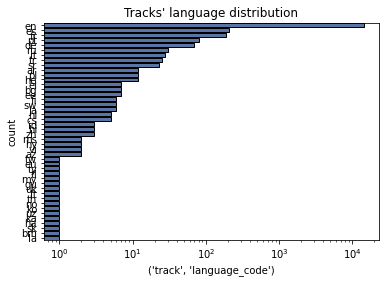

In [7131]:
column_name = ('track', 'language_code')
sns_barplot(tracks, column_name, str(column_name), False, True, "Tracks' language distribution")

In [7132]:
print("non-empty language_code", tracks[~(tracks[('track', 'language_code')].isna())].shape[0])
print("language_code=en", tracks[(tracks[('track', 'language_code')] == "en")].shape[0])

non-empty language_code 15024
language_code=en 14255


In [7133]:
df_imputation_probe = tracks.copy()

missing_license_indeces = df_imputation_probe[df_imputation_probe[('track', 'license')].isna()].index
print("missing_license_indeces BEFORE imputation", len(missing_license_indeces))
for idx in missing_license_indeces:
    genre = df_imputation_probe.at[idx, ('track', 'genre_top')]
    if pd.isnull(genre):  
        # replace license with most frequent license among all genres
        license = list(df_imputation_probe[('track', 'license')].mode())[0]
    else:
        # replace license with most frequent license among matching genre
        license = list(df_imputation_probe[(df_imputation_probe[('track', 'genre_top')] == genre)][('track', 'license')].mode())[0]
    df_imputation_probe.at[idx, ('track', 'license')] = license
    
# checking 
missing_license_indeces = df_imputation_probe[df_imputation_probe[('track', 'license')].isna()].index
print("missing_license_indeces AFTER imputation", len(missing_license_indeces))

missing_license_indeces BEFORE imputation 87
missing_license_indeces AFTER imputation 0


In [7134]:
# trying to see what happens if we impute missing ('track', 'language_code') with 
# ('track', 'license')'s last word (usually corresponds to a country name and so a derived language_code)
artist_language_impunted = set()
not_matched_last_words = set()
for idx in tracks.index:
    license = tracks.at[idx, ('track', 'license')]
    if pd.isnull(license):
        continue
    artist = tracks.at[idx, ('artist', 'id')]
    language = tracks.at[idx, ('track', 'language_code')]
    last_word = license.split(" ")[-1]
    replace_flag = False
    if last_word == "States": # "Unites States"
        df_imputation_probe.at[idx, ('track', 'language_code')] = "en"
        replace_flag = True
    elif last_word == "Kingdom":  # "United Kingdom"
        df_imputation_probe.at[idx, ('track', 'language_code')] = "en"
        replace_flag = True
    elif last_word == "Scotland":  # "United Kingdom"
        df_imputation_probe.at[idx, ('track', 'language_code')] = "en"
        replace_flag = True
    elif last_word == "Wales":  # "United Kingdom"
        df_imputation_probe.at[idx, ('track', 'language_code')] = "en"
        replace_flag = True
    elif last_word == "Zealand":  # "New Zealand"
        df_imputation_probe.at[idx, ('track', 'language_code')] = "en"
        replace_flag = True
    elif last_word == "International":  # defaul english
        df_imputation_probe.at[idx, ('track', 'language_code')] = "en"
        replace_flag = True
    elif 'Attribution 2.0 UK: England ' in license or\
         'Attribution-Share Alike 2.0 UK: England ' in license  or \
          'Attribution-Noncommercial-No Derivative Works 2.0 UK: England ' in license or\
           'Attribution-Noncommercial 2.0 UK: England ' in license or\
           'Attribution-Noncommercial-Share Alike 2.0 UK: England ' in license:
        df_imputation_probe.at[idx, ('track', 'language_code')] = "en"
        replace_flag = True
    elif license == 'ideology.de':
        df_imputation_probe.at[idx, ('track', 'language_code')] = "de"
        replace_flag = True
    elif license == 'Art Libre':
        df_imputation_probe.at[idx, ('track', 'language_code')] = "fr"
        replace_flag = True
    else:
        tmp_df = countries[countries["Name"] == last_word]  
        if tmp_df.shape[0] > 0:  # country name
            lang = tmp_df["Code"].values[0].lower()
            df_imputation_probe.at[idx, ('track', 'language_code')] = lang
            replace_flag = True
        else:
            not_matched_last_words.add((license, last_word))
    if replace_flag:
            artist_language_impunted.add(artist)
print("artist_language_impunted", len(artist_language_impunted))
print("not_matched_last_words", len(not_matched_last_words))
perc = df_imputation_probe[df_imputation_probe[('track', 'language_code')].isna()].shape[0] / df_imputation_probe.shape[0] * 100
print("still missing rows= %.1f%%" % perc)
en_perc = df_imputation_probe[df_imputation_probe[('track', 'language_code')] == "en"].shape[0] / df_imputation_probe.shape[0] * 100
print("english percentage=%.1f%%" % en_perc)

artist_language_impunted 12251
not_matched_last_words 25
still missing rows= 29.3%
english percentage=67.9%


In [7135]:
tracks_with_missing_language = \
            df_imputation_probe[df_imputation_probe[('track', 'language_code')].isna()]
album_with_missing_language = tracks_with_missing_language[('album', 'id')].unique()
artist_with_missing_language = tracks_with_missing_language[('artist', 'id')].unique()
print("tracks_with_missing_language", tracks_with_missing_language.shape[0])
print("album_with_missing_language", len(album_with_missing_language))
print("artist_with_missing_language", len(artist_with_missing_language))


for idx in tracks_with_missing_language.index:
    artist = df_imputation_probe.at[idx, ('artist', 'id')]
    tmp_df = df_imputation_probe[df_imputation_probe[('artist', 'id')] == aid]
    languages = tmp_df[('track', 'language_code')].dropna().unique()
    language_code_to_impute = ""
    if len(languages) == 0:
        location = df_imputation_probe.at[idx, ('artist', 'location')]
        if pd.isnull(location):
            language_code_to_impute = "en"  # default language is English, maybe check location
        else:
            if "," in location:
                tmp_list = location.split(",")
                location = tmp_list[1].replace(" ", "")
            tmp_df = countries[countries["Name"] == location]  
            if tmp_df.shape[0] > 0:  # country name
                language_code_to_impute = tmp_df["Code"].values[0].lower()
    else:
        if len(languages) == 1:
            language_code_to_impute = languages[0]
        elif len(languages) == 2:
            if languages[0] == "en":
                language_code_to_impute = languages[1]
            else:
                language_code_to_impute = languages[0]
            print(aid, languages)
        else:
            print(languages)
            
    if language_code_to_impute != "":
        # df_imputation_probe.at[idx, ('track', 'language_code')] = language_code_to_impute
        pass

tracks_with_missing_language 31257
album_with_missing_language 4498
artist_with_missing_language 4779


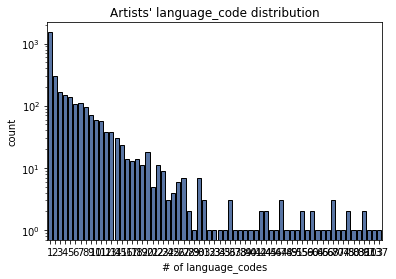

In [7136]:
# ('track', 'language_code') per ('artist', 'id') distribution
artist_per_languages = {}
for aid in tracks[('artist', 'id')].unique():
    tmp_df = tracks[tracks[('artist', 'id')] == aid][('track', 'language_code')].dropna()
    key = tmp_df.shape[0]
    if key > 0:
        try:
            artist_per_languages[key].add(aid)
        except KeyError:
            artist_per_languages[key] = set()
            artist_per_languages[key].add(aid)

ordered_artist_per_languages = dict(OrderedDict(sorted(artist_per_languages.items())))
for key, value in ordered_artist_per_languages.items():
    ordered_artist_per_languages[key] = len(value)
sns_barplot_x_and_y(ordered_artist_per_languages, "# of language_codes", "Artists' language_code distribution", True, False)

In [7137]:
for key, value in artist_per_languages.items():
    if key == 1:
        continue
    international_artists = tracks[(tracks[('track', 'language_code')] == "en") & \
                        (tracks[('artist', 'id')].isin(value))][('artist', 'id')].unique()

In [7138]:
songs_with_language_code = tracks[~(tracks[('track', 'language_code')].isna())].shape[0]
print("songs_with_language_code", songs_with_language_code)
english_songs = tracks[tracks[('track', 'language_code')] == "en"].shape[0]
print("english_songs", english_songs)
print("monolingual_artists", ordered_artist_per_languages[1])
english_monolingual_artists = tracks[(tracks[('track', 'language_code')] == "en") & \
                        (tracks[('artist', 'id')].isin(artist_per_languages[1]))][('artist', 'id')].unique()
print("english_monolingual_artists", len(english_monolingual_artists))
not_nan_language_code_artists = tracks[~(tracks[('track', 'language_code')].isna())][('artist', 'id')].unique()
print("not_nan_language_code_artists", len(not_nan_language_code_artists))

songs_with_language_code 15024
english_songs 14255
monolingual_artists 1519
english_monolingual_artists 1411
not_nan_language_code_artists 3077


Half of artists sing in one language (49.37% of artists among artists having at least one language_code different than NaN in the dataset) and since English-speaker countries have the gretest frequency their native language is English (92.89% of monolingual artists sings in English). 

PREPROCESSING: since ('track', 'language_code') before and afterthe imputation is almost a zero-variance column (it is dominanted by English language), we will disregard it.

<b><font color="green">
We dected many missing values in ('artist', 'location'), ('artist', 'latitude'), ('artist', 'longitude') and ('track', 'language_code') columns, which aren't possible to solve due to many not geographical entries in the ('artist', 'location') column. We even tried to perform a cleaning stage using a country map converter, retrived from https://datahub.io/core/country-list and modified by hand to contemplate missing cases, but the pre-processing work was still not half-way finished, so we prefered not wasting additional time in ('artist', 'location') column's rescue. Since, however, we believed more important to have ('track', 'language_code') we tries to smartly guess these many missing values, by noticing that ('track', 'license')'s names in many cases end with a country name, from which we reasoned could be justified to deriva tracks' language_code. However, this imputation process lead to a zero-variance column, so , in the end, we had to exclud ('track', 'language_code'), too.</font></b>

<h1>Categorical features insight</h1>

In [7139]:
tracks.describe(include='object').T

count unique  \
album  date_created       103141  14340   
       date_released       70330   3669   
       engineer            15301    622   
       information         83219  11075   
       producer            18066    760   
       tags               106574   2388   
       title              105651  14298   
       type               100158      5   
artist active_year_begin   22711     76   
       active_year_end      5375     57   
       associated_labels   14271    754   
       bio                 71156   6084   
       date_created       105718  15970   
       location            70210   2329   
       members             46849   4015   
       name               106574  16294   
       related_projects    13152    752   
       tags               106574  15660   
       website             79256   6642   
       wikipedia_page       5581    389   
set    split              106574      3   
       subset             106574      3   
track  composer             3670    505   
       date_created       106574  86169   
       date_recorded        6159    773   
       genre_top           49598     16   
       genres             106574   4768   
       genres_all         106574   4151   
       information          2349   1586   
       language_code       15024     44   
       license            106487    113   
       lyricist              311     66   
       publisher            1263    135   
       tags               106574   2451   
       title              106573  94986   

                                                                        top  \
album  date_created                                     2015-01-26 13:04:57   
       date_released                                    2008-01-01 00:00:00   
       engineer                                              Ernie Indradat   
       information        <p class="p1" style="margin: 0px; padding: 8px...   
       producer                                                  Joe Belock   
       tags                                                              []   
       title                                              microSong Entries   
       type                                                           Album   
artist active_year_begin                                2007-01-01 00:00:00   
       active_year_end                                  2016-01-01 00:00:00   
       associated_labels                                       HUSH Records   
       bio                <p><span style="color: #333333; font-family: G...   
       date_created                                     2013-03-31 02:17:41   
       location                                                Brooklyn, NY   
       members                                            Konstantin Trokay   
       name                                                         Kosta T   
       related_projects   Ratatat, Lullatone, Nightmares On Wax, Air, Mo...   
       tags                                                              []   
       website                     https://soundcloud.com/konstantin-trokay   
       wikipedia_page            http://en.wikipedia.org/wiki/Josh_Woodward   
set    split                                                       training   
       subset                                                         large   
track  composer                                           konstantin trokai   
       date_created                                     2009-04-20 22:30:54   
       date_recorded                                    2008-11-26 00:00:00   
       genre_top                                                       Rock   
       genres                                                          [21]   
       genres_all                                                      [21]   
       information        <p><a href="http://www.myspace.com/theshambler...   
       language_code                                                     en   
       license            Att

In [7140]:
categorical_tracks = tracks.select_dtypes('object')
categorical_tracks.shape

(106574, 35)

In [7141]:
for column_name in categorical_tracks.columns:
    # count number of rows with missing values
    data = categorical_tracks[column_name]
    n_miss = data.isnull().sum()
    perc = n_miss / categorical_tracks.shape[0] * 100
    if n_miss > 0:
        #print( '%.1f%% of NaN rows for %s ' % (perc, column_name))
        pass

Regarding the categorical features, the dataset has:

- 3.3% of NaN rows for ('album', 'date_created') 
- 34.0% of NaN rows for ('album', 'date_released') 
- **85.6% of NaN rows for ('album', 'engineer')**
- 22.0% of NaN rows for ('album', 'information') 
- **83.1% of NaN rows for ('album', 'producer')**
- 1.0% of NaN rows for ('album', 'title') 
- 6.1% of NaN rows for ('album', 'type') 
- **78.7% of NaN rows for ('artist', 'active_year_begin')** 
- **95.0% of NaN rows for ('artist', 'active_year_end')** 
- **86.6% of NaN rows for ('artist', 'associated_labels')** 
- 33.2% of NaN rows for ('artist', 'bio') 
- 0.8% of NaN rows for ('artist', 'date_created') 
- 34.1% of NaN rows for ('artist', 'location') 
- 56.0% of NaN rows for ('artist', 'members') 
- **87.7% of NaN rows for ('artist', 'related_projects')** 
- 25.6% of NaN rows for ('artist', 'website') 
- **94.8% of NaN rows for ('artist', 'wikipedia_page')** 
- **96.6% of NaN rows for ('track', 'composer')** 
- **94.2% of NaN rows for ('track', 'date_recorded')** 
- 53.5% of NaN rows for ('track', 'genre_top') 
- **97.8% of NaN rows for ('track', 'information')** 
- **85.9% of NaN rows for ('track', 'language_code')** 
- 0.1% of NaN rows for ('track', 'license') 
- **99.7% of NaN rows for ('track', 'lyricist')** 
- **98.8% of NaN rows for ('track', 'publisher')** 
- 0.0% of NaN rows for ('track', 'title') 

PREPROCESSING: In the Data Cleaning stage we will descarded the highly missing record columns (the bold above).

<font color="fuchsia"><h6>('album', 'date_created') and ('album', 'date_released') constrains </h6></font>
Constrains:

1. ('album', 'date_created') >=  ('artist', 'active_year_begin')
2. ('album', 'date_released') >=  ('artist', 'active_year_begin')
3. ('album', 'date_created') <= ('track', 'date_recorded'),  with track belonging to album
4. ('album', 'date_released') <= ('track', 'date_recorded'),  with track belonging to album

The first two constrains impose that in order to create/release an album the artist must been active. The third and fourth constrains impose that when an album is created/released its tracks are known and so already recorded.

N.B.: an album can be created before or after ('artist', 'active_year_end') (i.e. ussually after an artist passed away a memorial album is created/released). 

N.B.B.: hypotizing a different album, artist and track time profiling on Echonest ('album', 'date_created'), ('album', 'date_released'), ('artist', 'date_created') and ('track', 'date_created') are unconstrained among them (i.e. metadata added to Echonest before album/artist/track's actual creation/release or most of tghe times happens that a tracks is first released and its album and artist data is added).

PREPROCESSING: artists with NaT in the ('artist', 'active_year_end') column, display this value probably beacause they are not yet death, but since 95.0% of rows share this characteristic, imputing it will lead to a zero-variance column. **So we will discard ('artist', 'active_year_end') column**. In addition, we will probably **omit ('artist', 'active_year_begin') column, too, due too many missing values**.

In [7142]:
def check_date_values(column_name1, column_name2):
    id_flag = 'id'
    if column_name1[0] == 'track':
        id_flag = 'title'
    lower = len(tracks[((tracks[column_name1]) < (tracks[column_name2])) & 
                      (tracks[column_name1] != np.datetime64('NaT') ) & 
                      (tracks[column_name2] != np.datetime64('NaT') )
                      ][(column_name1[0], id_flag)].unique())
    greater = len(tracks[((tracks[column_name1]) > (tracks[column_name2])) & 
                       (tracks[column_name1] != np.datetime64('NaT') ) &
                       (tracks[column_name2] != np.datetime64('NaT') )
                       ][(column_name1[0], id_flag)].unique())
    
    print("%s < %s=%s" % (column_name1, column_name2, lower))
    print("%s > %s=%s" % (column_name1, column_name2, greater))


In [7143]:
check_date_values(('album', 'date_created'), ('artist', 'active_year_begin'))
print()
check_date_values(('album', 'date_released'), ('artist', 'active_year_begin'))

('album', 'date_created') < ('artist', 'active_year_begin')=0
('album', 'date_created') > ('artist', 'active_year_begin')=3551

('album', 'date_released') < ('artist', 'active_year_begin')=6
('album', 'date_released') > ('artist', 'active_year_begin')=2310


All albums' creation on Echonest are consistent with artists' career beginning.
**6 albums are biased due to their releasing before artists' career beginning**. We can hypotize that ('album', 'date_released') is a biased column, but further investigation is needed, since due to many missing values ('artist', 'active_year_begin') may be discarded.

In [7144]:
check_date_values(('album', 'date_created'), ('track', 'date_recorded'))
print()
check_date_values(('album', 'date_released'), ('track', 'date_recorded'))

('album', 'date_created') < ('track', 'date_recorded')=68
('album', 'date_created') > ('track', 'date_recorded')=1135

('album', 'date_released') < ('track', 'date_recorded')=151
('album', 'date_released') > ('track', 'date_recorded')=427


**68 albums have ('album', 'date_created') previous ('track', 'date_recorded') ** and **151 albums have ('album', 'date_released') previous ('track', 'date_recorded')'**. We can hypotize that ('track', 'date_recorded') is a biased column, but further investigation is needed.

<font color="fuchsia"><h6>('artist', 'active_year_begin'), ('artist', 'active_year_end') and ('artist', 'created')  constrains</h6></font>
We have already verified that ('album', 'date_created') is consistent with ('artist', 'active_year_begin'), as well as finding 6 albums having ('album', 'date_released') previous than ('artist', 'active_year_begin').

As already stated, too, ('artist', 'active_year_end') doesn't impose constains upon album and tracks creations, since after an artist's death is quite frequent to release new albums and songs.

Constrains:
1. ('artist', 'active_year_begin') <= ('artist', 'active_year_end')
1. ('artist', 'active_year_begin') <= ('artist', 'date_created')
3. ('artist', 'active_year_begin') <= ('track', 'date_created')
4. ('artist', 'active_year_begin') <= ('track', 'date_recorded')

In [7145]:
check_date_values(('artist', 'active_year_begin'), ('artist', 'active_year_end'))

('artist', 'active_year_begin') < ('artist', 'active_year_end')=269
('artist', 'active_year_begin') > ('artist', 'active_year_end')=0


All artists' withdrawal from the scene are consistent with their career beginning.

In [7146]:
check_date_values(('artist', 'active_year_begin'), ('artist', 'date_created'))

('artist', 'active_year_begin') < ('artist', 'date_created')=1254
('artist', 'active_year_begin') > ('artist', 'date_created')=0


All artists present on Echonest were created before their career beginning.

In [7147]:
check_date_values(('artist', 'active_year_begin'), ('track', 'date_created'))
print()
check_date_values(('artist', 'active_year_begin'), ('track', 'date_recorded'))

('artist', 'active_year_begin') < ('track', 'date_created')=1254
('artist', 'active_year_begin') > ('track', 'date_created')=0

('artist', 'active_year_begin') < ('track', 'date_recorded')=304
('artist', 'active_year_begin') > ('track', 'date_recorded')=3


**3 artists display an ('artist', 'active_year_end') posterior to ('track', 'date_recorded')**. On the contrary, all tracks created on Echonest are consistent with artist's career beginning. Our biased hypotetisis upon 'track', 'date_recorded') in enforced.

<font color="fuchsia"><h6>('track', 'date_created') and ('track', 'date_recorded') constrains </h6></font>
We already discovered that ('track', 'date_recorded') is incosistent with ('album', 'date_created'), ('album', 'date', 'release') [in turn inconsistent with ('artist', 'active_year_begin')] and ('artist', 'active_year_begin').

Constrains:
1. ('track', 'date_created') >= ('track', 'date_recorded')

In [7148]:
check_date_values(('track', 'date_created'), ('track', 'date_recorded'))

('track', 'date_created') < ('track', 'date_recorded')=306
('track', 'date_created') > ('track', 'date_recorded')=5409


**306 tracks have ('track', 'date_created') previous ('track', 'date_recorded')**. 

PREPROCESSING: Since ('track', 'date_recorded') presented inconsistences also with ('album', 'date_created'),  ('album', 'date_released'), ('artist', 'active_year_begin'), ('track', 'date_created') and have 94.2% of NaN rows,  we confirm its inconsistence and so removal.

<b><font color="green">
RECAP: ('track', 'date_recorded') is a biased column and so we won't use it. We will omitt ('artist', "active_year_begin") and ('artist', 'active_year_end'), too, due too many missing values. We are still in doubt if keeping ('album', 'date_released') and in genereal the other date_created columns, since maybe exists some correlation among them.
</font></b>

<h6>Trasforming datetime columns</h6>

In [7149]:
# converting columns relative to dates to datetime64[ns] type
dates_columns = [('album', 'date_created'), ('album', 'date_released'), ('artist', 'active_year_begin'), 
                 ('artist', 'active_year_end'), ('artist', 'date_created'), ('track', 'date_created'),
                 ('track', 'date_recorded')]
for dcolumn in dates_columns:
    tracks[dcolumn] = pd.to_datetime(tracks[dcolumn], infer_datetime_format=True)

In [7150]:
datetime_tracks = tracks.select_dtypes('datetime64')
datetime_tracks.shape

(106574, 7)

In [7151]:
def support_transform_column_in_years_and_months(df, column_name):
    years_column = []
    months_colum = []
    for row in df[column_name]:
        years_column.append(row.year)
        months_colum.append(row.month)
    if len(years_column) != df.shape[0] or len(months_colum) != df.shape[0]:
        print("not matching column's length")
    return years_column, months_colum

In [7152]:
# splitting datetime64[ns] into year and month
original_datetime_column = list(datetime_tracks.columns)
for column_name in original_datetime_column:
    years_column, months_column  = transform_column_in_years_and_months(datetime_tracks, column_name)
    column_index = datetime_tracks.columns.get_loc(column_name)
    new_years_column_name = (column_name[0], column_name[1] + "_year")
    new_months_column_name = (column_name[0], column_name[1] + "_month")
    datetime_tracks.insert(loc=column_index, column=new_years_column_name, value=years_column)
    datetime_tracks.insert(loc=column_index+1, column=new_months_column_name, value=months_column)
    
# drop old datetime64[ns] columns
for column_name in original_datetime_column:
    del datetime_tracks[column_name]
datetime_tracks.shape

(106574, 14)

<h6>Checking correlation among datetime columns</h6>

In [7153]:
def normalize_df(df, scaler_flag):
    # for column_name in columns_to_normalize:
    column_names = list(df.columns)
    for column_name in column_names:
        data = df[column_name]
        scaler = None
        if scaler_flag == "min_max":
            scaler = MinMaxScaler()
        elif scaler_flag == "standard":
            scaler = StandardScaler()
        elif scaler_flag == "maxabs":
            scaler = MaxAbsScaler()
        elif scaler_flag == "robust":
            scaler = RobustScaler()
        else:
            print("scaler_flag error")
            sys.exit(-1)
        # fit the model on the feature to normale its values and transform it
        df[column_name] = scaler.fit_transform(df[column_name].values.reshape(-1,1))[:, 0]
    return df

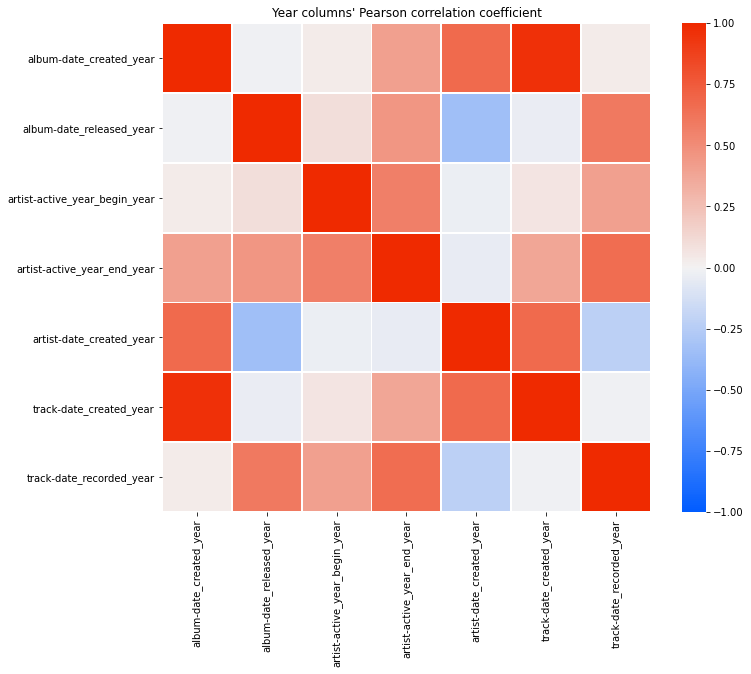

In [7154]:
norm_datetime_tracks = datetime_tracks.dropna().copy()  # N.B. = removing NaN values
del norm_datetime_tracks[('artist', 'active_year_begin_month')]
del norm_datetime_tracks[('artist', 'active_year_end_month')]
del norm_datetime_tracks[('album', 'date_created_month')]
del norm_datetime_tracks[('album', 'date_released_month')]
del norm_datetime_tracks[('artist', 'date_created_month')]
del norm_datetime_tracks[('track', 'date_created_month')]
del norm_datetime_tracks[('track', 'date_recorded_month')]
norm_datetime_tracks = normalize_df(norm_datetime_tracks, "min_max")
corr = norm_datetime_tracks.corr()


f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(255, 30, 255, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0.0, vmax = 1, vmin = -1, 
                                                                              square=True, linewidths=1, ax=ax)
plt.xlabel("")
plt.ylabel("")
plt.title("Year columns' Pearson correlation coefficient")
plt.show()

In [7155]:
# investigating negative correlation
threshold = -0.6
for i in range(len(corr.columns)):
    for j in range(i):
        if (corr.iloc[i, j] <= threshold):
            print(corr.columns[i], corr.columns[j], corr.iloc[i, j])

In [7156]:
# investigating positive correlation
threshold = 0.6
for i in range(len(corr.columns)):
    for j in range(i):
        if (corr.iloc[i, j] >= threshold):
            print(corr.columns[i], corr.columns[j], corr.iloc[i, j])

('artist', 'date_created_year') ('album', 'date_created_year') 0.6788141844010688
('track', 'date_created_year') ('album', 'date_created_year') 0.9640248554083234
('track', 'date_created_year') ('artist', 'date_created_year') 0.6769701963237771
('track', 'date_recorded_year') ('artist', 'active_year_end_year') 0.6622848607866609


From the correlation matrix we discovered that:
    
- ('track', 'date_created_year') wiht ('album', 'date_created_year') are highly positive correlated (+0.96). We can therefore remove one of the two original datetime columns from the dataframe;
- ('track', 'date_created_year') wiht ('artist', 'date_created_year') are positive correlated (+0.68);
- ('track', 'date_created_year') wiht ('artist', 'date_created_year') are positive correlated (+0.68).

We don't take into consideration ('track', 'date_recorded') since we found out it is a biased colum, as well as ('artist', 'active_year_begin') and ('artist', 'active_year_end') due too many missing values. 

PREPROCESSING: since ('album', 'date_created'), ('artist', 'date_created') and ('track', 'date_created') columns are highly positive correlated, we decide to keep only ('track', 'date_created') due to the fact that it doesn't have any missing value, as opposed to ('album', 'date_created') [3.3% missing rows] and ('artist', 'date_created') [0.8% missing rows]. We need also to correct the 6 albums biased towards ('album', 'date_released') to keep this column, which doesn't show any strong correlation with the others.

<h6> Verifying if correcting baised ('album', 'date_released') correlation matrix changes </h6>

In [7157]:
modified_datetime_tracks = datetime_tracks.copy()
modified_datetime_tracks.shape

(106574, 14)

In [7158]:
biased_indeces = list(tracks[tracks[('album', 'date_released')] < (tracks[('artist', 'active_year_begin')])].index)
for idx in biased_indeces:
    # swap previous ('album', 'date_released') with ('artist', 'active_year_begin')
    # records being consistent with ('artist', 'active_year_begin') will still continue to be consistent with
    # a precedent artist career's start
    v1 = modified_datetime_tracks.at[idx, ('artist', 'active_year_begin_year')]
    v2 = modified_datetime_tracks.at[idx, ('artist', 'active_year_begin_month')]
    v3 = modified_datetime_tracks.at[idx, ('album', 'date_released_year')]
    v4 = modified_datetime_tracks.at[idx, ('album', 'date_released_month')]
    modified_datetime_tracks.at[idx, ('album', 'date_released_year')] = v1
    modified_datetime_tracks.at[idx, ('album', 'date_released_month')] = v2
    modified_datetime_tracks.at[idx, ('artist', 'active_year_begin_year')] = v3
    modified_datetime_tracks.at[idx, ('artist', 'active_year_begin_month')] = v4
# checking
modified_datetime_tracks[modified_datetime_tracks[('album', 'date_released_year')] < (modified_datetime_tracks[('artist', 'active_year_begin_year')])].shape[0]

0

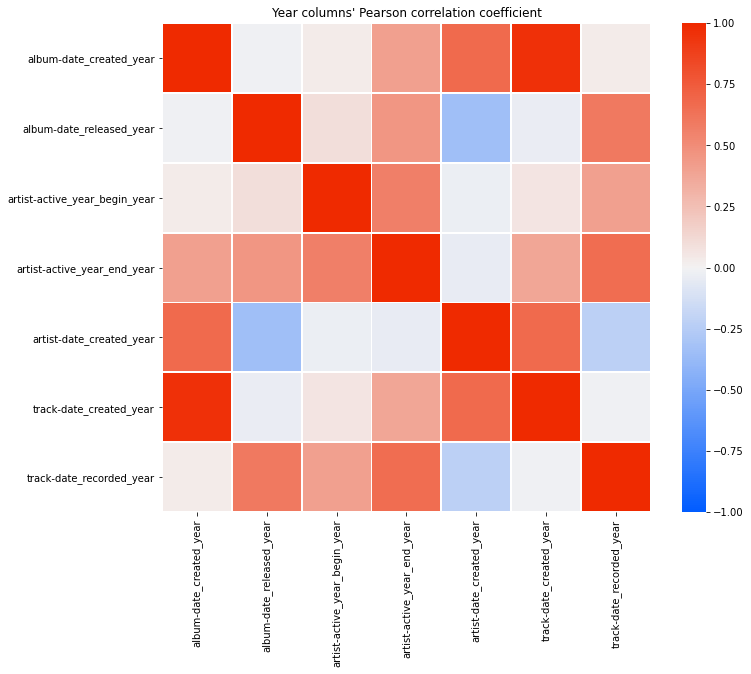

In [7159]:
norm_datetime_tracks = modified_datetime_tracks.dropna().copy()  # N.B. = removing NaN values
del norm_datetime_tracks[('artist', 'active_year_begin_month')]
del norm_datetime_tracks[('artist', 'active_year_end_month')]
del norm_datetime_tracks[('album', 'date_created_month')]
del norm_datetime_tracks[('album', 'date_released_month')]
del norm_datetime_tracks[('artist', 'date_created_month')]
del norm_datetime_tracks[('track', 'date_created_month')]
del norm_datetime_tracks[('track', 'date_recorded_month')]
norm_datetime_tracks = normalize_df(norm_datetime_tracks, "min_max")
corr = norm_datetime_tracks.corr()


f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(255, 30, 255, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0.0, vmax = 1, vmin = -1, 
                                                                              square=True, linewidths=1, ax=ax)
plt.xlabel("")
plt.ylabel("")
plt.title("Year columns' Pearson correlation coefficient")
plt.show()

In [7160]:
# investigating negative correlation
threshold = -0.6
for i in range(len(corr.columns)):
    for j in range(i):
        if (corr.iloc[i, j] <= threshold):
            print(corr.columns[i], corr.columns[j], corr.iloc[i, j])

In [7161]:
# investigating positive correlation
threshold = 0.6
for i in range(len(corr.columns)):
    for j in range(i):
        if (corr.iloc[i, j] >= threshold):
            print(corr.columns[i], corr.columns[j], corr.iloc[i, j])

('artist', 'date_created_year') ('album', 'date_created_year') 0.6788141844010688
('track', 'date_created_year') ('album', 'date_created_year') 0.9640248554083234
('track', 'date_created_year') ('artist', 'date_created_year') 0.6769701963237771
('track', 'date_recorded_year') ('artist', 'active_year_end_year') 0.6622848607866609


In [7162]:
print(modified_datetime_tracks[(modified_datetime_tracks[('album', 'date_released_year')]) < 
                         (modified_datetime_tracks[('track', 'date_created_year')])].shape[0])
print(modified_datetime_tracks[(modified_datetime_tracks[('album', 'date_released_year')]) == 
                         (modified_datetime_tracks[('track', 'date_created_year')])].shape[0])
print(modified_datetime_tracks[(modified_datetime_tracks[('album', 'date_released_year')]) >
                         (modified_datetime_tracks[('track', 'date_created_year')])].shape[0])

26887
42295
1148


PREPROCESSING: Even by correcting the 36 biased rows (relative to 6 albums), having their release year set before the relative artist's actual career start (we switched the two dates), we don't detect changes in the Correlation Matrix. However, since ('album', 'date_released') present 34% of missing rows we prefer not to use it, whitout loosing important metadata (we still have ('track', 'date_created') that in some sort convey this meaning).

<b><font color="green">
RECAP: among all datetime colums the only consistent e relevant to keep is ('track', 'date_created').
</font></b>

<h6>Removing all datetime columns, a part from  ('track', 'date_created') from original DataFrame.</h6>

In [7163]:
def transform_list_into_seasons(months_list):
    season_list = []
    for m in months_list:
        if m == 3 or m == 4 or m == 5:
            season_list.append("Spring")
        if m == 6 or m == 7 or m == 8:
            season_list.append("Summer")
        if m == 9 or m == 10 or m == 11:
            season_list.append("Autumn")
        if m == 12 or m == 1 or m == 2:
            season_list.append("Winter")
            
    if len(season_list) != len(months_list):
        print("Lists lenght missmatch")
        sys.exit(-1)
    return season_list

In [7164]:
# removing all all datetime columns, a part from ('track', 'date_created') f
dates_columns = [('album', 'date_created'), ('album', 'date_released'), ('artist', 'active_year_begin'), 
                 ('artist', 'active_year_end'), ('artist', 'date_created'), ('track', 'date_recorded')]
for dcolumn in dates_columns:
    del tracks[dcolumn] 
    
# splitting datetime64[ns] into year and month
original_datetime_column = [('track', 'date_created')]
for column_name in original_datetime_column:
    years_column, months_column  = transform_column_in_years_and_months(tracks, column_name)
    season_column = transform_list_into_seasons(months_column)
    column_index = tracks.columns.get_loc(column_name)
    new_years_column_name = (column_name[0], column_name[1] + "_year")
    new_months_column_name = (column_name[0], column_name[1] + "_season")
    tracks.insert(loc=column_index, column=new_years_column_name, value=years_column)
    tracks.insert(loc=column_index+1, column=new_months_column_name, value=season_column)
    
# drop old datetime64[ns] columns
for column_name in original_datetime_column:
    del tracks[column_name]
tracks.shape

(106574, 47)

<h2>Tracks' genre_top understanding </h2>

From tracks' "genre_top" feature we find out that the dataset is unbalanced in respect to the 16 main music genres. The three, most prominent genres are:

1. Rock (14,182)
2. Experimental (10,608)
3. Electronic (9,372)

All the other **72,412 tracks** (<font color="red"> among which 56,976 must be impunted since they present NaN values</font>) belong to the remaining 13 main genres.

In [7165]:
def sns_barplot(df, column_name, x_label, x_ticks_rotation_flag, y_log_flag, title):
    count_dict = Counter(df[column_name].dropna())  # N.B. = removing NaN values
    count_dict = dict(sorted(count_dict.items(),key=operator.itemgetter(1),reverse=True))
    y = list(count_dict.keys())
    x = list(count_dict.values())
    sns.barplot(x=x, y=y, log=y_log_flag, color="#4C72B0")
    if x_ticks_rotation_flag:
        plt.xticks(rotation=90)
    plt.xlabel(x_label)
    plt.ylabel("count")
    plt.title(title)
    plt.show()

In [7166]:
def sns_histplot(df, column_name, log_flag, horizontal_flag, title):
    if horizontal_flag:
        sns.histplot(y=column_name, data=df, color="#4C72B0")
        plt.yticks(list(df[column_name].dropna().unique()))
        if log_flag:
            plt.xscale('log')
        plt.ylabel(str(column_name))
        plt.xlabel("count")
    else:
        sns.histplot(x=column_name, data=df, color="#4C72B0")
        plt.xticks(list(df[column_name].dropna().unique()))
        if log_flag:
            plt.yscale('log')
        plt.xlabel(str(column_name))
        plt.ylabel("count")
    plt.title(title)
    plt.show()

In [7167]:
def sns_countplot(df, column_name, ax, log_flag, horizontal_flag):
      
    # create a list to collect the plt.patches data
    percentages = []
    # find the values and append to list
    for value in reversed(df[column_name].value_counts().index):
        perc = df[df[column_name] == value].shape[0] / df.shape[0]*100
        percentages.append(perc)
    
    if horizontal_flag:
        if "AxesSubplot" not in str(ax):
            ax = sns.countplot(y=column_name, data=df, color="#4C72B0", order=reversed(df[column_name].value_counts().index))
        else:
            sns.countplot(y=column_name, data=df, color="#4C72B0", ax=ax, order=reversed(df[column_name].value_counts().index))
        
        if log_flag:
            plt.xscale('log')
        plt.ylabel(str(column_name))
        plt.xlabel("count")
            
        # set individual bar lables using above list
        for i, perc  in zip(ax.patches, percentages):
            # get_width pulls left or right; get_y pushes up or down
            ax.text(i.get_width()+100, i.get_y()+.18, "%.1f%%" % perc)
        # invert for largest on top 
        ax.invert_yaxis()
        
    else:
        if "AxesSubplot" not in str(ax):
            ax = sns.countplot(x=column_name, data=df, color="#4C72B0", order=reversed(df[column_name].value_counts().index))
        else:
            sns.countplot(x=column_name, data=df, color="#4C72B0", ax=ax, order=reversed(df[column_name].value_counts().index))
            
        if log_flag:
            plt.yscale('log')
        plt.xlabel(str(column_name))
        plt.ylabel("count")
        plt.xticks(sorted(list(df[column_name].dropna().unique())))
        
    plt.title("%s distribution" % str(column_name))
    if "AxesSubplot" not in str(ax):
        plt.show()

In [7168]:
def sns_boxplot_ordered_by_mean(df, category_name, numerical_name, ax, horizontal_flag, showfliers):
    grouped = df.loc[:,[category_name, numerical_name]].dropna() \
    .groupby([category_name]) \
    .mean() \
    .sort_values(by=numerical_name)
    
    plt.title("%s per %s distribution" % (str(column_name2), str(column_name1)))
    if horizontal_flag:
        x = df[numerical_name]
        y = df[category_name]
    else:
        y = df[numerical_name]
        x = df[category_name]
        plt.xticks(rotation=90)
    if "AxesSubplot" not in str(ax):
        sns.boxplot(x=x, y=y, order=grouped.index, color="#4C72B0", showfliers=showfliers)
        plt.show()
    else:
        sns.boxplot(x=x, y=y, order=grouped.index, color="#4C72B0", showfliers=showfliers, ax=ax)

In [7169]:
def sns_scatterplot(df, x_column_name, y_column_name, hue_column_name, x_ticks_rotation_flag, title):
    if hue_column_name == "":
        scatter = sns.scatterplot(x=x_column_name, y=y_column_name, data=df.dropna(), color="#4C72B0")
    else:
        scatter = sns.scatterplot(x=x_column_name, y=y_column_name, hue=hue_column_name, data=df.dropna(), palette="tab10", marker="o")
    # plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    if x_ticks_rotation_flag:
        plt.xticks(rotation=45)
    plt.title(title)
    if hue_column_name != "":
        plt.legend(title=str(hue_column_name), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.show()

In [7170]:
def draw_stacked_bar(df, column_name1, column_name2, annotate_top_flag, annotate_top_perc_flag, 
                                                                             annotate_each_stack_perc_flag, ax):

    patch_handles = []
    curr_df = df[[column_name1, column_name2]].dropna()

    # get a frequency table of  column_name1 and column_name2
    pclass_xt = pd.crosstab(df[column_name1], df[column_name2]).dropna()
    if "AxesSubplot" not in str(ax):
        patch_handles.append(pclass_xt.plot(kind="bar", stacked=True, log=True))
    else:
        patch_handles.append(pclass_xt.plot(kind="bar", stacked=True, log=True, ax=ax))
    plt.xlabel(column_name1)
    plt.ylabel('count')
    plt.xticks(rotation=90)
    plt.legend(title=str(column_name2), bbox_to_anchor=(1.05, 1.0), loc="upper left")
    # plt.legend(title=str(column_name2), bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=2, fancybox=True, shadow=True)

    # search all of the bar segments and annotate
    unique_values = sorted(curr_df[column_name1].unique())  # alphabetical order
    tmp_xticks_tot_elements = {}
    for rec in ax.patches:
        height = rec.get_height()
        x = rec.get_x() + rec.get_width() / 2
        y = rec.get_y() + height / 2
        current_value = unique_values[int(x)]  # index with xticks unique column_name1's values
        tot_current_value = curr_df[curr_df[column_name1] == current_value][column_name1].shape[0] 
        percentage =  "{:.0f}%".format(height /tot_current_value*100)

        try:
            tmp_count = tmp_xticks_tot_elements[str(x)]
            tmp_count += height
            tmp_xticks_tot_elements[str(x)] = tmp_count
        except KeyError:
             tmp_xticks_tot_elements[str(x)] = height

        if annotate_each_stack_perc_flag:
            ax.text(x, y, percentage, ha='center', va='bottom')

    # put total number of elements on top of each bar
    if annotate_top_flag:
        for x, tot_x in tmp_xticks_tot_elements.items():
            perc = "{:.0f}%".format(int(tot_x) / curr_df.shape[0]*100)
            ax.text(float(x), tot_x, str(int(tot_x)), ha='center', va='bottom')

    if annotate_top_perc_flag:
        for x, tot_x in tmp_xticks_tot_elements.items():
            perc = "{:.0f}%".format(int(tot_x) / curr_df.shape[0]*100)
            ax.text(float(x), tot_x, perc, ha='center', va='bottom')

    plt.title("%s per %s distribution" % (str(column_name1), str(column_name2)))
    plt.show()
    return pclass_xt

In [7171]:
def get_colors_list(standard_columns_order, different_columns_order):
    tmp_len = len(standard_columns_order)
    colors = list(plt.cm.tab10(np.arange(tmp_len)))
    colors = [list(elem) for elem in colors]
    colors_dict = dict(zip(standard_columns_order, colors))
    
    colors = []
    for column_name in different_columns_order:
        c = colors_dict[column_name]
        colors.append(c)
    return colors, colors_dict

In [7172]:
def draw_reversed_frequency_stacked_bar(df, column_name1, column_name2, y_log_flag, x_rotate_flag,
                                                                                annotate_top_perc_flag, ax):
    alphabetical_genres = ["Blues", "Classical", "Country", "Easy Listening", "Electronic", "Experimental", 
          "Folk", "Hip-Hop", "Instrumental", "International", "Jazz", "Old-Time / Historic",
            "Pop", "Rock", "Soul-RnB", "Spoken"]
    
     # get a frequency table of  column_name1 and column_name2
    pclass_xt = pd.crosstab(df[column_name1], df[column_name2]).dropna()
    
    # compute a stacked bar with decreasing frequency for each unique value in column_name1
    num_rows = len(alphabetical_genres)
    num_column = len(pclass_xt.columns)
    ordered_rows = [[]]*num_rows
    ordered_columns = [[]]*num_rows
    for i in range(0, len(alphabetical_genres)):
        g = alphabetical_genres[i]
        g_values = []
        g_first_columns = []
        for column_name in pclass_xt.columns:
            tmp_list = list(pclass_xt[column_name])
            value = tmp_list[i]
            g_values.append(value)
            g_first_columns.append(column_name)
        sorted_g_values = []
        sorted_g_first_columns = []
        for j in range(0, num_column):
            max_v = max(g_values)
            index = g_values.index(max_v)
            sorted_g_values.append(max_v)
            sorted_g_first_columns.append(g_first_columns[index])
            g_values.pop(index)
            g_first_columns.pop(index)

        ordered_rows[i] = sorted_g_values
        ordered_columns[i] = sorted_g_first_columns
    
    # draw stacked bars
    colors_dict = {}
    curr_df = df[[column_name1, column_name2]].dropna()
    for i in range(0, num_rows):
        y = ordered_rows[i]
        x = [alphabetical_genres[i]]*len(y)
        label = ordered_columns[i]
        colors, colors_dict = get_colors_list(pclass_xt.columns, label)
        bottoms = [0]  # first bar drawn at y=0
        for j in range(1, len(y)):
            j_1_elements_sum = sum(y[:j])
            bottoms.append(j_1_elements_sum)
            
        tot_elems =  sum(y)
        perc = "{:.0f}%".format(int(tot_elems) / curr_df.shape[0]*100)
        
        if "AxesSubplot" not in str(ax):
            if annotate_top_perc_flag:
                plt.text(x[0], tot_elems, perc, ha='center', va='bottom')
            plt.bar(x, y, label=label, color=colors, bottom=bottoms)
        else:
            if annotate_top_perc_flag:
                ax.text(x[0], tot_elems, perc, ha='center', va='bottom')
            plt.bar(x, y, label=label, color=colors, bottom=bottoms, ax=ax)
            
    # self-created legend
    handles = []
    for key, value in colors_dict.items():
        patch = mpatches.Patch(color=value, label=key)
        handles.append(patch)
    plt.legend(title=column_name2, handles=handles, bbox_to_anchor=(1.05, 1.0), loc="upper left")
    
    if x_rotate_flag:
        plt.xticks(rotation=90)
    if y_log_flag:
        plt.yscale("log")
    plt.xlabel(column_name1)
    plt.ylabel("count")
    plt.title("%s per %s distribution" % (str(column_name1), str(column_name2)))
    
    if "AxesSubplot" not in str(ax):
        plt.show()
    
    return pclass_xt

In [7173]:
def df_described_based_upon_genres(column_name, sub_genres_list):
    if len(sub_genres_list) == 0:
        tmp_list = genres
    else:
        tmp_list = sub_genres_list
    for genre in tmp_list:
        tmp_serie = tracks[tracks[('track', 'genre_top')] == genre][column_name]
        tmp_min = tmp_serie.min()
        tmp_max = tmp_serie.max()
        tmp_mean = tmp_serie.mean()
        tmp_median = tmp_serie.median()
        tmp_std = tmp_serie.std()
        print(genre, "min=%s" %tmp_min, "max=%s" %tmp_max, "mean=%s" %tmp_mean, "std=%s" %tmp_std, "median=%s" %tmp_median)

In [7174]:
genres = tracks[('track', 'genre_top')].dropna().unique()

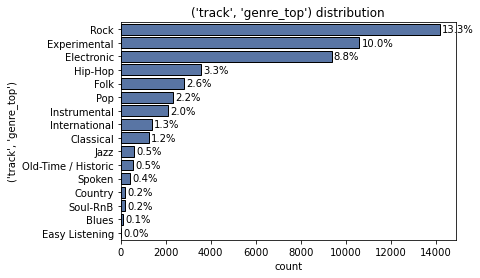

In [7175]:
column_name = ('track', 'genre_top')
sns_countplot(tracks, column_name, "", False, True)

In [7176]:
three_top_genres = ["Rock", "Experimental", "Electronic"]

In [7177]:
rock = tracks[tracks[('track', 'genre_top')] == "Rock"].shape[0] 
rock

14182

In [7178]:
experimental = tracks[tracks[('track', 'genre_top')] == "Experimental"].shape[0] 
experimental

10608

In [7179]:
electronic = tracks[tracks[('track', 'genre_top')] == "Electronic"].shape[0] 
electronic

9372

In [7180]:
rock + experimental + electronic

34162

<h6>Songs NOT having as main genre Rock, Experimental or Electronic</h6>

In [7181]:
tracks.shape[0] - (rock + experimental + electronic)

72412

<h6>among which NaN genre_top: </h6>

In [7182]:
tracks[(tracks[('track', 'genre_top')].isna())].shape[0]

56976

<h6> so untill genre_top imputation we have a total of NOT Rock, Experimental or Electronic tracks:</h6<

In [7183]:
tracks.shape[0] - (rock + experimental + electronic) - tracks[(tracks[('track', 'genre_top')].isna())].shape[0]

15436

<36>Numerical features</h3>

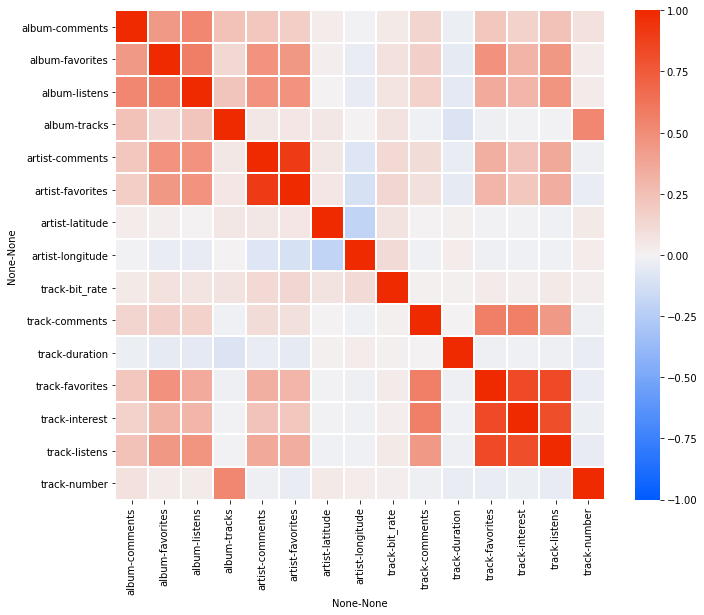

In [7184]:
norm_numeric_tracks = numeric_tracks.dropna().copy()  # N.B. = removing NaN values
del norm_numeric_tracks[('album', 'id')]
del norm_numeric_tracks[('artist', 'id')]
# del norm_numeric_tracks[('track', 'date_created_year')]
norm_numeric_tracks = normalize_df(norm_numeric_tracks, "min_max")
corr = norm_numeric_tracks.corr()


f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(255, 30, 255, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0.0, vmax = 1, vmin = -1, square=True, linewidths=1, ax=ax)
plt.show()

In [7185]:
# investigating negative correlation
threshold = -0.6
for i in range(len(corr.columns)):
    for j in range(i):
        if (corr.iloc[i, j] <= threshold):
            print(corr.columns[i], corr.columns[j], corr.iloc[i, j])

In [7186]:
# investigating positive correlation
threshold = 0.5
for i in range(len(corr.columns)):
    for j in range(i):
        if (corr.iloc[i, j] >= threshold):
            print(corr.columns[i], corr.columns[j], corr.iloc[i, j])

('album', 'listens') ('album', 'comments') 0.5237694850080699
('album', 'listens') ('album', 'favorites') 0.5736968534906329
('artist', 'favorites') ('artist', 'comments') 0.9080624795232408
('track', 'favorites') ('track', 'comments') 0.5699743395360148
('track', 'interest') ('track', 'comments') 0.5625378614681774
('track', 'interest') ('track', 'favorites') 0.8309030328748889
('track', 'listens') ('track', 'favorites') 0.8302278182760793
('track', 'listens') ('track', 'interest') 0.8193722868706852
('track', 'number') ('album', 'tracks') 0.529412354755565


From the Pearson Correlation Matrix we detected some medium to hight positive correlated features, as well as some confirm of our data understanding assumptions and constrains (<b><font color="red">Please note that, since the imputation is not yet done, correlation among features may still change.</font></b>).

**Keep**: 
- ('album', 'favorites');
- ('artist', 'favorites'); 
- ('track', 'bit_rate'), ('track', 'duration'), ('track', 'listens'), ('track', 'date_created_year');

**Drop**: 
- ('track', 'interest'), ('track', 'favorites')  => ('track', 'listens');
- ('artist', 'comments') => ('artist', 'favorites').

**Not sure to keep**:*
- ('album', 'listens'), (album, comments);
- ('track', 'comments').


*they have a moderate positive correlation with ('album', 'favorites') and ('album', 'listens') and ('track', 'favorites') and ('track', 'interest'), respectivelly (r~=0.50). In addition we are doubtful about ('album', 'listens')'s semantic (we interpret it as tracks' playcount sum, which in most cases isn't true) and in general about comments features, which not always convay an audiance's appreciation idea.

N.B.: we detected that ('album', 'tracks')  and('track', 'number') are biased.

We can get rid also of ('artist',  'latitude') and ('artist', 'longitude'), since we discovered that they have too many missing values.

<h6> Track bit-rate insight </h6>

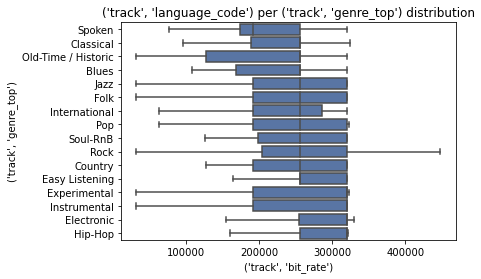

In [7187]:
sns_boxplot_ordered_by_mean(tracks, ('track', 'genre_top'), ('track', 'bit_rate'), "", True, False)

In [7188]:
df_described_based_upon_genres(('track', 'bit_rate'), tracks[('track', 'genre_top')].dropna().unique())

Hip-Hop min=24000 max=321966 mean=279045.3018018018 std=65532.39094324407 median=320000.0
Pop min=-1 max=323488 mean=246443.30703259006 std=73395.45123371207 median=256000.0
Rock min=-1 max=448000 mean=253943.74136229022 std=59443.3940464669 median=256000.0
Experimental min=-1 max=322892 mean=265434.06919306185 std=67695.1884336293 median=320000.0
Folk min=-1 max=320047 mean=241453.59864430968 std=63765.1462226865 median=256000.0
Jazz min=-1 max=320817 mean=239145.2819614711 std=67927.36798997073 median=256000.0
Electronic min=-1 max=330042 mean=275473.8409090909 std=63060.35394390153 median=320000.0
Spoken min=77666 max=320000 mean=220359.60756501183 std=63448.66649734342 median=192000.0
International min=-1 max=320000 mean=245478.06623470123 std=62214.83856148678 median=256000.0
Soul-RnB min=-1 max=320000 mean=253369.02285714285 std=54888.409428664185 median=256000.0
Blues min=108521 max=320000 mean=232565.15454545454 std=63971.86379723117 median=256000.0
Country min=128000 max=32000

In [7189]:
tracks[tracks[('track', 'bit_rate')] == -1].shape[0]

105

In [7190]:
tracks[(tracks[('track', 'bit_rate')] < 200000) & (tracks[('track', 'genre_top')] == "Electronic")].shape[0]

1946

In [7191]:
tracks[(tracks[('track', 'bit_rate')] < 200000) & (tracks[('track', 'genre_top')] == "Hip-Hop")].shape[0]

727

In [7192]:
tracks[(tracks[('track', 'bit_rate')] < 200000) & (tracks[('track', 'genre_top')] == "Classical")].shape[0]

472

All genres have a similar median bit_rate of 256.000. We detect some differences in:
- Spoken having a smaller median bit_rate (192.000);
- Hip-Hop, Experimetal, Electronic and Instrumental having a greater median bit_rate (320.000).

We notice also that:
- the most jumbled bit_rate genres are Pop, Old-Time / Historic and Instrumental (std~=70000); 
- the most stable bit_rate genres are Easy Listening and Soul-RnB (std~=50000). 

PREPROCESIING: <font color=red>From the lowest bit-rates values we can notice how the **('track', 'bit_rate')** column has **105 missing values**, expressed as **-1**. We detected also that 1.966 Electronic track, 727 Hip-Hop tracks and 427 Classical tracks have a bit-rate lower than 200.000, which is an anomalous behaviour for them</font> 

<h6> Track duration insight </h6>

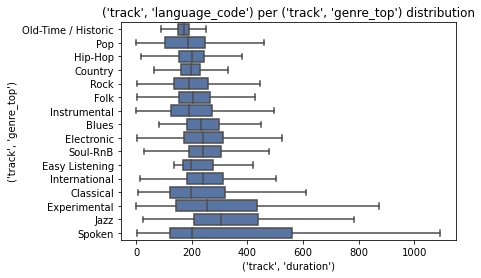

In [7193]:
sns_boxplot_ordered_by_mean(tracks, ('track', 'genre_top'), ('track', 'duration'), "", True, False)

In [7194]:
df_described_based_upon_genres(('track', 'duration'), tracks[('track', 'genre_top')].dropna().unique())

Hip-Hop min=5 max=3672 mean=202.75957207207207 std=118.36532410546295 median=200.0
Pop min=0 max=2511 mean=188.66166380789022 std=153.09818583406573 median=186.0
Rock min=2 max=3675 mean=225.49710901142294 std=189.6491108137779 median=189.0
Experimental min=1 max=3718 mean=362.6684577677225 std=390.91486116028665 median=256.0
Folk min=4 max=3688 mean=230.93649661077416 std=187.33633322840737 median=206.0
Jazz min=24 max=2940 mean=381.91943957968476 std=331.697638404608 median=307.0
Electronic min=4 max=3714 mean=263.77069995731966 std=226.63249296466444 median=240.0
Spoken min=5 max=3706 mean=590.8676122931442 std=897.728791134585 median=201.0
International min=15 max=3667 mean=300.02375809935205 std=302.7215436810421 median=240.0
Soul-RnB min=2 max=1557 mean=264.46285714285716 std=146.52035888060902 median=242.0
Blues min=83 max=710 mean=258.05454545454546 std=108.8204342288469 median=234.0
Country min=64 max=2058 mean=216.1701030927835 std=153.4265513733219 median=198.0
Classical min

In [7195]:
# 0 duration tracks
tracks[tracks[('track', 'duration')] == 0].shape[0]

16

In [7196]:
tracks[tracks[('track', 'duration')] == 0][('track', 'genre_top')].unique()

array([nan, 'Pop', 'Instrumental'], dtype=object)

In [7197]:
# To obtain an official stream on Spotify the track music be played for at least 30 seconds
# for a music creator to secure payment for a stream
# https://www.prsformusic.com/m-magazine/features/song-length-the-spotify-effect/#:~:text=To%20obtain%20an%20official%20stream,ranking%20within%20a%20streaming%20platform.
tracks[tracks[('track', 'duration')] < 30].shape[0]

2057

In [7198]:
# if a track is longer than 10 minutes, in the iTunes Store it will only be available 
# to buy as a part of the whole album
# https://itunespartner.apple.com/music/articles/rights-and-pricing_album-only
tracks[tracks[('track', 'duration')] > 600].shape[0]

5938

According with tracks' duration we can state that:
- Experimental and Jazz have the longuest tracks (median=256 and median=370);
- Pop, Rock and Instrumental have the shortest tracks (median=186, median=189 and  median=190);
- all other genres have a median duration between 196 and 242.

PREPROCESSING: <font color="red">16 tracks have the duration set to 0 (biased tracks, among which 1 Pop, 1 Instrumental and 14 NaN), in our dataset we have 2.057 tracks having a duration less than 30s, while in general songs mustn't have a duration lower than 30 seconds to obtain an official stream on Spotify and so to the previous Echonest.  We have also 5.938 songs having a duration greater than 10 minutes, among which 1 Instrumental track having a duration set to 11.030 seconds (183 minuted!). Officially, we didn't found any maximum duration constrained imposed by Spotify, but many music services like iTunes actually have one, so based on them we will remove these long, outlier tracks, too. This removal aims also to decrease the great standard deviantion that we observed among tracks' duration belonging to the same music genre.</font>

<h6>Track listens insight</h6>

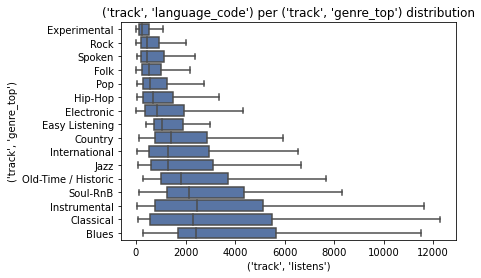

In [7199]:
sns_boxplot_ordered_by_mean(tracks, ('track', 'genre_top'), ('track', 'listens'), "", True, False)

In [7200]:
df_described_based_upon_genres(('track', 'listens'), tracks[('track', 'genre_top')].dropna().unique())

Hip-Hop min=25 max=433992 mean=1671.9774774774776 std=8458.308936739784 median=686.0
Pop min=23 max=79940 mean=1381.304459691252 std=3922.6219002365265 median=553.0
Rock min=9 max=178139 mean=931.3711042166126 std=3085.775630798082 median=427.5
Experimental min=1 max=119301 mean=560.8616138763198 std=2077.0270973220804 median=223.0
Folk min=18 max=42250 mean=990.5319300749197 std=2150.845425956265 median=526.0
Jazz min=74 max=143278 mean=3588.0875656742555 std=9012.978016290916 median=1271.0
Electronic min=7 max=543252 mean=2224.9811139564663 std=8578.22286275248 median=841.0
Spoken min=24 max=12150 mean=978.0898345153664 std=1359.7964116036496 median=429.0
International min=21 max=86617 mean=3056.629229661627 std=6402.5217253705905 median=1275.0
Soul-RnB min=129 max=43369 mean=4163.337142857143 std=6370.933893318763 median=2139.0
Blues min=282 max=143301 mean=8508.727272727272 std=20408.858840079607 median=2439.0
Country min=109 max=24571 mean=2453.8865979381444 std=3041.6280133391233

In [7201]:
tracks[tracks[('track', 'listens')] < 10].shape[0]

158

In [7202]:
tracks[tracks[('track', 'listens')] < 10][('track', 'genre_top')].unique()

array(['Experimental', nan, 'Rock', 'Electronic'], dtype=object)

In [7203]:
tracks[tracks[('track', 'listens')] > 250000].shape[0]

16

In [7204]:
tracks[tracks[('track', 'listens')] > 250000][('track', 'genre_top')].unique()

array(['Hip-Hop', 'Electronic', 'Instrumental', nan], dtype=object)

According to listens we found the following:
- the most listened tracks are Blues, Classical, Soul-RnB and Instrumental (median~=2.000);
- the less listened tracks are Experimental, Spoken, Folk,  Rock, Pop and Hip-Hop (median between 200 and 700)
- all other genres have a median tracks' listens between 800 and 2.000.

PREPROCESSING: <font color="red">16 extreme listened tracks belonging to Hip-Hop, Electronic, Instrumental and NaN have more than 250.000 listens (???158 extreme listened tracks belonging to Rock, Electronic, Experimental and NaN have less than 10 listens) </font>

<h6>Top genre album favorites</h6>

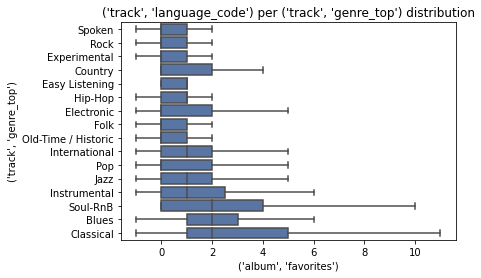

In [7205]:
sns_boxplot_ordered_by_mean(tracks, ('track', 'genre_top'), ('album', 'favorites'), "", True, False)

In [7206]:
df_described_based_upon_genres(('album', 'favorites'), tracks[('track', 'genre_top')].dropna().unique())

Hip-Hop min=-1 max=33 mean=1.1247184684684686 std=2.2095100332446935 median=1.0
Pop min=-1 max=38 mean=1.7710120068610635 std=3.4500617327128893 median=0.0
Rock min=-1 max=29 mean=0.7118177972077281 std=1.6368146543278288 median=0.0
Experimental min=-1 max=18 mean=0.8865950226244343 std=1.7709559250558593 median=0.0
Folk min=-1 max=23 mean=1.1698180520870496 std=2.4594619548789427 median=0.0
Jazz min=-1 max=37 mean=1.8546409807355517 std=4.42618508293799 median=1.0
Electronic min=-1 max=40 mean=1.156423388817755 std=2.3405206363117688 median=0.0
Spoken min=-1 max=4 mean=0.44680851063829785 std=0.8182648262049242 median=0.0
International min=-1 max=23 mean=1.5284377249820014 std=3.0740297677266915 median=1.0
Soul-RnB min=0 max=23 mean=2.7657142857142856 std=3.8725339099116285 median=2.0
Blues min=-1 max=14 mean=3.1636363636363636 std=3.393267140221069 median=2.0
Country min=0 max=6 mean=1.0051546391752577 std=1.305617288664723 median=0.0
Classical min=-1 max=39 mean=4.068292682926829 st

In [7207]:
len(tracks[tracks[('album', 'favorites')] >= 30][('album', 'id')].unique())

18

According with album audiance's preference:
- Soul-RnB, Blues and Classical have the greatest number of favorites (median=2);
- Hip-Hop, Jazz, International, Instrumental and Easy Listening have a medium number of favorites (median=1);
- Pop, Rock, Experimental, Folk, Electronic, Spoken, Country and Old-Time / Historic have the lowest number of favorites (median=0).

PREPROCESSING: <font color="red">18 albums have a number of favorites greater than 30 (which is a value quite high, since the majority of albums don't display any likeness).</font>

<h6>Artist favorites insight</h6>

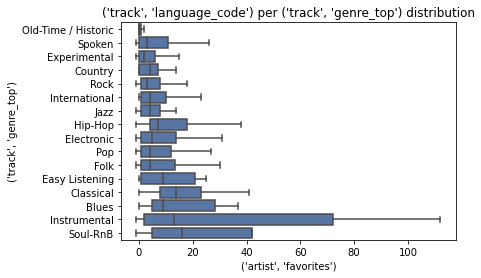

In [7208]:
sns_boxplot_ordered_by_mean(tracks, ('track', 'genre_top'), ('artist', 'favorites'), "", True, False)

In [7209]:
df_described_based_upon_genres(('artist', 'favorites'), tracks[('track', 'genre_top')].dropna().unique())

Hip-Hop min=-1 max=117 mean=15.574042792792794 std=22.03461427077436 median=7.0
Pop min=-1 max=963 mean=21.91852487135506 std=83.55592541857777 median=4.0
Rock min=-1 max=788 mean=8.638908475532364 std=33.853502724707816 median=3.0
Experimental min=-1 max=788 mean=8.194287330316742 std=24.722101290991706 median=2.0
Folk min=-1 max=788 mean=24.62112022832679 std=60.90940496946171 median=4.0
Jazz min=-1 max=431 mean=14.938704028021016 std=53.36440193712447 median=4.0
Electronic min=-1 max=963 mean=18.932351685872813 std=66.45568792896633 median=5.0
Spoken min=-1 max=199 mean=7.26241134751773 std=13.24861365728015 median=3.0
International min=0 max=431 mean=10.321094312455003 std=30.780701408594823 median=4.0
Soul-RnB min=-1 max=788 mean=83.58857142857143 std=196.6189847293323 median=16.0
Blues min=0 max=788 mean=50.69090909090909 std=130.6869461662049 median=9.0
Country min=0 max=788 mean=8.587628865979381 std=56.654073033099635 median=4.0
Classical min=0 max=861 mean=43.72195121951219 s

In [7210]:
len(tracks[tracks[('artist', 'favorites')] > 350][('artist', 'id')].unique())

9

According to clients'preference:
- Blues, Easy Listening, Instrumental, Classical and Soul-RnB artists are the most favourited (median between 9 and 16);
- Old-Time / Historic, Experimental, Rock and Spoken artists are the list favourited (median between 0 and 3);
- all the other genres have a median artists' favourite between 4 and 7.

PREPROCESSING: <font color="red">9 artist are enourmously liked (more than 350 favourites) </font>

<h6>Tracks' years</h6> 

In [7211]:
def print_perc_column(column_name):
    print("%s:" % str(column_name))
    tmp_serie = tracks[column_name].dropna()
    counter = Counter(tmp_serie)
    sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
    tot_values = sum(sorted_counter.values())
    for k, v in sorted_counter.items():
        perc = v / tot_values * 100
        print(k, "%.1f%%" % perc, sep="\t")
    print()

In [7212]:
def print_genres_perc_column(column_name):
    print("%s" % str(column_name) + " per ('track', 'genre_top'):")
    for genre in tracks[('track', 'genre_top')].dropna().unique():
        tmp_serie = tracks[(tracks[('track', 'genre_top')] == genre)][column_name].dropna()
        counter = dict(Counter(tmp_serie))
        for value in tracks[column_name].dropna().unique():
            try:
                tmp = counter[value]
                continue
            except KeyError:
                counter[value] = 0
        sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
        tot_values = sum(sorted_counter.values())
        first_k = next(iter(sorted_counter.keys()))
        first_v = next(iter(sorted_counter.values()))
        perc = first_v / tot_values * 100
        print(genre, first_k, "%.1f%%" % perc, sep="\t")

In [7213]:
def print_genres_all_perc_column(column_name):
    print("%s" % str(column_name) + " per ('track', 'genre_top') complete:")
    for genre in tracks[('track', 'genre_top')].dropna().unique():
        tmp_serie = tracks[(tracks[('track', 'genre_top')] == genre)][column_name].dropna()
        counter = dict(Counter(tmp_serie))
        for value in tracks[column_name].dropna().unique():
            try:
                tmp = counter[value]
                continue
            except KeyError:
                counter[value] = 0
        sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
        tot_values = sum(sorted_counter.values())
        for k, v in sorted_counter.items():
            perc = v / tot_values * 100
            print(genre, k, "%.1f%%" % perc, sep="\t")
        print()

In [7214]:
def genre_zero_frequency_table_insight(frequency_table, column_name):
    alphabetical_genres = ["Blues", "Classical", "Country", "Easy Listening", "Electronic", "Experimental", 
          "Folk", "Hip-Hop", "Instrumental", "International", "Jazz", "Old-Time / Historic",
            "Pop", "Rock", "Soul-RnB", "Spoken"]
    
    print("%s's zero values:" % str(column_name))
    for column_name in frequency_table.columns:
        zero_genres = []
        for i in range(0, len(alphabetical_genres)):
            tmp_list = list(frequency_table[column_name])
            if tmp_list[i] == 0:
                zero_genres.append(alphabetical_genres[i])
        if len(zero_genres) > 0:
            print(column_name, zero_genres)

In [7215]:
def genre_max_frequency_table_insight(frequency_table, df, column_name):
    alphabetical_genres = ["Blues", "Classical", "Country", "Easy Listening", "Electronic", "Experimental", 
          "Folk", "Hip-Hop", "Instrumental", "International", "Jazz", "Old-Time / Historic",
            "Pop", "Rock", "Soul-RnB", "Spoken"]
    
    print("%s's max values:" % str(column_name))
    num_rows = len(alphabetical_genres)
    num_column = len(pclass_xt.columns)
    ordered_rows = [[]]*num_rows
    ordered_columns = [[]]*num_rows
    for i in range(0, len(alphabetical_genres)):
        g = alphabetical_genres[i]
        g_values = []
        g_first_columns = []
        for column_name in pclass_xt.columns:
            tmp_list = list(pclass_xt[column_name])
            value = tmp_list[i]
            g_values.append(value)
            g_first_columns.append(column_name)
        sorted_g_values = []
        sorted_g_first_columns = []
        for j in range(0, num_column):
            max_v = max(g_values)
            index = g_values.index(max_v)
            sorted_g_values.append(max_v)
            sorted_g_first_columns.append(g_first_columns[index])
            g_values.pop(index)
            g_first_columns.pop(index)

        ordered_rows[i] = sorted_g_values
        ordered_columns[i] = sorted_g_first_columns
        
        first_value = sorted_g_values[0]
        first_column = sorted_g_first_columns[0]
        greates_values = [(first_column, first_value)]
        for j in range(1, num_column):
            other_value = sorted_g_values[j]
            other_column = sorted_g_first_columns[j]
            if other_value == first_value:
                greates_values.append((other_column, other_value))
            else:
                break
        genre = alphabetical_genres[i]
        perc = greates_values[0][1] / df[df[('track', 'genre_top')] == genre].shape[0] * 100
        print(genre, greates_values, "%.1f%%" % perc, sep="\t")

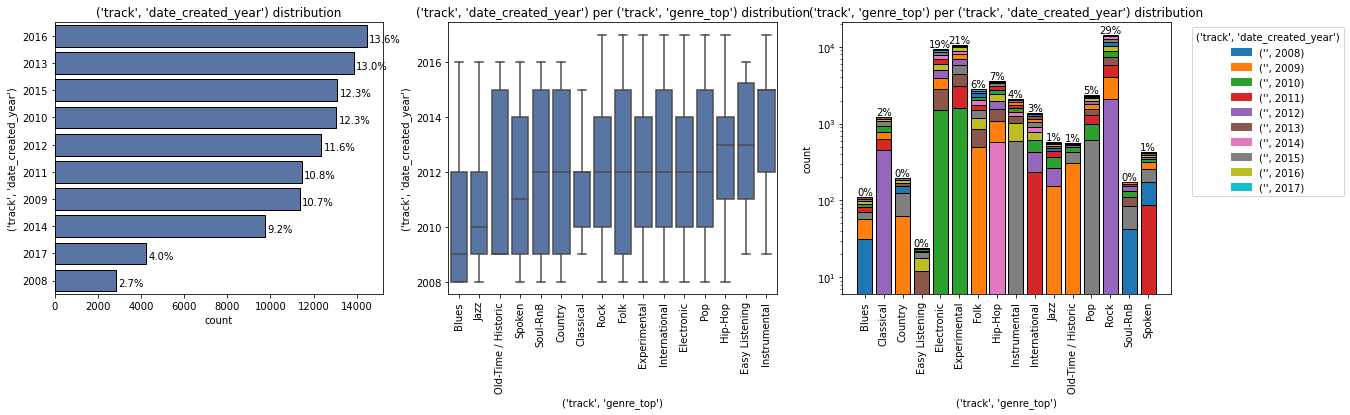

In [7216]:
column_name1 = ('track', 'genre_top')
column_name2 = ('track', 'date_created_year')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(tracks, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
sns_boxplot_ordered_by_mean(tracks, column_name1, column_name2, ax, False, False)
ax = plt.subplot2grid(fig_dims, (0, 2))
pclass_xt = draw_reversed_frequency_stacked_bar(tracks, column_name1, column_name2, True, True, True, "")
plt.show()
# print_perc_column(column_name2)
# print_genres_perc_column(column_name2)
# print_genres_all_perc_column(column_name2)
# genre_zero_frequency_table_insight(pclass_xt, column_name2)
# genre_max_frequency_table_insight(pclass_xt, tracks, column_name2)

In [7217]:
df_described_based_upon_genres(('track', 'date_created_year'), tracks[('track', 'genre_top')].dropna().unique())

Hip-Hop min=2008 max=2017 mean=2012.6097972972973 std=2.4115545485189984 median=2013.0
Pop min=2008 max=2017 mean=2012.5222984562606 std=2.488742606192471 median=2012.0
Rock min=2008 max=2017 mean=2011.9432379072064 std=2.6214429126825434 median=2012.0
Experimental min=2008 max=2017 mean=2012.3075980392157 std=2.4330636988711354 median=2012.0
Folk min=2008 max=2017 mean=2012.1912236889048 std=2.785804749500005 median=2012.0
Jazz min=2008 max=2017 mean=2010.8108581436077 std=2.1388522416053912 median=2010.0
Electronic min=2008 max=2017 mean=2012.3854033290654 std=2.5461679454476918 median=2012.0
Spoken min=2008 max=2016 mean=2011.3049645390072 std=2.671447933746915 median=2011.0
International min=2008 max=2017 mean=2012.334053275738 std=2.57831223978115 median=2012.0
Soul-RnB min=2008 max=2016 mean=2011.5314285714285 std=2.6841136969695336 median=2012.0
Blues min=2008 max=2016 mean=2010.581818181818 std=2.734025557023082 median=2009.0
Country min=2008 max=2016 mean=2011.778350515464 std

Most of tracks were created in 2016 (13.6%). According to greatest creation frequency:
- Soul-RnB	(24.0%) and Blues (28.2%) tracks were most created in 2008;
- Folk	(17.7%), Jazz (26.6%), Country (32.5%) and Old-Time / Historic (54.7%) tracks were most created in 2009;
- Experimental (14.9%) and Electronic (16.0%) tracks were most created in 2010;
- International	(17.1%), Spoken	(20.6%) and Easy Listening (25.0%) tracks were most created in 2011;
- Rock (14.6%) and Classical (37.1%) tracks were most created in 2012;
- Hip-Hop (16.3%) tracks  were most created in 2014;
- Pop (26.1%) and Instrumental (28.4%) were most creted in 2015.

Year creation differences:
- Classical, Easy Listening, Instrumental and Old-Time / Historic aren't present in 2008;
- Country isn't present in 2010 and 2011, too;
- Old-Time / Historic isn't present in 2013, too;
- Blues, Country, Easy Listening, Old-Time / Historic and Soul-RnB aren't present in 2014, too;
- Blues, Country, Easy Listening, Old-Time / Historic, Soul-RnB and Spoken aren't present after 2016;
- Jazz and Old-Time / Historic have the most distant in time tracks (median=2009 and median=2009);
- Blues and Spoken,..., Hip-Hop and Easy Listening (median=2010, median=2011,..., median=2013, median=2013) have quite realted in time tracks;
- Instrumental has the most recent tracks (median=2015)

with ...= all other genres and ...'s median=2012.

PREPROCESSING <font color="red">We detect some extreme recet outlier tracks for Jazz and Classical.</font>

<h3> Categorical features </h3>

In [7218]:
def get_empty_genres_dict(outside_df, nan_flag):
    empty_dict = {}
    genres = list(outside_df[('track', 'genre_top')].unique())
    for g in genres:
        if str(g) == "nan":
            if nan_flag == False:
                continue
        empty_dict[str(g)] = 0
    return empty_dict

In [7219]:
def sns_hued_barplot(outside_df, column_name, nan_flag, log_flag, rotation_flag):
    fig, ax = plt.subplots(figsize=(16, 8))
    hue = ('track', 'genre_top')
    column_name_count = (column_name[0], column_name[1] + "_count")
    df = get_column_insight_based_on_genres(outside_df, column_name, nan_flag)
    color_len = len(outside_df[hue].unique())
    # palette = sns.color_palette("tab10", n_colors=color_len)
    # sns.barplot(x=column_name, y=column_name_count, hue=hue, data=df, palette=palette)
    sns.barplot(x=column_name, y=column_name_count, hue=hue, data=df, palette="tab10")
    if log_flag: 
        plt.yscale("log")
    if rotation_flag:                                
        plt.xticks(rotation=90)
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title("Genre %s distribution per %s" % (str(column_name), str(hue)))
    plt.show()

In [7220]:
def get_column_insight_based_on_genres(outside_df, column_name, nan_flag):
    """
        Return a DataFrame, having 3 columns:
        1. column_name
        2. ('track', 'genre_top')
        3. (column_name[0], column_name[1] + "_count")
        and rows as many as all the combinations among column_name's and ('track', 'genre_top')'s
        unique values.
    """
    hue = ('track', 'genre_top')
    column_name_count = (column_name[0], column_name[1] + "_count")
    genres_insight = {}
    column_dict = Counter(outside_df[column_name])
    if nan_flag == False:
        del column_dict[np.nan]

    # intialize dict with column_name
    for value in column_dict.keys():
        genres_insight[str(value)] = get_empty_genres_dict(outside_df, nan_flag)
        if nan_flag == False:
            del tmp_dict2[np.nan]

    for key in genres_insight.keys():
        if str(key) == "nan":
            hue_dict = Counter(outside_df[(tracks[column_name].isna())][hue])
        else:
            hue_dict = Counter(outside_df[(tracks[column_name] == key)][hue])
        if nan_flag == False:
            del hue_dict[np.nan]
        for k, v in hue_dict.items():
            genres_insight[str(key)][str(k)] = v
            
    # create DataFrame
    column_name_column = []
    hue_column = []
    count_column = []
    for key, value in genres_insight.items():
        tmp_key_values = [key]*len(value)
        column_name_column = column_name_column + tmp_key_values
        for k, v in value.items():
            hue_column.append(k)
            count_column.append(v)

    df = pd.DataFrame()
    df[column_name] = column_name_column
    df[hue] = hue_column
    df[column_name_count] = count_column
    return df

<h6>('album', 'type') insight</h6>

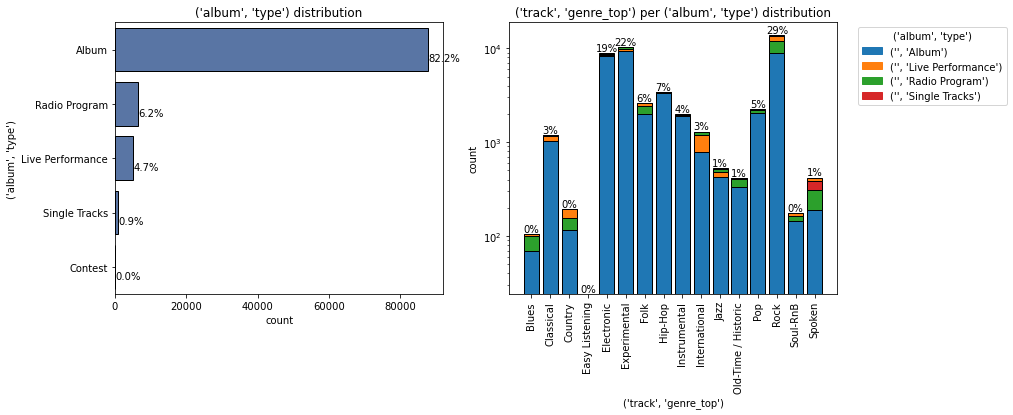

In [7221]:
column_name1 = ('track', 'genre_top')
column_name2 = ('album', 'type')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(tracks, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
pclass_xt = draw_reversed_frequency_stacked_bar(tracks, column_name1, column_name2,True, True, True, "")
plt.show()
# print_perc_column(column_name2)
# print_genres_perc_column(column_name2)
# print_genres_all_perc_column(column_name2)
# genre_zero_frequency_table_insight(pclass_xt, column_name2)
# genre_max_frequency_table_insight(pclass_xt, tracks, column_name2)

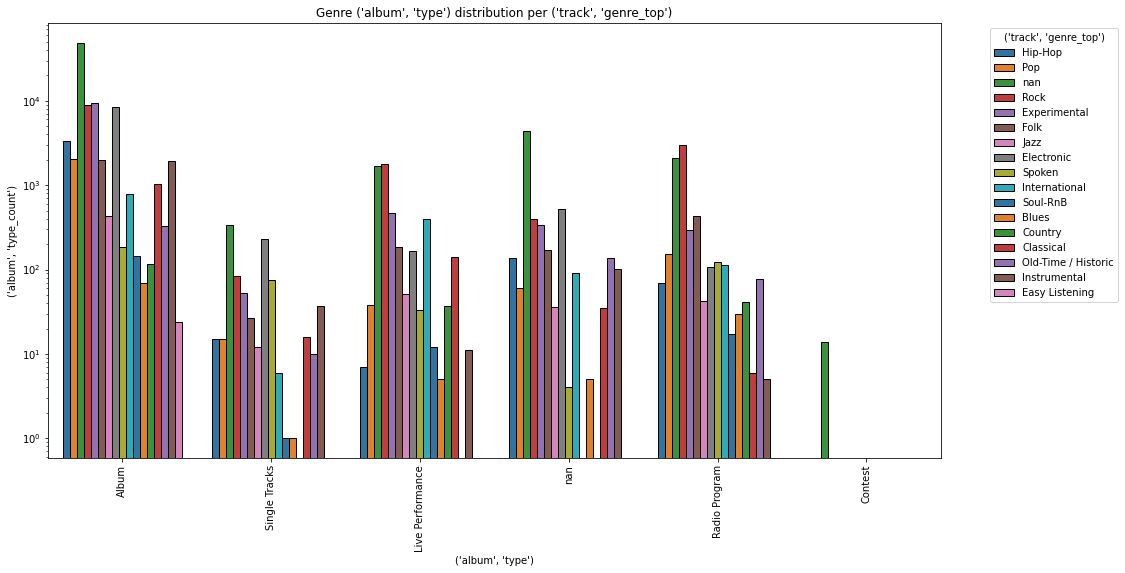

In [7222]:
column_name = ('album', 'type')
sns_hued_barplot(tracks, column_name, True, True, True)

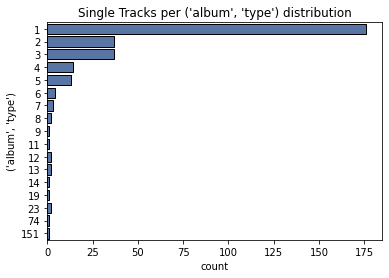

In [7223]:
album_type = "Single Tracks"
tracks_per_album_type = {}
for aid in tracks[tracks[('album', 'type')] == album_type][('album', 'id')]:
    tmp_df = tracks[tracks[('album', 'id')] == aid][column_name]
    key = tmp_df.shape[0]  # num. tracks per album type
    try:
        tracks_per_album_type[key].add(aid)
    except KeyError:
        tracks_per_album_type[key] = set()
        tracks_per_album_type[key].add(aid)

for key, value in tracks_per_album_type.items():
    tracks_per_album_type[key] = len(tracks_per_album_type[key])

sns.barplot(x=list(tracks_per_album_type.values()), y=list(tracks_per_album_type.keys()), color="#4C72B0", orient="h")
plt.xlabel("count")
plt.ylabel(column_name)
plt.title("%s per ('album', 'type') distribution" % album_type)
plt.show()

In [7224]:
tracks[tracks[('album', 'type')].isna()].shape[0]

6416

In [7225]:
# no genres present in NaN ('album', 'type')
gs = tracks[('track', 'genre_top')].dropna().unique()
set(gs).difference(set(tracks[tracks[('album', 'type')].isna()][('track', 'genre_top')].dropna().unique()))

{'Country', 'Easy Listening', 'Soul-RnB'}

**All genres are highly present in Album types**, with a slightly lower percentage for Spoken (44.6%), Country (59.8%), International (60.0%), Rock (64.8%) and Blues (65.7%), presenting conspicuously albums also in Radio Program (29.4%), Radio Program (21.1%), Live Performance (30.8%), Radio Program (21.5%) and Radio Program (28.6%) albums, respectively.

According to albums' types, we discovered also that:
- Contest and Single Tracks albums represent a minority;
- all tracks present in Contest albums have NaN genre_top (all solved with our imputation procedure and belonging to Experimental);
- Country is never release in a Single Track album;
- Old-Time / Historic is never present in Live Performance albums;
- Soul-RnB and Blues are almost never released in Single Track albums.

PREPROCESSING: remove 14 tracks having "Contest" album type and 917 tracks having "Single Tracks" album type (too few records in the dataset). Contest albums gather always NaN genre_top tracks (all solved with our imputation procedure and belonging to Experimental), while for Single Tracks, a part from Spoke (where Single Tracks represent 18.1% of genre's album type), all the other genres have less than 2% of tracks belonging to this album type. In addition, even if album type "Single Tracks" suggests the presence of more than one track contained in it, 122 out of 298 albums have a number of tracks greater than 2 (with some outliers, too, like album=2275 having a 151 tracks). Since "Single Tracks" is less than 1% of total album types and since it is biased, we are quite confident in removing it.

<span style="background-color: #FFFF00"> Regarding missing album types, in the **imputation process we can probably disregard Country, Easy Listening, Soul-RnB tracks, if in genre_top imputation process NaN records don't appear**. </span>

<h6>('track', 'date_created_season') insight</h6>

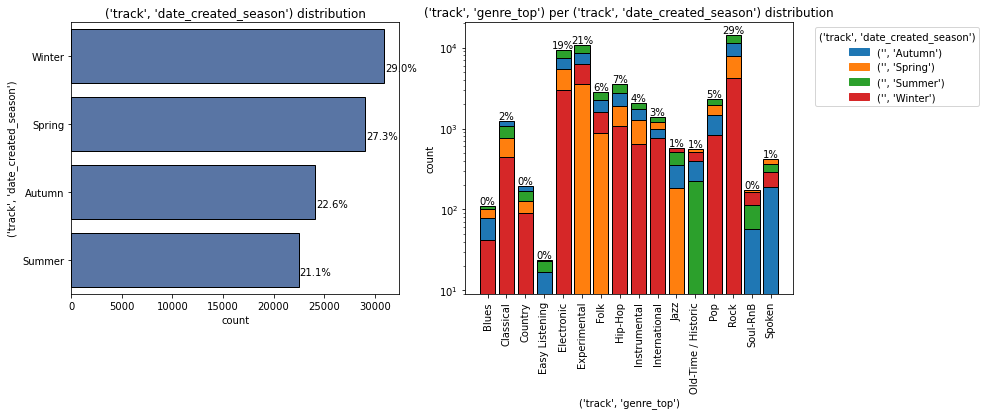

In [7226]:
column_name1 = ('track', 'genre_top')
column_name2 = ('track', 'date_created_season')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(tracks, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
pclass_xt = draw_reversed_frequency_stacked_bar(tracks, column_name1, column_name2, True, True, True, "")
plt.show()
# print_perc_column(column_name2)
# print_genres_perc_column(column_name2)
# print_genres_all_perc_column(column_name2)
# genre_zero_frequency_table_insight(pclass_xt, column_name2)
# genre_max_frequency_table_insight(pclass_xt, tracks, column_name2)

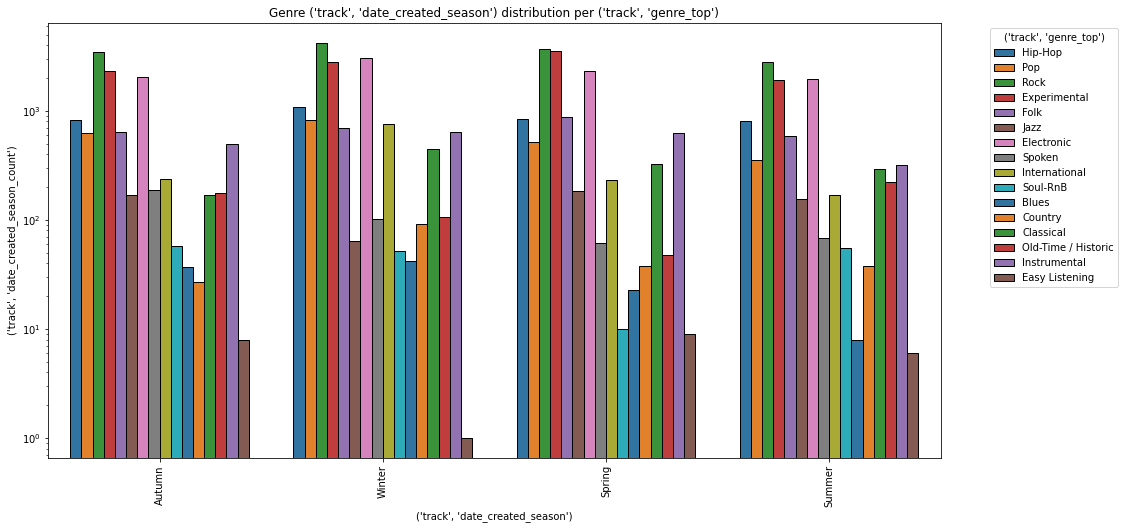

In [7227]:
column_name = ('track', 'date_created_season')
sns_hued_barplot(tracks, column_name, False, True, True)

According to season's creation, don't exist differences in genres' releasing (exists only a slight preferential for winter time). Regarding the single genres:
- Experimental	(33.4%), Folk (31.4%), Jazz (32.0%) and Easy Listening (37.5%) are most created in **Spring**;
- Old-Time / Historic (40.3%) is most created in **Summer**;
- Spoken (44.9%) and Soul-RnB (33.1%)  are most created in **Autumn**;
- Hip-Hop (30.6%), Pop (35.5%), Rock (29.8%), Electronic (32.3%), International (54.4%), Blues (38.2%), Classical	(36.0%), Country (46.9%) and Instrumental (30.9%) are most created in **Winter**.

We can notice also that, Soul-RnB is almost never present in Spring (5.7%), Old-Time / Historic in Spring (8.7%), Blues in Summer (7.3%) and Easy Listening in Winter (4.2%).

<h6> ('track', 'license') insigth</h6>

N.B.Since ('track', 'license') contains 113 unique values, for plotting clarity, for every genre_top we plot only its mode license.

<b><font color="red">Countplots aren't performed uppon the whole dataset but only on matching genre_tops' mode record, so the percentages aren't meaningful (redo sns_countplot if they are needed, this time taking into account the whole dataset).</font></b>

In [7228]:
print("unique ('track', 'license') unique values", len(tracks[('track', 'license')].dropna().unique()))

unique ('track', 'license') unique values 113


In [7229]:
def get_genre_top_mode_df(df, column_name):
    mode_dict = {}
    for genre in df[('track', 'genre_top')].dropna().unique():
        mode = list(df[(df[('track', 'genre_top')] == genre)][column_name].mode())[0]
        mode_dict[genre] = mode

    mode_df = df[df[column_name].isin(list(mode_dict.values()))]
    return mode_df

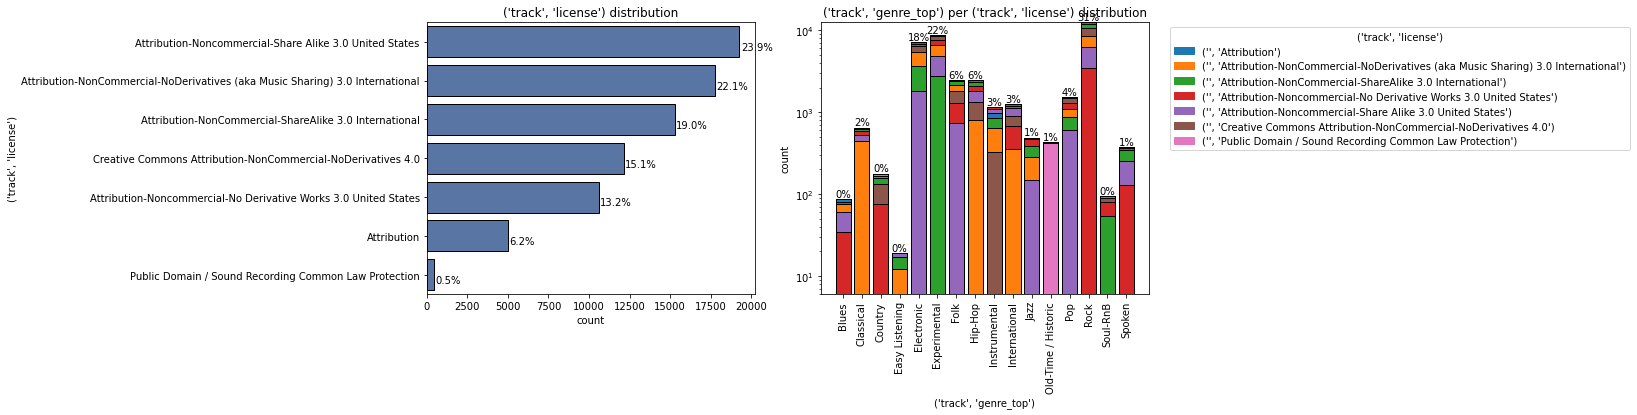

('track', 'license') per ('track', 'genre_top'):
Hip-Hop	Attribution-NonCommercial-NoDerivatives (aka Music Sharing) 3.0 International	22.3%
Pop	Attribution-Noncommercial-Share Alike 3.0 United States	26.1%
Rock	Attribution-Noncommercial-No Derivative Works 3.0 United States	24.4%
Experimental	Attribution-NonCommercial-ShareAlike 3.0 International	26.3%
Folk	Attribution-Noncommercial-Share Alike 3.0 United States	26.5%
Jazz	Attribution-Noncommercial-Share Alike 3.0 United States	25.9%
Electronic	Attribution-Noncommercial-Share Alike 3.0 United States	19.5%
Spoken	Attribution-Noncommercial-No Derivative Works 3.0 United States	30.3%
International	Attribution-NonCommercial-NoDerivatives (aka Music Sharing) 3.0 International	25.3%
Soul-RnB	Attribution-NonCommercial-ShareAlike 3.0 International	30.9%
Blues	Attribution-Noncommercial-No Derivative Works 3.0 United States	30.9%
Country	Attribution-Noncommercial-No Derivative Works 3.0 United States	39.2%
Classical	Attribution-NonCommercial-No

In [7230]:
column_name1 = ('track', 'genre_top')
column_name2 = ('track', 'license')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

mode_df = get_genre_top_mode_df(tracks, column_name2)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(mode_df, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
pclass_xt = draw_reversed_frequency_stacked_bar(mode_df, column_name1, column_name2, True, True, True, "")
plt.show()
# print_perc_column(column_name2)
print_genres_perc_column(column_name2)
# print_genres_all_perc_column(column_name2)
# genre_zero_frequency_table_insight(pclass_xt, column_name2)
# genre_max_frequency_table_insight(pclass_xt, tracks, column_name2)

<ipython-input-7220-460ea7c9f341>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hue_dict = Counter(outside_df[(tracks[column_name] == key)][hue])


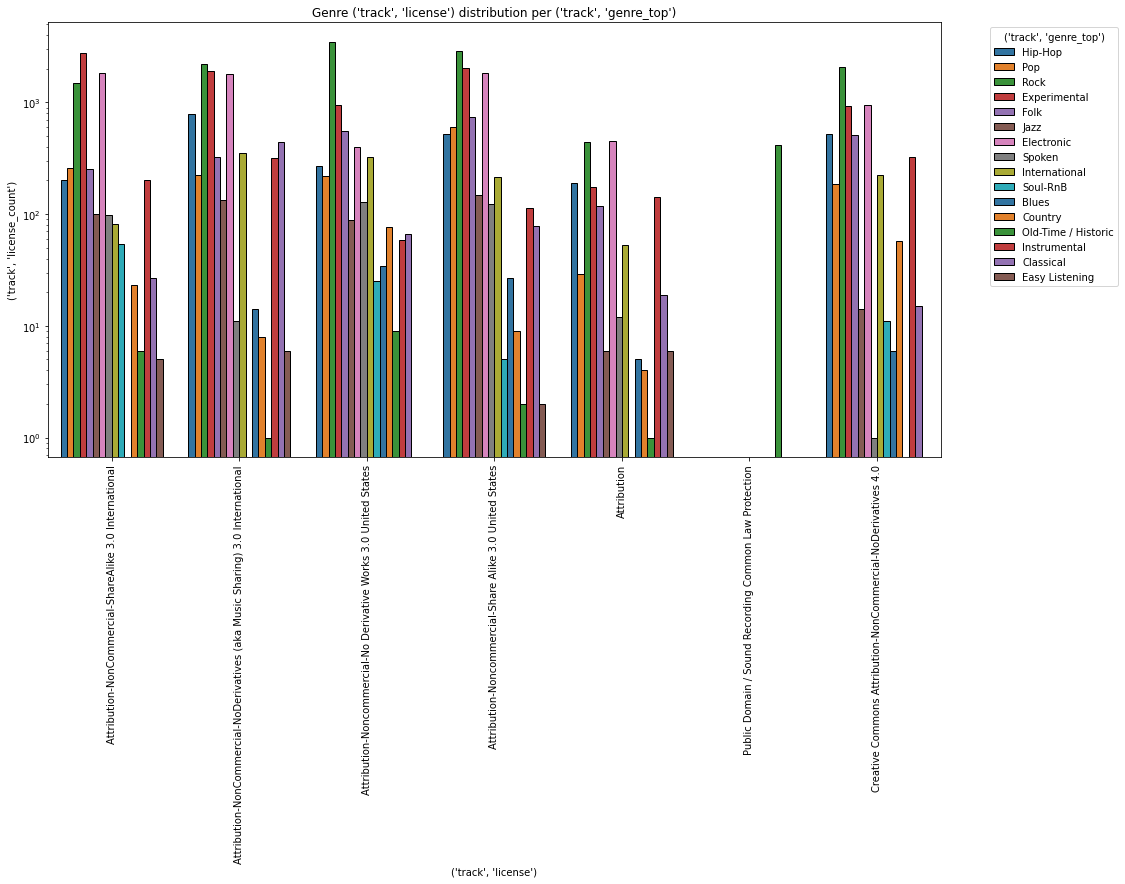

In [7231]:
column_name = ('track', 'license')
sns_hued_barplot(mode_df, column_name, False, True, True)

In [7232]:
# trying to restrict ('track', 'license') cardinality by:
# 1. aggregating to a solely license all licenses beginning with "Attribution"
# 2. aggregating to a solely license all licenses beginning with "Public Domain" 
# This process leads to 13 univocal license

attrition_licenses = set()
public_domain_licenses = set()
for license in tracks[('track', 'license')].dropna().unique():
    if "Attribution" in license:
        attrition_licenses.add(license)
    if "Public Domain" in license:
        public_domain_licenses.add(license)
print("attrition_licenses", len(attrition_licenses))
print("public_domain_licenses", len(public_domain_licenses))

remaining_licenses = set(tracks[('track', 'license')].dropna().unique()).difference(attrition_licenses)
remaining_licenses = set(remaining_licenses).difference(public_domain_licenses)
print("remaining_licenses", len(remaining_licenses))

self_built_univocal_licenses = remaining_licenses.copy()
self_built_univocal_licenses.add("Attribution")
self_built_univocal_licenses.add("Public Domain")
print("self_built_univocal_licenses", len(self_built_univocal_licenses))

attrition_licenses 99
public_domain_licenses 3
remaining_licenses 11
self_built_univocal_licenses 13


In [7233]:
# not NaN ('track', 'license') records
tracks[~(tracks[('track', 'license')].isna())].shape[0]

106487

In [7234]:
# licenses beginning with "Attribution"
tracks[tracks[('track', 'license')].isin(attrition_licenses)].shape[0]

104418

In [7235]:
# licenses beginning with "Public Domain" 
tracks[tracks[('track', 'license')].isin(public_domain_licenses)].shape[0]

806

In [7236]:
# licenses not beginning neither with "Attribution" or "Public Domain"  
tracks[tracks[('track', 'license')].isin(remaining_licenses)].shape[0]

1263

The most common licenses among genres are:
- Attribution-NonCommercial-NoDerivatives (aka Music Sharing) 3.0 International for Hip-Hop (22.3%), International (25.3%), Classical (36.1%) and Easy Listening (25.0%);
- Attribution-Noncommercial-Share Alike 3.0 United States for Pop (26.1%), Folk (26.5%), Jazz (25.9%) and Electronic (19.5%);
- Attribution-Noncommercial-No Derivative Works 3.0 United States for Rock (24.4%), Spoken (30.3%), Blues (30.9%) and Country (39.2%);
- Attribution-NonCommercial-ShareAlike 3.0 International for Experimental (26.3%) and Soul-RnB (30.9%);
- Public Domain / Sound Recording Common Law Protection for Old-Time / Historic (75.2%);
- Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 for Instrumental (15.7%).

PREPROCESSING: among genres, a part from  Old-Time / Historic, don't exist a predominant license and in most cases it seems that licenses are the same, starting mainly with "Attribution" and than being missplet in many declinations. For these reasons and for the fact that categorical column's cardinality is huge (113 unique values) we won't use ('track', 'license'). We even tried to group together all "Attribution"  starting name licenses, resulting in 98.06% of tracks reunited under this label, thus probabli meaning the column must be regardless excluded, since it convey the idea of a zero-variance feature.

<b><font color="green">
RECAP: ('track', 'license') has too many values and if we try to group them together, by merging all "Attribution" starting name licenses, we get a zero-variance column.
</font></b>

<h6>('track', 'language_code') insight</h6>

<b><font color="red">Countplots aren't performed uppon the whole dataset but only on matching genre_tops' mode record, so the percentages aren't meaningful (redo sns_countplot if they are needed, this time taking into account the whole dataset).</font></b>

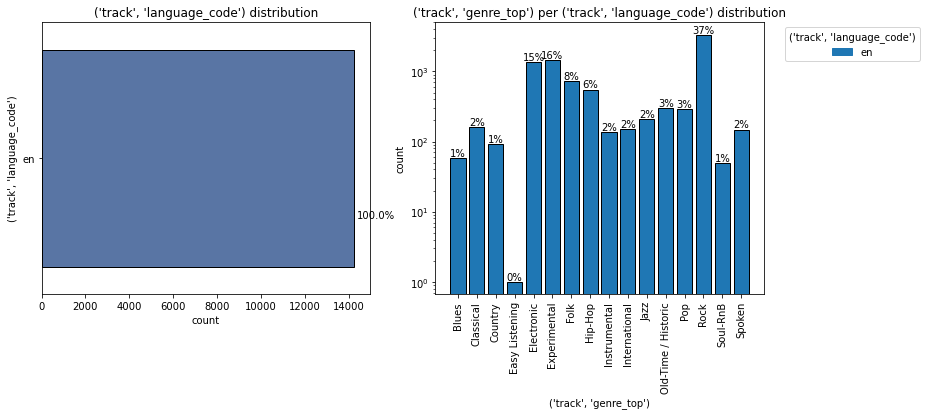

('track', 'language_code') per ('track', 'genre_top'):
Hip-Hop	en	88.5%
Pop	en	97.3%
Rock	en	96.5%
Experimental	en	99.2%
Folk	en	99.6%
Jazz	en	99.5%
Electronic	en	99.3%
Spoken	en	100.0%
International	en	74.3%
Soul-RnB	en	100.0%
Blues	en	100.0%
Country	en	98.9%
Classical	en	73.9%
Old-Time / Historic	en	100.0%
Instrumental	en	100.0%
Easy Listening	en	100.0%


In [7237]:
column_name1 = ('track', 'genre_top')
column_name2 = ('track', 'language_code')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

mode_df = get_genre_top_mode_df(tracks, column_name2)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(mode_df, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
pclass_xt = draw_reversed_frequency_stacked_bar(mode_df, column_name1, column_name2, True, True, True, "")
plt.show()
# print_perc_column(column_name2)
print_genres_perc_column(column_name2)
# print_genres_all_perc_column(column_name2)
# genre_zero_frequency_table_insight(pclass_xt, column_name2)
# genre_max_frequency_table_insight(pclass_xt, tracks, column_name2)

<ipython-input-7220-460ea7c9f341>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hue_dict = Counter(outside_df[(tracks[column_name] == key)][hue])


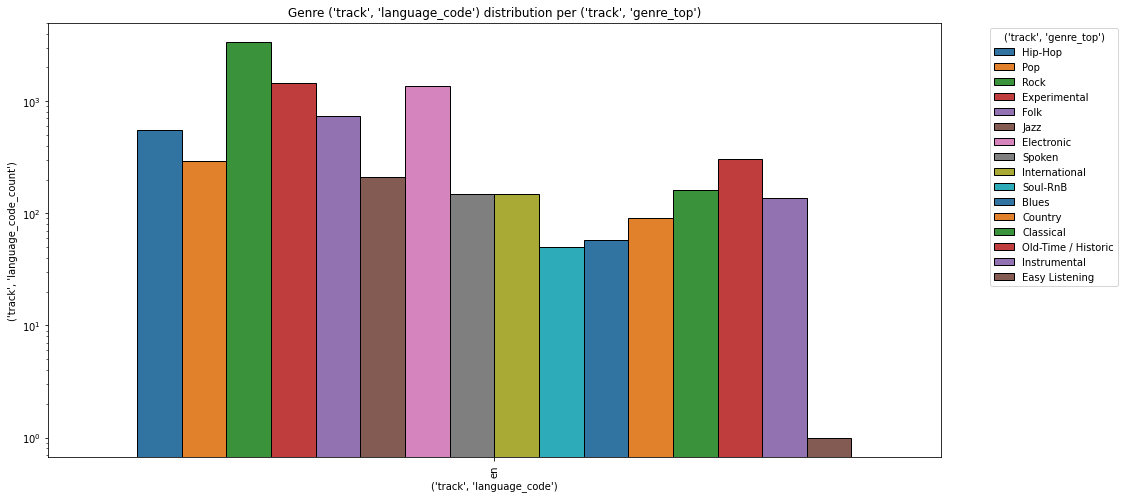

In [7238]:
column_name = ('track', 'language_code')
sns_hued_barplot(mode_df, column_name, False, True, True)

As expected all genres are mainly made up by English tracks:
- 100.0%: Old-Time / Historic, Instrumental, Easy Listening, Spoken, Soul-RnB and Blues;
- 90%-99%: Rock	(96.5%), Pop (97.3%), Electronic (99.3%), Experimental (99.2%), Jazz (99.5%), Folk (99.6%) and Country	(98.9%);
- 80%-89%: Hip-Hop (88.5%);
- 70%-79%: Classical (73.9%) and International (74.3%);

<b><font color="green">
RECAP: ('track', 'language_code') a part from being an highly missing value column, is also a zero-variance column, either before and after our imputation attemp (see above ('track', 'language_code') cleaning).
</font></b>

In [ ]:
tracks_before_imputation = tracks.copy()

<font color="orange"><h1>Imputation</h1></font>

<font color="orange"><h3>('album', 'comments'), ('album', 'listens'), ('album', 'favorites'), ('album', 'tracks'), ('album', 'type'), ('artist', 'comments') and ('artist', 'favorites') imputation</h3></font>

For missing albums and artists' metadata, we impute missing values using given **album's or artist's other tracks' median or mode** (depending on the columns' data type), too (i.e. we replace ('album', 'comments')=-1 with 
other tracks having same ('album', 'id') but ('album', 'comments')!=-1 or if no other track was present in the same album we used median('album', 'comments') among M other artist's albums. For ('album', 'type') we imputed using matching ('album', 'id') but ('album', 'type')!=NaN type or by using the most frequent album type among M other artist's albums).

In [7239]:
imputation_columns = [('album', 'comments'), ('album', 'listens'), ('album', 'favorites'), 
                      ('album', 'tracks'), ('album', 'type'), 
                      ('artist', 'comments'), ('artist', 'favorites')]

for column_name in imputation_columns:
    if column_name[1] == 'type':
        missing_album_indeces = tracks[tracks[column_name].isna()].index
    else:
        missing_album_indeces = tracks[tracks[column_name] == -1].index
    
    for idx in missing_album_indeces:
        album = tracks.at[idx, ('album', 'id')]
        artist = tracks.at[idx, ('artist', 'id')]
        if column_name[1] == 'type':
            tmp_df = tracks[(tracks[('album', 'id')] == album) & ~(tracks[column_name].isna())]
        else:
            tmp_df = tracks[(tracks[('album', 'id')] == album) & (tracks[column_name] != -1)]

        values = []
        if tmp_df.shape[0] > 0:
            values = list(tmp_df[column_name]) 
        else:
            if column_name[1] == 'type':
                tmp_df = tracks[(tracks[('artist', 'id')] == artist) & ~(tracks[column_name].isna())]
            else:
                tmp_df = tracks[(tracks[('artist', 'id')] == artist) & (tracks[column_name] != -1)]
            if tmp_df.shape[0] > 0:
                values = list(tmp_df[column_name])
            
        v = None
        if len(values) > 0: 
            if column_name[1] == 'type':                                                   
                v = statistics.mode(values)
            else:
                v = int(statistics.median(values))
                                                                         
        if v == None:
            if column_name[1] == 'type': 
                v = "Album"
            else:
                v = 0
        tracks.at[idx, column_name] = v
        
# checking
for column_name in imputation_columns:
    if column_name[1] == 'type':
        print(column_name, tracks[tracks[column_name].isna()].shape[0])
    else:
          print(column_name, tracks[tracks[column_name] == -1].shape[0])

('album', 'comments') 0
('album', 'listens') 0
('album', 'favorites') 0
('album', 'tracks') 0
('album', 'type') 0
('artist', 'comments') 0
('artist', 'favorites') 0


<font color="orange"><h3>('track', 'genre_top') imputation</h3></font>
To impute our target column ('track', 'genre_top') we use the following procedure:

1. we date back a given track's missing genre, by looking and evaluating ('track', 'genres') column. In particular, we performed a majority vote among the genres present in the list and if any ties were detected, we used the most frequent genre present in it to impute;
2. if a tie was present among ('track', 'genres') genres, we performed the majority vote upon ('track', 'genres_all'), which contains a superset of the tracks present in ('track', 'genres');
3. for tracks with ties among ('track', 'genres_all'), too, or with empty genre lists, we performed a majority vote uppon ('album', 'tags), ('artist', 'tags) and ('track', 'tags), taking into account matching tags reffering to the 163 total genres (re-mapped than in the usual 16 parent genres);
4. if all majority votes above failed, by taking into account that an album usually has a limited amout of genres, we tried to match tracks with missing genres to tracks without the same missing data and present in the same album, using as matching factors the same bit_rate;
5. for tracks being part of a single track album (and so being lonely in it), we performed the same reasoning, but this time using the same artist as tracks' grouping;
6. if all the above steps failed, due to missing genre_top information for a given track, we disregard the particular row, otherwise we merged all genre_top suggested by the five processes and performed a majority vote uppon them. If again, a tie showed, using track's bit_rate and iterating over each genre involved in the tie, we used lowest difference among track's bit_rate and genre's bit_rate median value, to enact the genre tie solver (Hypothesis: if a track's bit_rate is nearer to a genre_top A's median bit_rate than it is to a genre_top B's median bit_rate, is more probable that the track belongs to A than B). We used median values, to avoid mitigate bit_rate's outliers, but if the tie still persisted, we used mean values. Whereupon, if again a ties showed, we prefered to discregard the particular record, thus preventing noise introduction in the dataset. 

In [7240]:
# loading DataFrame for genres' translation
genres_df = pd.read_csv("../../data/fma_metadata/genres.csv")
genres_df.shape

(163, 5)

In [7241]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   genre_id   163 non-null    int64 
 1   #tracks    163 non-null    int64 
 2   parent     163 non-null    int64 
 3   title      163 non-null    object
 4   top_level  163 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 6.5+ KB


<font color="orange"><h6>('track', 'genres') and ('track', 'genres_all') imputation</h6></font>

In [7242]:
def genres_all_remapping(genres_all):
    genres_all_mapped = []
    for g in genres_all:
        top_level = genres_df[genres_df["genre_id"] == int(g)]["top_level"].values[0]
        title = genres_df[genres_df["genre_id"] == int(top_level)]["title"].values[0]
        genres_all_mapped.append(title)
    return genres_all_mapped

In [7243]:
def genres_all_majority_vote_imputation(column_name):
    no_genres_all = []
    remaining_ties = []
    solved_ties = {}
    missing_genre_indeces = tracks[tracks[('track', 'genre_top')].isna()].index
    for idx in missing_genre_indeces:
        genres_all = tracks.at[idx, column_name].strip('][').split(', ') # converting str to list
        if len(genres_all) > 0 and genres_all[0] != '':
            genres_all_mapped = genres_all_remapping(genres_all)
            genres_all_mapped_counter = Counter(genres_all_mapped)
            # decreasing genres' frequency in list [MAJORITY VOTE]
            sorted_genres_all_mapped_counter = dict(sorted(genres_all_mapped_counter.items(), 
                                                                   key=lambda item: item[1], reverse=True))
            first_k, second_k =  itertools.islice(sorted_genres_all_mapped_counter.keys(), 2)
            first_v, second_v =  itertools.islice(sorted_genres_all_mapped_counter.values(), 2)
            if first_v == second_v:
                remaining_ties.append(idx)
            elif first_v < second_v:
                print("should not happen")
                sys.exit(-1)
            else: # first_v > second_v
                solved_ties[idx] = first_k
        else:
            no_genres_all.append(idx)
            
    print("solved_ties", len(solved_ties))
    print("remaining_ties", len(remaining_ties))
    print("no_genres_all", len(no_genres_all))

    return solved_ties, remaining_ties, no_genres_all

In [7244]:
def retrieve_divercences_among_dicts(dict1, dict2):
    divergences = []
    same_solved_ties = set(dict1.keys()).intersection(set(dict2.keys()))
    print("same_solved_ties", len(same_solved_ties))

    for key in same_solved_ties:
        if dict1[key] != dict2[key]:
            divergences.append(key)
    print("divergences", len(divergences))
    return divergences

In [7245]:
def evaluating_divergences(divergences):
    for key in divergences:
        genres_all_mapped = genres_all_remapping(tracks.at[key, ('track', 'genres_all')].strip('][').split(', '))
        genres_all_mapped_counter = Counter(genres_all_mapped)
        sorted_genres_all_mapped_counter = dict(sorted(genres_all_mapped_counter.items(), key=lambda item: item[1], reverse=True))

        genres_mapped = genres_all_remapping(tracks.at[key, ('track', 'genres')].strip('][').split(', '))
        genres_mapped_counter = Counter(genres_mapped)
        sorted_genres_mapped_counter = dict(sorted(genres_mapped_counter.items(), key=lambda item: item[1], reverse=True))

        print(sorted_genres_all_mapped_counter, sorted_genres_mapped_counter)
        print(solved_ties[key], solved_ties2[key])

In [7246]:
# checking if ('track', 'genre_top') is based uppon ('track', 'genres') or 
# ('track', 'genres_all') MAJORITY VOTE
tracks_with_genre_top = tracks[~(tracks[('track', 'genre_top')].isna())]

check_dict = {}  # key=genres_all or genres values=[idx]
check_dict["genres"] = []
check_dict["genres_all"] = []
for idx in tracks_with_genre_top.index:
    genre_top = tracks.at[idx, ('track', 'genre_top')]
    genres = tracks.at[idx, ('track', 'genres')].strip('][').split(', ') # converting str to list
    genres_all = tracks.at[idx, ('track', 'genres_all')].strip('][').split(', ') # converting str to list
    
    genres_MAJORITY_VOTE = None
    if len(genres) > 0:
        genres_mapped = genres_all_remapping(genres)
        genres_mapped_counter = Counter(genres_mapped)
        # decreasing genres' frequency in list [MAJORITY VOTE]
        sorted_genres_mapped_counter = dict(sorted(genres_mapped_counter.items(), 
                                                               key=lambda item: item[1], reverse=True))
        if len(sorted_genres_mapped_counter) == 1:
            genres_MAJORITY_VOTE = genres_mapped[0]
        else:
            first_k, second_k =  itertools.islice(sorted_genres_mapped_counter.keys(), 2)
            first_v, second_v =  itertools.islice(sorted_genres_mapped_counter.values(), 2)
            if first_v == second_v:
                pass
            elif first_v < second_v:
                print("should not happen")
                sys.exit(-1)
            else: # first_v > second_v
                genres_MAJORITY_VOTE = first_k
         
    genres_all_MAJORITY_VOTE = None
    if len(genres_all) > 1:
        genres_all_mapped = genres_all_remapping(genres_all)
        genres_all_mapped_counter = Counter(genres_all_mapped)
        # decreasing genres' frequency in list [MAJORITY VOTE]
        sorted_genres_all_mapped_counter = dict(sorted(genres_all_mapped_counter.items(), 
                                                               key=lambda item: item[1], reverse=True))
        if len(sorted_genres_all_mapped_counter) == 1:
            genres_all_MAJORITY_VOTE = genres_mapped[0]
        else:
            first_k, second_k =  itertools.islice(sorted_genres_all_mapped_counter.keys(), 2)
            first_v, second_v =  itertools.islice(sorted_genres_all_mapped_counter.values(), 2)
            if first_v == second_v:
                pass
            elif first_v < second_v:
                print("should not happen")
                sys.exit(-1)
            else: # first_v > second_v
                genres_all_MAJORITY_VOTE = first_k
            
    check_genres = (genre_top == genres_MAJORITY_VOTE)
    if check_genres:
        check_dict["genres"].append(idx)
     
    check_all_genres = (genre_top == genres_all_MAJORITY_VOTE)
    if check_all_genres:
        check_dict["genres_all"].append(idx)
            
print("tracks_with_genre_top", tracks_with_genre_top.shape[0])
print("genres", len(check_dict["genres"]))
print("genres_all", len(check_dict["genres_all"]))

tracks_with_genre_top 49598
genres 49598
genres_all 36689


In [7247]:
# imputation based uppon ('track', 'genres') majority vote
solved_ties, remaining_ties, no_genres_all = genres_all_majority_vote_imputation(('track', 'genres'))
print()
# imputation based uppon ('track', 'genres_all') majority vote
solved_ties2, remaining_ties2, no_genres_all2 = genres_all_majority_vote_imputation(('track', 'genres_all'))

solved_ties 26349
remaining_ties 28396
no_genres_all 2231

solved_ties 31084
remaining_ties 23661
no_genres_all 2231


In [7248]:
# checking if ('track', 'genres') and ('track', 'genres_all') solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(solved_ties, solved_ties2)
print()
# evaluating divergences
# evaluating_divergences(divergences)

same_solved_ties 19122
divergences 450



In [7249]:
additional_solved_ties = set(solved_ties2.keys()).difference(solved_ties.keys())
for key in additional_solved_ties:
    solved_ties[key] = solved_ties2[key]
missing_genre_indeces = tracks[tracks[('track', 'genre_top')].isna()].index
tmp_set = set(missing_genre_indeces).difference(set(solved_ties.keys()))
remaining_ties = list(tmp_set.difference(set(no_genres_all)))
print("solved_ties", len(solved_ties))
print("remaining_ties", len(remaining_ties))
print("no_genres_all", len(no_genres_all))

total_lenght = len(solved_ties) + len(remaining_ties) + len(no_genres_all)
if total_lenght != tracks[tracks[('track', 'genre_top')].isna()].shape[0]:
    print("Some idx computation went wrong")
    sys.exit(-1)

solved_ties 38311
remaining_ties 16434
no_genres_all 2231


**Using ('track', 'genres') feature, we are able to impute 46.25% of ('track', 'genre_top')'s missing values.
This number further raises to 67.24% using ('track', 'genres_all') feature to solve ('track', 'genres')'s ties**.


PREPROCESSING: We detect also that 2.231 tracks don't have any genres information, so if they won't display some other imputation traits, they will be discarded, since we aren't able to impute them confidently.

<font color="orange"><h6>same ('album', 'id') and ('track', 'bit_rate') and ('artist', 'id') and ('track', 'bit_rate') imputation </h6></font>

In [7250]:
def genres_bit_rate_imputation(column_name, missing_genre_indeces):
    curr_solved_ties = {}
    curr_missing_bit_rates = []
    curr_remaining_ties = []
    curr_missing_genre_indeces = []
    for idx in missing_genre_indeces:
        aid = tracks.at[idx, column_name]
        bit_rate = tracks.at[idx, ('track', 'bit_rate')]
        if bit_rate == -1:
            curr_missing_bit_rates.append(idx)
            continue
        # remove NaN genre_top (including current track) from majority vote
        values = tracks[(tracks[column_name] == aid) &
                        (tracks[('track','bit_rate')] != -1) & 
                        (tracks[('track','bit_rate')] == bit_rate)][('track', 'genre_top')].dropna()  
        values_counter = Counter(values)
        if len(values_counter) > 1:  # majority vote
            sorted_values_counter = dict(sorted(values_counter.items(), key=lambda item: item[1], reverse=True))
            first_k, second_k =  itertools.islice(sorted_values_counter.keys(), 2)
            first_v, second_v =  itertools.islice(sorted_values_counter.values(), 2)
            if first_v == second_v:  # tie
                curr_remaining_ties.append(idx)
            elif first_v < second_v:
                print("should not happen")
                sys.exit(-1)
            else: # first_v > second_v
                curr_solved_ties[idx] = first_k
        elif len(values_counter) == 1:  # one vote
            first_k = next(iter(values_counter.keys()))
            curr_solved_ties[idx] = first_k
        else:  # no vote (no matching bit_rate)
            curr_missing_genre_indeces.append(idx)

    print("curr_solved_ties", len(curr_solved_ties))
    print("curr_remaining_ties", len(curr_remaining_ties))
    print("curr_missing_bit_rates", len(curr_missing_bit_rates))
    print("curr_missing_genre_indeces", len(curr_missing_genre_indeces))
    return curr_solved_ties, curr_remaining_ties, curr_missing_bit_rates, curr_missing_genre_indeces

In [7251]:
# imputation based uppon same ('album', 'id') and ('track', 'bit_rate')
missing_genre_indeces = list(set(remaining_ties).union(set(no_genres_all)))
print("missing_genre_indeces", len(missing_genre_indeces))
curr_solved_ties, curr_remaining_ties, curr_missing_bit_rates, curr_missing_genre_indeces = \
                                                genres_bit_rate_imputation(('album', 'id'), missing_genre_indeces)

missing_genre_indeces 18665
curr_solved_ties 640
curr_remaining_ties 74
curr_missing_bit_rates 45
curr_missing_genre_indeces 17906


In [7252]:
# imputation based uppon same ('artist', 'id') ('track', 'bit_rate') 
missing_genre_indeces = list(set(curr_missing_genre_indeces).union(set(curr_remaining_ties)))
curr_solved_ties2, curr_remaining_ties2, curr_missing_bit_rates2, curr_missing_genre_indeces2 = \
                                                genres_bit_rate_imputation(('artist', 'id'), missing_genre_indeces)

curr_solved_ties 4156
curr_remaining_ties 108
curr_missing_bit_rates 0
curr_missing_genre_indeces 13716


In [7253]:
# checking if ('album', 'id') and ('track', 'genres_all/genres') solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(solved_ties, curr_solved_ties)
print()

same_solved_ties 0
divergences 0



In [7254]:
# checking if ('artist', 'id') and ('track', 'genres_all/genres') solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(solved_ties, curr_solved_ties2)
print()

same_solved_ties 0
divergences 0



In [7255]:
# checking if ('album', 'id') and ('artist', 'id') solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(curr_solved_ties, curr_solved_ties2)
print()

same_solved_ties 0
divergences 0



In [7256]:
additional_solved_ties = set(curr_solved_ties.keys()).union(curr_solved_ties2.keys())
len(additional_solved_ties)

4796

In [7257]:
for key in curr_solved_ties.keys():
    solved_ties[key] = curr_solved_ties[key]
for key in curr_solved_ties2.keys():
    solved_ties[key] = curr_solved_ties2[key]
    
missing_genre_indeces = tracks[tracks[('track', 'genre_top')].isna()].index
remaining_ties = list(set(missing_genre_indeces).difference(set(solved_ties.keys())))  
print("solved_ties", len(solved_ties))
print("remaining_ties", len(remaining_ties))

total_lenght = len(solved_ties) + len(remaining_ties) 
if total_lenght != tracks[tracks[('track', 'genre_top')].isna()].shape[0]:
    print("Some idx computation went wrong")
    sys.exit(-1)

solved_ties 43107
remaining_ties 13869


**Using match ('album', 'id')'s or ('artist', 'id')'s ('track', 'bit_rate'), we are able to raise up to 75.66% of ('track', 'genre_top')'s missing values**.

In [7258]:
# imputing ('track', 'genre_top') using ('track', 'tags'), ('album', 'tags'), ('artist', 'tags')
tags_solved_ties = {}
tags_remaining_ties = set()
all_163_genres = list(genres_df["title"].dropna().unique())
for idx in remaining_ties:
    
    values_counter = {}
    tags_columns = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags')]
    for tag_column in tags_columns:
        tags = tracks.at[idx, tag_column].strip('][').split(', ')

        for t in tags:
            t = t.replace("\'", "").title()
            if t in all_163_genres:
                top_level = genres_df[genres_df["title"] == t]["top_level"].values[0]
                title = genres_df[genres_df["genre_id"] == t_top_level]["title"].values[0]
                try:
                    values_counter[title] += 1
                except KeyError:
                    values_counter[title] = 1
                
    if len(values_counter) > 1:  # majority vote
        sorted_values_counter = dict(sorted(values_counter.items(), key=lambda item: item[1], reverse=True))
        first_k, second_k =  itertools.islice(sorted_values_counter.keys(), 2)
        first_v, second_v =  itertools.islice(sorted_values_counter.values(), 2)
        
        if first_v == second_v:  # tie
            tags_remaining_ties.add(idx)
        elif first_v < second_v:
            print("should not happen")
            sys.exit(-1)
        else: # first_v > second_v
            tags_solved_ties[idx] = first_k
    elif len(values_counter) == 1:  # one vote
        first_k = next(iter(values_counter.keys()))
        tags_solved_ties[idx] = first_k
    else:
        tags_remaining_ties.add(idx)
            
print("tags_solved_ties", len(tags_solved_ties))          
print("tags_remaining_ties", len(tags_remaining_ties))

tags_solved_ties 2858
tags_remaining_ties 11011


In [7259]:
# checking if ('album', 'id') and ('track/album/artist', 'tags') solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(tags_solved_ties, curr_solved_ties)
print()

same_solved_ties 0
divergences 0



In [7260]:
# checking if ('album', 'id') and 'track/album/artist', 'tags') solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(tags_solved_ties, curr_solved_ties2)
print()

same_solved_ties 0
divergences 0



In [7261]:
for key in tags_solved_ties.keys():
    solved_ties[key] = tags_solved_ties[key]
    
missing_genre_indeces = tracks[tracks[('track', 'genre_top')].isna()].index
remaining_ties = list(set(missing_genre_indeces).difference(set(solved_ties.keys())))  
print("solved_ties", len(solved_ties))
print("remaining_ties", len(remaining_ties))

total_lenght = len(solved_ties) + len(remaining_ties) 
if total_lenght != tracks[tracks[('track', 'genre_top')].isna()].shape[0]:
    print("Some idx computation went wrong")
    sys.exit(-1)

solved_ties 45965
remaining_ties 11011


**Using match ('track', 'tags'), ('album', 'tags') and ('album', 'tags') , we are able to raise up to 80.67% of ('track', 'genre_top')'s missing values.**

In [7262]:
# solving ties using all previous 5 processes together

def forced_tie_solving(median_or_mean_flag):
    forced_genre_top_info = {}
    missing_genre_top_info = []
    for idx in remaining_ties:
        values_counter = {}

        album = tracks.at[idx, ('album', 'id')]
        artist = tracks.at[idx, ('artist', 'id')]
        bit_rate = tracks.at[idx, ('track', 'bit_rate')]
        genres = tracks.at[idx, ('track', 'genres')].strip('][').split(', ')
        genres_all = tracks.at[idx, ('track', 'genres_all')].strip('][').split(', ')

        genres_flag = True
        if len(genres) == 0 or (len(genres) == 1 and genres[0] == ''):
            genres_flag = False

        genres_all_flag = True
        if len(genres_all) == 0 or (len(genres_all) == 1 and genres_all[0] == ''):
            genres_all_flag = False

        if genres_flag:
            genres_remapped = genres_all_remapping(genres)
            for g in genres_remapped:
                try:
                    values_counter[g] += 1
                except KeyError:
                    values_counter[g] = 1

        if genres_all_flag:
            genres_all_remapped = genres_all_remapping(genres_all)
            for g in genres_all_remapped:
                try:
                    values_counter[g] += 1
                except KeyError:
                    values_counter[g] = 1

        if bit_rate != -1:
            tmp_list = tracks[(tracks[('album', 'id')] == album) &
                      (tracks[('track', 'bit_rate')] != -1) & 
                     (tracks[('track', 'bit_rate')] == bit_rate)][('track', 'genre_top')].dropna().values
            for g in tmp_list:
                try:
                    values_counter[g] += 1
                except KeyError:
                    values_counter[g] = 1

            tmp_list2 = tracks[(tracks[('artist', 'id')] == artist) &
                      (tracks[('track', 'bit_rate')] != -1) & 
                     (tracks[('track', 'bit_rate')] == bit_rate)][('track', 'genre_top')].dropna().values

            for g in tmp_list2:
                try:
                    values_counter[g] += 1
                except KeyError:
                    values_counter[g] = 1

        tags_columns = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags')]
        for tag_column in tags_columns:
            tags = tracks.at[idx, tag_column].strip('][').split(', ')

            for t in tags:
                t = t.replace("\'", "").title()
                if t in all_163_genres:
                    top_level = genres_df[genres_df["title"] == t]["top_level"].values[0]
                    title = genres_df[genres_df["genre_id"] == t_top_level]["title"].values[0]
                    try:
                        values_counter[title] += 1
                    except KeyError:
                        values_counter[title] = 1

        if len(values_counter) > 0:
            values = list(values_counter.values())
            all_same_values = all(x == values[0] for x in values)

             # removing lowest frequency genre_top from dict and 
            # keeping only most frequent ties
            while(all_same_values == False):
                min_key = min(values_counter.keys(), key=lambda k: values_counter[k])
                del values_counter[min_key]

                values = list(values_counter.values())
                all_same_values = all(x == values[0] for x in values)

            if len(values_counter) == 0:
                print(idx)
                sys.exit(-1)
            elif len(values_counter) == 1:  # solved tie
                first_k = next(iter(values_counter.keys()))
                forced_genre_top_info[idx] = first_k
            else:  # tie
                min_diff_keys = set()
                min_diff_value = sys.maxsize
                for key, valeu in values_counter.items():
                    if median_or_mean_flag == "median":
                        key_mean = tracks[(tracks[('track', 'genre_top')] == key) & 
                                         (tracks[('track', 'bit_rate')] != -1)][('track', 'bit_rate')].median()
                    elif median_or_mean_flag == "mean":
                        key_mean = tracks[(tracks[('track', 'genre_top')] == key) & 
                                         (tracks[('track', 'bit_rate')] != -1)][('track', 'bit_rate')].mean()
                    else:
                        print("wrong median_or_mean_flag")
                        sys.exit(-1)
                    diff = abs(bit_rate - key_mean)
                    if diff < min_diff_value:
                        min_diff_keys.add(key)
                        min_diff_value = diff
                    elif diff == min_diff_value:
                        min_diff_keys.add(key)

                if len(min_diff_keys) == 1:
                    forced_genre_top_info[idx] = list(min_diff_keys)[0]
                else:
                    missing_genre_top_info.append(idx)
        else:
            missing_genre_top_info.append(idx)

    print("forced_genre_top_info", len(forced_genre_top_info))
    print("missing_genre_top_info", len(missing_genre_top_info))
    
    return forced_genre_top_info, missing_genre_top_info

In [7263]:
# median tie solver
median_forced_genre_top_info, median_missing_genre_top_info = forced_tie_solving("median")

forced_genre_top_info 2066
missing_genre_top_info 8945


In [7264]:
# mean tie solver
mean_forced_genre_top_info, mean_missing_genre_top_info = forced_tie_solving("mean")

forced_genre_top_info 4411
missing_genre_top_info 6600


In [7265]:
# checking if median and mean forced ties solving,  solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(median_forced_genre_top_info, mean_forced_genre_top_info)
print()

same_solved_ties 1891
divergences 0



In [7266]:
for key in median_forced_genre_top_info.keys():
    solved_ties[key] = median_forced_genre_top_info[key]
    
for key in mean_forced_genre_top_info.keys():
    solved_ties[key] = mean_forced_genre_top_info[key]
    
missing_genre_indeces = tracks[tracks[('track', 'genre_top')].isna()].index
remaining_ties = list(set(missing_genre_indeces).difference(set(solved_ties.keys())))  
print("solved_ties", len(solved_ties))
print("remaining_ties", len(remaining_ties))

total_lenght = len(solved_ties) + len(remaining_ties) 
if total_lenght != tracks[tracks[('track', 'genre_top')].isna()].shape[0]:
    print("Some idx computation went wrong")
    sys.exit(-1)

solved_ties 50551
remaining_ties 6425


**Using our median/mode tie solving process, we are able to raise up to 88.80% of ('track', 'genre_top')'s missing values. The remainng 11.2% of missing values will we removed, to avoid introducing bias in the genre_top imputation process, since their ties or missing infomartion couldn't further be treated.**

In [7267]:
# imputing ('track', 'genre_top') rows
for key, value in solved_ties.items():
    tracks.at[key, ('track', 'genre_top')] = value

In [7268]:
# removing NOT impunted ('track', 'genre_top') rows
tracks.drop(remaining_ties, axis=0, inplace=True)
tracks.reset_index(drop=True, inplace=True)

# checking
print("('track', 'genre_top') missing values", tracks[tracks[('track', 'genre_top')].isna()].shape[0])
print("NEW DATAFRAME SHAPE", tracks.shape[0])

('track', 'genre_top') missing values 0
NEW DATAFRAME SHAPE 100149


<h6> ('track', 'genre_top') after imputation </h6>

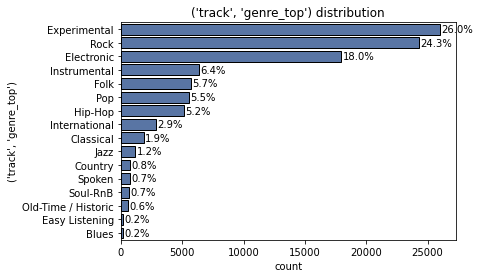

In [7269]:
column_name = ('track', 'genre_top')
sns_countplot(tracks, column_name, "", False, True)

<h6> ('album', 'type') after imputation </h6>

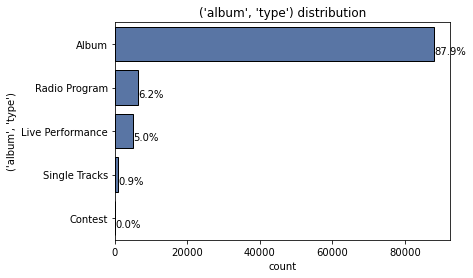

In [7270]:
column_name = ('album', 'type')
sns_countplot(tracks, column_name, "", False, True)

<font color="orange"><h3>('track', 'bit_rate') imputation </h3></font>
Imputation idea:

**Hyphotesis 1**: usually artists perform songs quite similar in the same album: Usually an artist performs a narrow set of musical genres in the same album. So, if a given artist has two songs belonging to the same genre_top, in the same album, the first having a known bit_rate, the second a bit_rate set to -1, we can quite confidently substitue the missing value with the first bit_rate;

**Hyphotesis 2**: usually artists perform songs quite similar among them: Usually an artist performs a narrow set of musical genres. So, if a given artist has two songs belonging to the same genre_top, the first having a known bit_rate, the second a bit_rate set to -1, we can quite confidently substitue the missing value with the first bit_rate;

If not exat album/artist bit_rate matching happens, we imputed each missing ('track', 'bit_rate'), using matching track's genre_top's median bit_rate.

In [7271]:
column_name = ('track', 'bit_rate')
missing_bit_rate_indeces = tracks[tracks[column_name] == -1].index

bit_rate_imputated = {}
bit_rate_ties = set()
missing_info = set()
for idx in missing_bit_rate_indeces:
    album = tracks.at[idx, ('album', 'id')]
    artist = tracks.at[idx, ('artist', 'id')]
    genre_top = tracks.at[idx, ('track', 'genre_top')]
    
    tmp_df = tracks[(tracks[('album', 'id')] == album) & 
             (tracks[('track', 'genre_top')] == genre_top) & 
             (tracks[column_name] != -1)]
    values = list(tmp_df[column_name].values)
    values_counter = Counter(values)
    
    artist_bit_rate_check = False
    if len(values_counter) > 1:  # majority vote
        sorted_values_counter = dict(sorted(values_counter.items(), key=lambda item: item[1], reverse=True))
        first_k, second_k =  itertools.islice(sorted_values_counter.keys(), 2)
        first_v, second_v =  itertools.islice(sorted_values_counter.values(), 2)
        
        if first_v == second_v:  # tie
            artist_bit_rate_check = True
        elif first_v < second_v:
            print("should not happen")
            sys.exit(-1)
        else: # first_v > second_v
            bit_rate_imputated[idx] = first_k
    elif len(values_counter) == 1:  # one vote
        first_k = next(iter(values_counter.keys()))
        bit_rate_imputated[idx] = first_k
    else:
        artist_bit_rate_check = True
        
    if artist_bit_rate_check:
        tmp_df = tracks[(tracks[('artist', 'id')] == artist) & 
                 (tracks[('track', 'genre_top')] == genre_top) & 
                 (tracks[column_name] != -1)]
        values = list(tmp_df[column_name].values)
        values_counter = Counter(values)

        if len(values_counter) > 1:  # majority vote
            sorted_values_counter = dict(sorted(values_counter.items(), key=lambda item: item[1], reverse=True))
            first_k, second_k =  itertools.islice(sorted_values_counter.keys(), 2)
            first_v, second_v =  itertools.islice(sorted_values_counter.values(), 2)

            if first_v == second_v:  # tie
                bit_rate_ties.add(idx)
            elif first_v < second_v:
                print("should not happen")
                sys.exit(-1)
            else: # first_v > second_v
                bit_rate_imputated[idx] = first_k
        elif len(values_counter) == 1:  # one vote
            first_k = next(iter(values_counter.keys()))
            bit_rate_imputated[idx] = first_k
        else:
             missing_info.add(idx)
    
    # solving ties or not other matching album and artist using genre_top bit_rate median
    if (idx in bit_rate_ties) or (idx in missing_info):
        median_bit_rate = tracks[(tracks[('track', 'genre_top')] == genre_top) & 
                                    (tracks[('track', 'bit_rate')] != -1)][('track', 'bit_rate')].median()
        bit_rate_imputated[idx] = median_bit_rate

print("missing_bit_rate_indeces", len(missing_bit_rate_indeces))  # initially were 105
print("bit_rate_imputated", len(bit_rate_imputated))

missing_bit_rate_indeces 76
bit_rate_imputated 76


In [7272]:
# imputing ('track', 'bit_rate') rows
for key, value in bit_rate_imputated.items():
    tracks.at[key, ('track', 'bit_rate')] = value

In [7273]:
# removing NOT impunted ('track', 'bit_rate') rows
remaining_bit_rates = list(set(missing_bit_rate_indeces).difference(set(bit_rate_imputated.keys())))
tracks.drop(remaining_bit_rates, axis=0, inplace=True)
tracks.reset_index(drop=True, inplace=True)

# checking
print("('track', 'bit_rate') missing values", tracks[tracks[('track', 'bit_rate')] == -1].shape[0])
print("NEW DATAFRAME SHAPE", tracks.shape[0])

('track', 'bit_rate') missing values 0
NEW DATAFRAME SHAPE 100149


<font color="red"><h1>Contest and Single Tracks album types removal</h1></font>
Since in the dataset album of type Contest and Single Tracks are a minority (0.01% and 0.9%) we proceed by removing them, both for album type imputation facility (remains Album, Radio Program, Live Performance) and album type uniformity in the dataset, to ease future models' performance. 

In [ ]:
to_drop = tracks[tracks[('album', 'type').isin(["Conest", "Single Tracks"])]].index

# tracks.drop(to_drop, axis=0, inplace=True)
# tracks.reset_index(drop=True, inplace=True)
# checking
# print("Conest or Single Tracks albums", tracks[tracks[('album', 'type').isin(["Conest", "Single Tracks"])]].shape[0])

<h2>Echonest features </h2>

For **13,129 tracks**, we have 2 pools of audio and temporal features (**93,445 tracks** apparently don't have them):

- **audio_features**:
    1. acousticness
    2. danceability
    3. energy
    4. instrumentalness	
    5. liveness	
    6. speechiness	
    7. tempo
    8. valence    

- **temporal_features**:
    1. '000'
    ... 
    
    223. '223'
    
<font color=red> Our main problem in using the audio feature is however that only **12.32%** of tracks share this info. Among our main genre_top tracks we also notice a high imbalance, due to the fact that we have audio features only for:
- 3892 Rock  (27.44%)
- 17 Experimental (0.16%)
- 2170 Electronic  (23.15%)

</font>

In [ ]:
echonestData = pd.read_csv('../../data/fma_metadata/echonest.csv',index_col=0, header=[0, 1, 2])
echonestData.shape

In [ ]:
echonestData.head().T

In [ ]:
audioFeatures = echonestData['echonest']['audio_features']
audioFeatures.head()

<h6>Checking how many tracks haven't audio features in the whole dataset</h6>

In [ ]:
tracks_ids = list(tracks.index.values)
echonest_ids = list(audioFeatures.index.values)
print(len(set(tracks_ids).difference(set(echonest_ids))))

<h6>Checking genre_top distribution among audio features</h6>

In [ ]:
audioFeaturesTotalSet=audioFeatures.merge(tracks, left_index=True, right_index=True, how='inner')
audioFeaturesTotalSet.shape

In [ ]:
audioFeaturesTotalSet[[('track', 'genre_top')]].apply(pd.value_counts).plot(kind='bar', legend=False, title="Tracks with audio features top genre")
plt.show()

In [ ]:
top_genres = ["Rock", "Experimental", "Electronic"]
for genre_top in top_genres:
    print(genre_top, audioFeaturesTotalSet[audioFeaturesTotalSet[('track', 'genre_top')] == genre_top].shape[0],
     str((audioFeaturesTotalSet[audioFeaturesTotalSet[('track', 'genre_top')] == genre_top].shape[0] /
       tracks[tracks[('track', 'genre_top')] == genre_top].shape[0])*100) + "%")

We discover that only **Rock** and **Electronic** tracks have audio features (Experimental tracks are almost deprived about the info). 

<h6>Checking if exist differences among Rock, Experimental and Electronic tracks</h6>

In [ ]:
def plotTopGenreFeatures(df, genreTitle, colour):
    features = [np.median(df['acousticness'][df[('track', 'genre_top')] == genreTitle]), 
              np.median(df['danceability'][df[('track', 'genre_top')] == genreTitle]),
              np.median(df['energy'][df[('track', 'genre_top')] == genreTitle]),
              np.mean(df['instrumentalness'][df[('track', 'genre_top')] == genreTitle]),
              np.median(df['liveness'][df[('track', 'genre_top')] == genreTitle]),
              np.median(df['speechiness'][df[('track', 'genre_top')] == genreTitle]),
              np.median(df['tempo'][df[('track', 'genre_top')] == genreTitle]),
              np.median(df['valence'][df[('track', 'genre_top')] == genreTitle])]
    features[-2] = features[-2]/251
    features[-3] = features[-3] * 4
    features += features[:1]
    ax.plot(angles, features, color=colour, linewidth = 1, label = genreTitle)
    ax.fill(angles, features, color=colour, alpha = 0.25)

In [ ]:
tracks_top = tracks[(tracks[('track', 'genre_top')] == 'Electronic') |
                    (tracks[('track', 'genre_top')] == 'Experimental') |
                    (tracks[('track', 'genre_top')] == 'Rock')]
tracks_top.shape

In [ ]:
audioFeaturesSetA=audioFeatures.merge(tracks_top, left_index=True, right_index=True, how='inner')
audioFeaturesSetA.shape

In [ ]:
num_vars=len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

plotTopGenreFeatures(audioFeaturesSetA, 'Electronic','green')
plotTopGenreFeatures(audioFeaturesSetA, 'Experimental','blue')
plotTopGenreFeatures(audioFeaturesSetA, 'Rock','red')

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles), labels)

for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')

ax.set_ylim(0, 1)
ax.set_rlabel_position(180 / num_vars)
ax.set_title('Genres and features')
ax.legend(loc='lower center')
plt.show()

From the above radar plot we can notice that:

- **Experimental** music is defined by greater **valence** and **acousticness** values;
- **Electronic** and **Rock** music have almost overlllaping audio feature, with slighter higher **acousticness** value for **Rock** and higher **danceability, instrumentalness** and **speechiness** values for **Electronic**.

<h6>Checking if exist differences among Rock, Experimental, Electronic and Other tracks</h6>

In [ ]:
tracks_four = tracks[~(tracks[('track', 'genre_top')].isna())]
tracks_four.shape

In [ ]:
# replacing all genre_top with "Other" if not belonging to Electronic, Experimental, Rock
genre_top_map = {}
genre_tops = list(tracks[('track', 'genre_top')].unique())
for genre_top in genre_tops:
    if str(genre_top) == "nan":
        continue
    if str(genre_top) == "Electronic" or str(genre_top) == "Experimental" or str(genre_top) == "Rock":
        genre_top_map[str(genre_top)] = genre_top
    else:
         genre_top_map[str(genre_top)] = "Other"
tracks_four[('track', 'genre_top')] = tracks_four[('track', 'genre_top')].map(genre_top_map)
tracks_four[('track', 'genre_top')].unique()

In [ ]:
audioFeaturesSetB = audioFeatures.merge(tracks_four, left_index=True, right_index=True, how='inner')
audioFeaturesSetB.shape

In [ ]:
num_vars=len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

plotTopGenreFeatures(audioFeaturesSetB, 'Electronic','green')
plotTopGenreFeatures(audioFeaturesSetB, 'Experimental','blue')
plotTopGenreFeatures(audioFeaturesSetB, 'Rock','red')
plotTopGenreFeatures(audioFeaturesSetB, 'Other','yellow')

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles), labels)

for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')

ax.set_ylim(0, 1)
ax.set_rlabel_position(180 / num_vars)
ax.set_title('Genres and features')
ax.legend(loc='lower center')
plt.show()

From the above radar plot we can notice that:

- **Experimental** music is defined by greater **valence** and **acousticness** values;
- **Electronic** and **Rock** music have almost overlllaping audio feature, with slighter higher **acousticness** value for **Rock** and higher **danceability, instrumentalness** and **speechiness** values for **Electronic**;
- **Other** music has greater **acousticness** values and **skrinked other audio features**.

We can finally notice how the <font color=red>audio features liveness, speechiness and tempo are the most overlapping </font> (and so probably the lest relevant features in the models' features selection process).

<h2> Librosa features </h2> 

For each 106,572 tracks, we have 518 Librosa features, having the following cardinalities:

1. **chroma_cens** = 12
2. **chroma_cqt** = 12
3. **chroma_stft** = 12
4. **mfcc** = 20
5. **rmse** = 1
6. **spectral_bandwidth** = 1
7. **spectral_centroid** = 1
8. **spectral_contrast** = 7
9. **spectral_rolloff** = 1
10. **tonnetz** = 6
11. **zcr** = 1

and for each cardinality feature we have the following information:
1. min = min feature's value;
2. max = max feature's value;
3. median = median feature's value;
4. mean = avg feature's values;
5. std = std feature's values;
6. skew = feature's values asymmetry distribution
7. kurtosis = feature's values tailedness distribution

In [ ]:
librosaFeatures = pd.read_csv('../../data/fma_metadata/features.csv', index_col=0, header=[0, 1, 2])
librosaFeatures.shape

In [ ]:
librosaFeatures.head(2)

In [ ]:
librosa_columns = {}
librosa_columns_info = set()
for c in librosaFeatures.columns:
    librosa_columns_info.add(c[1])
    try:
        if librosa_columns[str(c[0])] < c[2]:
            librosa_columns[str(c[0])] = c[2]
    except KeyError:
        librosa_columns[str(c[0])] = c[2]
print("Librosa columns:", librosa_columns)
print("Librosa columns info:", librosa_columns_info)

<h6>Checking librosa features among Rock, Experimental and Electronic genre_top tracks</h6>

In [ ]:
librosaSetA = librosaFeatures.merge(tracks_top, left_index=True, right_index=True, how='inner')
librosaSetA.shape

In [ ]:
top_genres = ["Rock", "Experimental", "Electronic"]
for var in librosaSetA.columns:
    if var[1] != "mean":
        continue
    for genre_top in top_genres:
        sns.distplot(librosaSetA[librosaSetA[('track', 'genre_top')] == genre_top][var], kde=False, label=genre_top)
    plt.ylabel("count")
    plt.legend()
    plt.title("Genre_top's " + var[0] + " distribution")
    plt.show()

From the above plots we can observe that the following librosa are so characterized:
- all ('chroma_cens', 'mean', '*') are related to ('chroma_cens', 'mean', '01');
- all ('chroma_cqt', 'mean', '*') are related to ('chroma_cqt', 'mean', '01');
- all ('chroma_stft', 'mean', '*') are related to ('chroma_stft', 'mean', '01');
- all ('mfcc', 'mean', '*') are different among them;
- ('rmse', 'mean', '01') is unique in its kind;
- ('spectral_bandwidth', 'mean', '01') is unique in its kind;
- ('spectral_centroid', 'mean', '01') is unique in its kind;
- ('spectral_rolloff', 'mean', '01') is unique in its kind;
- ('spectral_contrast', 'mean', '01'), ('spectral_contrast', 'mean', '07') are unique in their kind, 
  all the other ('spectral_contrast', 'mean', '*') are related to ('spectral_contrast', 'mean', '02');
- ('tonnetz', 'mean', '01') and ('tonnetz', 'mean', '02') are unique in their kind, all the other
  ('tonnetz', 'mean', '*') are related to ('tonnetz', 'mean', '03');
- ('zcr', 'mean', '01') is unique in it kind.

Taking into account only the Rock, Experimental and Electronic as genre_top, we will need to use **34 librosa features** to discriminated among these music genres.

<h6>Checking librosa features among Rock, Experimental, Electronic and Other genre_top tracks</h6>

In [ ]:
librosaSetB = librosaFeatures.merge(tracks_four, left_index=True, right_index=True, how='inner')
librosaSetB.shape

In [ ]:
librosaSetB[librosaSetB[('track', 'genre_top')] == "Other"][('zcr', 'mean', '01')]

In [ ]:
plt.rcParams["patch.force_edgecolor"] = True
top_genres = ["Rock", "Experimental", "Electronic", "Other"]
for var in librosaSetB.columns:
    if var[1] != "mean":
        continue
    for genre_top in top_genres:
        sns.distplot(librosaSetB[librosaSetB[('track', 'genre_top')] == genre_top][var], kde=False, label=genre_top)
    plt.ylabel("count")
    plt.legend()
    plt.title("Genre_top's " + var[0] + " distribution")
    plt.show()

In [ ]:
plt.rcParams["patch.force_edgecolor"] = True
top_genres = ["Rock", "Experimental", "Electronic", "Other"]
for var in librosaSetB.columns:
    if var[1] != "mean":
        continue
    for genre_top in top_genres:
        sns.kdeplot(librosaSetB[librosaSetB[('track', 'genre_top')] == genre_top][var], label=genre_top)
    plt.ylabel("density")
    plt.legend()
    plt.title("Genre_top's " + var[0] + " distribution")
    plt.show()

TODO From the above plots we can observe that:

<h2> Classification of genres based on few librosa features </h2>

In [ ]:
main_librosa_columns = []
main_librosa_columns_names = []
for var in librosaFeatures.columns:
    if var[1] == "mean":
        main_librosa_columns.append(librosaFeatures[str(var[0])][str(var[1])][str(var[2])])
        main_librosa_columns_names.append(str(var[0]) + "_" + str(var[2]))

librosaMainFeatures=pd.concat(main_librosa_columns, axis=1)
librosaMainFeatures.columns = main_librosa_columns_names  # rename DataFrame names
librosaMainFeatures.shape

In [ ]:
# merge librosa DataFrame with additional tracks info
# TODO
librosaMainFeatures = pd.concat([librosaMainFeatures, tracks[[('track', 'genre_top')]]], axis=1)
librosaMainFeatures.shape

In [ ]:
# TODO: remove this 'NaN' imputation
"""cleanup_nums = {('track', 'genre_top'): {"Rock": "Rock",  "Experimental": "Experimental",
                            "Electronic": "Electronic", "NaN": "NaN", "Hip-Hop": "Other", 
                            "Pop": "Other", "Folk": "Other", "Jazz": "Other", "Spoken": "Other", 
                            "International": "Other", "Soul-RnB": "Other", "Blues": "Other", 
                            "Country": "Other", "Classical": "Other", "Old-Time / Historic": "Other",
                            "Instrumental": "Other", "Easy Listening": "Other"}}"""


librosaMainFeatures = librosaMainFeatures.fillna("NaN") 
cleanup_nums = {('track', 'genre_top'): {"Rock": 1,  "Experimental": 2,
                            "Electronic": 3, "NaN": 4, "Hip-Hop": 4, 
                            "Pop": 4, "Folk": 4, "Jazz": 4, "Spoken": 4, 
                            "International": 4, "Soul-RnB": 4, "Blues": 4, 
                            "Country": 4, "Classical": 4, "Old-Time / Historic": 4,
                            "Instrumental": 4, "Easy Listening": 4}}
librosaMainFeatures = librosaMainFeatures.replace(cleanup_nums)

In [ ]:
librosaMainFeatures[('track', 'genre_top')].unique()

In [ ]:
x = librosaMainFeatures.drop([('track', 'genre_top')], axis=1)
y = librosaMainFeatures[('track', 'genre_top')]

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

from sklearn.metrics import f1_score
print('F1Score of Logistic Regression: ', f1_score(y_test, y_pred, average="macro"))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=300, bootstrap = True, max_features = 'sqrt')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(x_test, y_test)))
print('F1Score of Random Forest classifier ',f1_score(y_test, y_pred, average="macro"))

In [ ]:
importance=list(model.feature_importances_)
allfeatures=librosaMainFeatures.drop(('track', 'genre_top'),axis=1)
features=list(allfeatures.columns)
fig = plt.figure(figsize = (20, 20)) 
plt.barh(features, importance, color ='grey') 
plt.title('Random Forest classifier-Feature importances')
plt.xlabel("Features importance") 
plt.ylabel("Audio features") 
plt.show() 

In [ ]:
zipped_lists=zip(importance,features)
zipped_lists=list(sorted(zipped_lists))
importanceSorted,featuresSorted = zip(*zipped_lists)
fig = plt.figure(figsize = (20, 20)) 
plt.barh(list(featuresSorted), list(importanceSorted), color ='red') 
plt.title('Random Forest classifier-Feature importances (Sorted)')
plt.ylabel("Feature importance") 
plt.xlabel("Audio Features") 
plt.show()

<h6>Keeping only feature's mean 01 values (= 01 stands for song's beginning???) </h6> 

In [ ]:
librosaMainFeatures=pd.concat([librosaFeatures['chroma_cens']['mean']['01'],\
                               librosaFeatures['chroma_cqt']['mean']['01'],\
                               librosaFeatures['chroma_stft']['mean']['01'],\
                               librosaFeatures['mfcc']['mean']['01'], \
                               librosaFeatures['rmse']['mean']['01'], \
                               librosaFeatures['spectral_bandwidth']['mean']['01'],\
                               librosaFeatures['spectral_centroid']['mean']['01'], \
                               librosaFeatures['spectral_contrast']['mean']['01'],\
                               librosaFeatures['spectral_rolloff']['mean']['01'],\
                               librosaFeatures['tonnetz']['mean']['01'], \
                               librosaFeatures['zcr']['mean']['01']], axis=1,)
librosaMainFeatures.shape

In [ ]:
librosaMainFeatures.columns = list(librosa_columns.keys())

In [ ]:
librosaMainFeatures.head().T

In [ ]:
# merge librosa DataFrame with additional tracks info
# TODO
librosaMainFeatures = pd.concat([librosaMainFeatures, tracks[[('track', 'genre_top')]]], axis=1)
librosaMainFeatures.shape

In [ ]:
# TODO: remove this 'NaN' imputation
"""cleanup_nums = {('track', 'genre_top'): {"Rock": "Rock",  "Experimental": "Experimental",
                            "Electronic": "Electronic", "NaN": "NaN", "Hip-Hop": "Other", 
                            "Pop": "Other", "Folk": "Other", "Jazz": "Other", "Spoken": "Other", 
                            "International": "Other", "Soul-RnB": "Other", "Blues": "Other", 
                            "Country": "Other", "Classical": "Other", "Old-Time / Historic": "Other",
                            "Instrumental": "Other", "Easy Listening": "Other"}}"""


librosaMainFeatures = librosaMainFeatures.fillna("NaN") 
cleanup_nums = {('track', 'genre_top'): {"Rock": 1,  "Experimental": 2,
                            "Electronic": 3, "NaN": 4, "Hip-Hop": 4, 
                            "Pop": 4, "Folk": 4, "Jazz": 4, "Spoken": 4, 
                            "International": 4, "Soul-RnB": 4, "Blues": 4, 
                            "Country": 4, "Classical": 4, "Old-Time / Historic": 4,
                            "Instrumental": 4, "Easy Listening": 4}}
librosaMainFeatures = librosaMainFeatures.replace(cleanup_nums)

In [ ]:
librosaMainFeatures[('track', 'genre_top')].unique()

In [ ]:
x = librosaMainFeatures.drop([('track', 'genre_top')], axis=1)
y = librosaMainFeatures[('track', 'genre_top')]

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

from sklearn.metrics import f1_score
print('F1Score of Logistic Regression: ', f1_score(y_test, y_pred, average="macro"))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=300, bootstrap = True, max_features = 'sqrt')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(x_test, y_test)))
print('F1Score of Random Forest classifier ',f1_score(y_test, y_pred, average="macro"))

In [ ]:
importance=list(model.feature_importances_)
allfeatures=librosaMainFeatures.drop(('track', 'genre_top'),axis=1)
features=list(allfeatures.columns)
fig = plt.figure(figsize = (20, 20)) 
plt.barh(features, importance, color ='grey') 
plt.title('Random Forest classifier-Feature importances')
plt.xlabel("Features importance") 
plt.ylabel("Audio features") 
plt.show() 

In [ ]:
zipped_lists=zip(importance,features)
zipped_lists=list(sorted(zipped_lists))
importanceSorted,featuresSorted = zip(*zipped_lists)
fig = plt.figure(figsize = (20, 20)) 
plt.barh(list(featuresSorted), list(importanceSorted), color ='red') 
plt.title('Random Forest classifier-Feature importances (Sorted)')
plt.ylabel("Feature importance") 
plt.xlabel("Audio Features") 
plt.show()